#### Improvements:
1. Contents page


In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer # ported to sklearn from fancyimpute
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from category_encoders import CatBoostEncoder
from tpot import TPOTClassifier
from espressomaker import Espresso
import xgboost as xgb
from hyperopt import hp, fmin, tpe
import lightgbm as lgb
from catboost import CatBoostClassifier

%config InlineBackend.figure_format = 'retina'

In [246]:
df = pd.read_csv('train.csv')

In [247]:
df_test = pd.read_csv('test.csv')

In [248]:
df.head()

age workclass  fnlwgt      education  education-num       marital-status  \
0   30         ?  147215   Some-college             10        Never-married   
1   60   Private  173960      Bachelors             13             Divorced   
2   52         ?  105428   Some-college             10   Married-civ-spouse   
3   37   Private  112497      Bachelors             13   Married-civ-spouse   
4   63   Private  137843   Some-college             10   Married-civ-spouse   

        occupation    relationship      sex  capital-gain  capital-loss  \
0                ?       Own-child   Female             0             0   
1   Prof-specialty   Not-in-family   Female             0             0   
2                ?         Husband     Male             0             0   
3            Sales         Husband     Male             0             0   
4            Sales         Husband     Male          7298             0   

   hours-per-week  native-country  exceeds50K  
0              30   United-States           0  
1              42   United-States           0  
2              12   United-States           0  
3              60   United-States           0  
4              48   United-States           1

In [249]:
df.shape

(24421, 14)

In [250]:
# We can see that we have 2 main types of data: int64 and object.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24421 entries, 0 to 24420
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             24421 non-null  int64 
 1   workclass       24421 non-null  object
 2   fnlwgt          24421 non-null  int64 
 3   education       24421 non-null  object
 4   education-num   24421 non-null  int64 
 5   marital-status  24421 non-null  object
 6   occupation      24421 non-null  object
 7   relationship    24421 non-null  object
 8   sex             24421 non-null  object
 9   capital-gain    24421 non-null  int64 
 10  capital-loss    24421 non-null  int64 
 11  hours-per-week  24421 non-null  int64 
 12  native-country  24421 non-null  object
 13  exceeds50K      24421 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 2.6+ MB


In [251]:
df.rename(columns={"exceeds50K":"class"}, inplace=True)

In [252]:
df.describe() # this is applicable to numeric columns
# We can see that our features are of very different scales.

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  24421.000000  2.442100e+04   24421.000000  24421.000000  24421.000000   
mean      38.587036  1.888204e+05      10.096515   1116.029974     86.547643   
std       13.677055  1.046917e+05       2.574488   7646.590185    399.096945   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175830e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.778240e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.365860e+05      13.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   3900.000000   

       hours-per-week         class  
count    24421.000000  24421.000000  
mean        40.511609      0.239998  
std         12.367526      0.427091  
min          1.000000      0.000000  
25%         40.000000      0.000000  
50%         40.000000      0.000000  
75%         45.000000      0.000000  
max         99.000000      1.000000

#### Exploration of numeric features.

In [253]:
numerical = df.select_dtypes(include = ['int'])
numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24421 entries, 0 to 24420
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             24421 non-null  int64
 1   fnlwgt          24421 non-null  int64
 2   education-num   24421 non-null  int64
 3   capital-gain    24421 non-null  int64
 4   capital-loss    24421 non-null  int64
 5   hours-per-week  24421 non-null  int64
 6   class           24421 non-null  int64
dtypes: int64(7)
memory usage: 1.3 MB


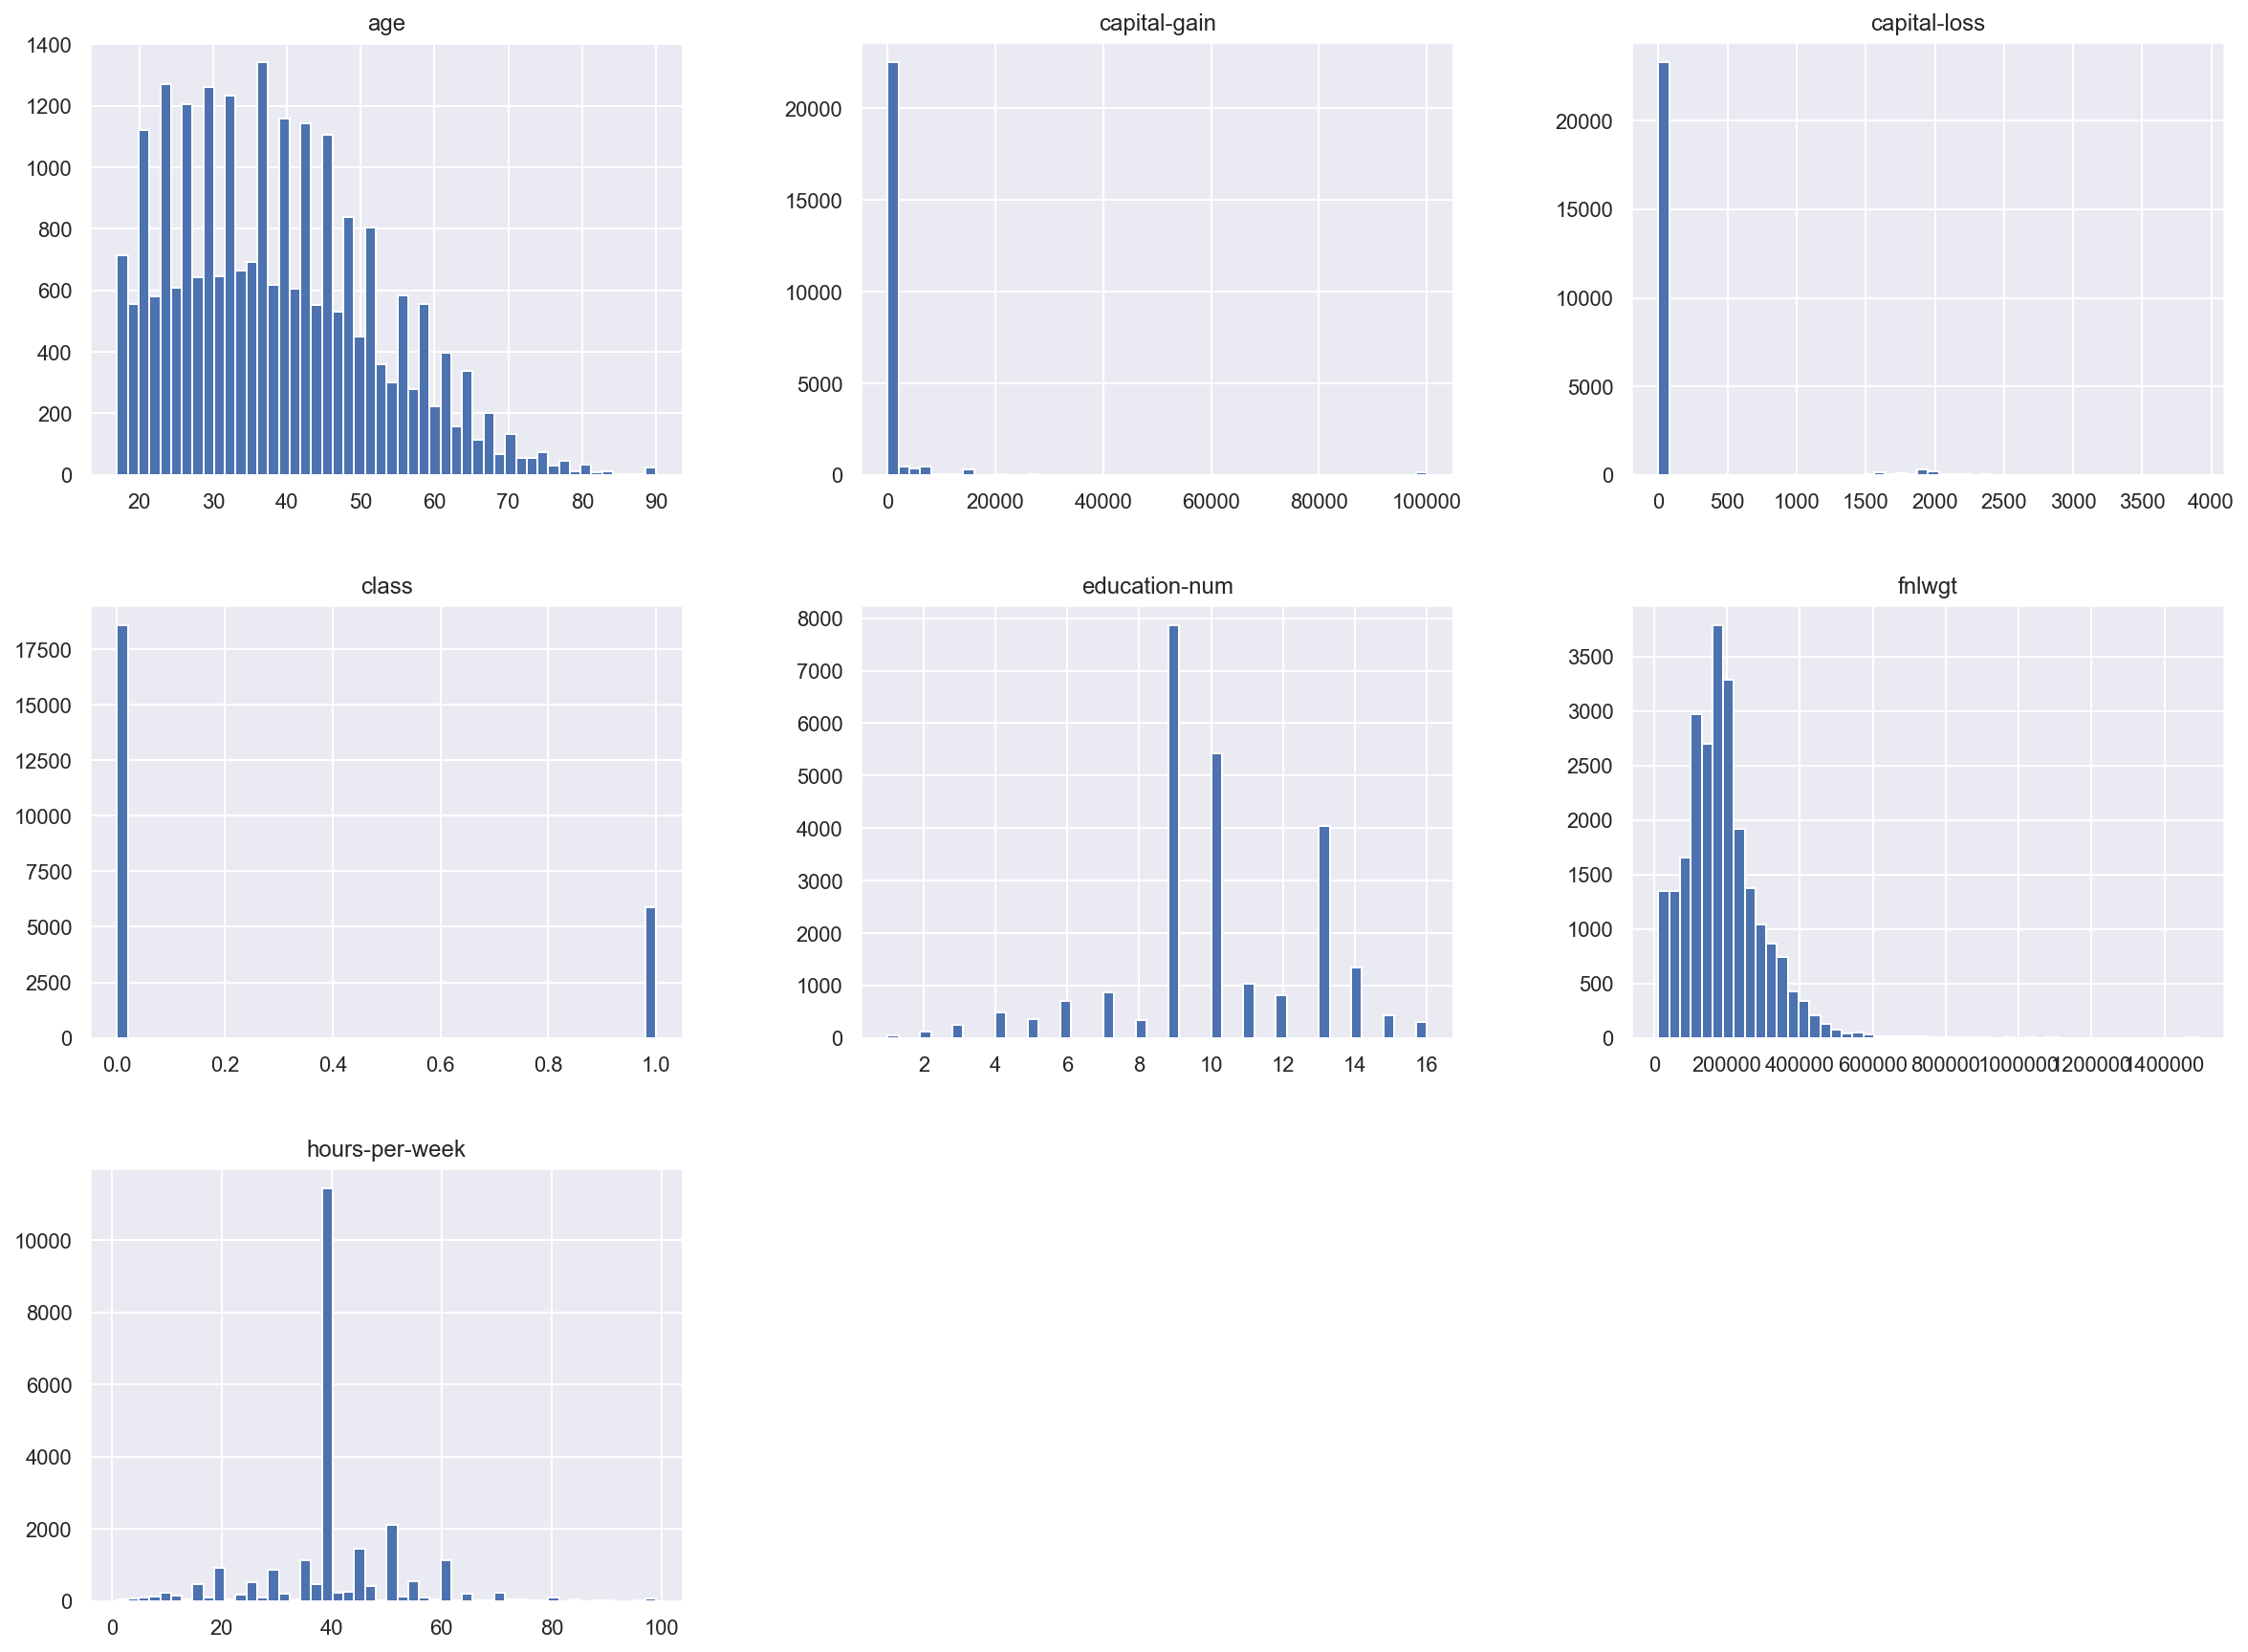

In [254]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

Some observations for above numerical plots:
1. Age should be cut into different discrete categories for better visualization? scatter plot with age and education number.
2. Capital-gain and capital-loss: Values are very skewed, we just care whether there is a loss or gain or stayput?
3. Class is imbalanced, optimizing for AUC does not sound like a good idea.
4. Education-num and hours-per-week looks roughly normally distributed.
5. Hours-per-week looks like there are some outliers. 
6. fnlwgt looks right-tail heavy, may want to consider doing some log transformations.

In [255]:
numerical_cols = list(set(numerical.columns) - set(['class']))

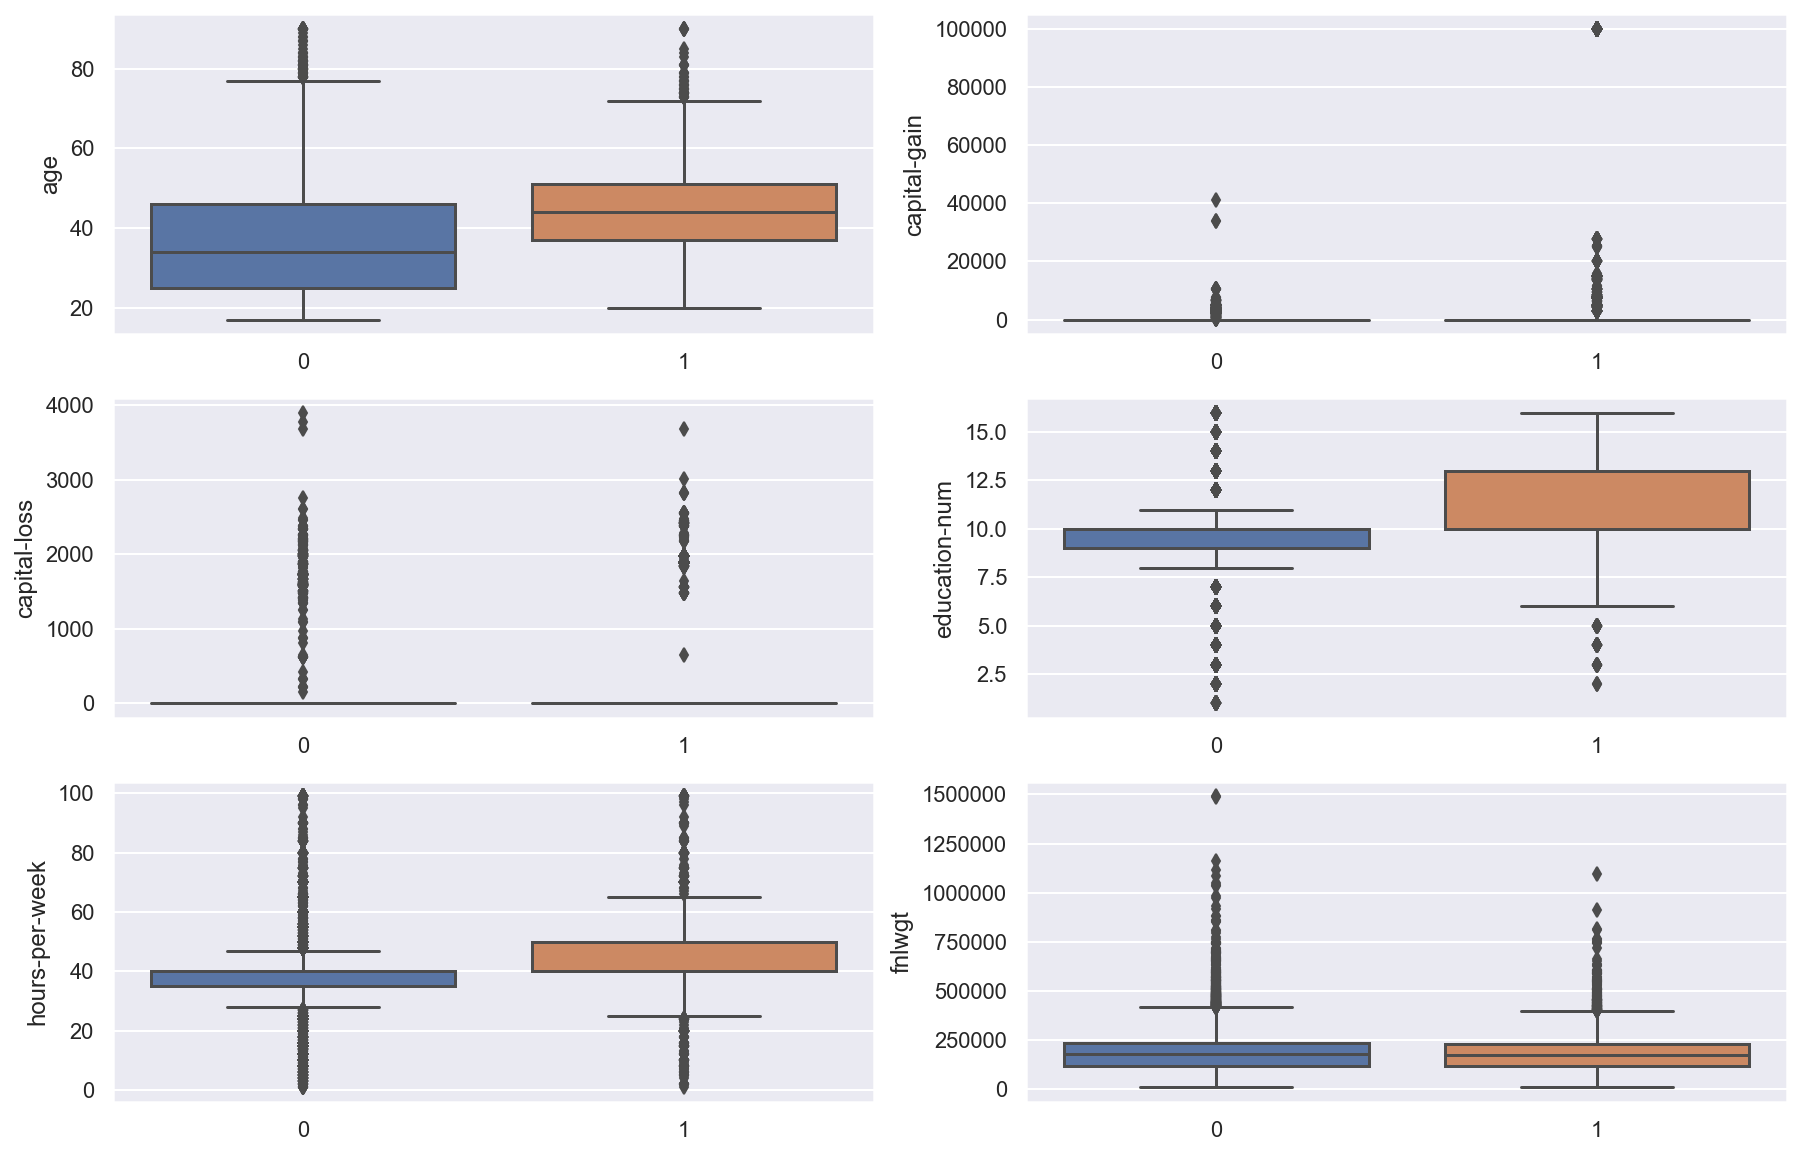

In [256]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,10))
for idx, feat in enumerate(numerical_cols):
    ax = axes[int(idx/2), idx%2]
    sns.boxplot(x='class',y=feat, data=df,ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feat)
plt.show()

It is clear that we have 3 important numerical features which have discriminative power for classification: **education-num, hours-per-week and age.** What does this imply, when we do the train-test split, we should make sure our splits also have a fair distribution over these categories. 

We can further confirm this using Point Biserial Correlation.

In [257]:
numerical_cols += ['class']

In [258]:
# # https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
# from scipy.stats import pointbiserialr

# numerical_features = df['hours-per-week']
# labels = df['class']

# pbc = pointbiserialr(numerical_features, labels)
# print(pbc)

df[numerical_cols].corr()

# We can consider dropping fnlwgt since it clearly has nothing to do with
# our target variable.


age  capital-gain  capital-loss  education-num  \
age             1.000000      0.084777      0.050775       0.033251   
capital-gain    0.084777      1.000000     -0.031652       0.127242   
capital-loss    0.050775     -0.031652      1.000000       0.082065   
education-num   0.033251      0.127242      0.082065       1.000000   
hours-per-week  0.076735      0.089132      0.052133       0.143665   
fnlwgt         -0.079282     -0.004108     -0.004153      -0.043784   
class           0.237521      0.226486      0.151032       0.333001   

                hours-per-week    fnlwgt     class  
age                   0.076735 -0.079282  0.237521  
capital-gain          0.089132 -0.004108  0.226486  
capital-loss          0.052133 -0.004153  0.151032  
education-num         0.143665 -0.043784  0.333001  
hours-per-week        1.000000 -0.015185  0.220001  
fnlwgt               -0.015185  1.000000 -0.005331  
class                 0.220001 -0.005331  1.000000

#### Exploration of categorical features.

In [259]:
categorical = df.select_dtypes(include = ['object'])

In [260]:
categorical.info()

# We note that education is just a discrete representation of our education-num
# feature, we should not have duplicate information, and just drop education. 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24421 entries, 0 to 24420
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       24421 non-null  object
 1   education       24421 non-null  object
 2   marital-status  24421 non-null  object
 3   occupation      24421 non-null  object
 4   relationship    24421 non-null  object
 5   sex             24421 non-null  object
 6   native-country  24421 non-null  object
dtypes: object(7)
memory usage: 1.3+ MB


In [261]:
categorical_cols = list(set(categorical.columns) - set(['education']))

In [262]:
for cat in categorical_cols:
    print("Number of levels in category '{0}': \b {1:2}".format(cat, df[cat].unique().size))

Number of levels in category 'workclass':   9
Number of levels in category 'relationship':   6
Number of levels in category 'occupation':  15
Number of levels in category 'native-country':  41
Number of levels in category 'sex':   2
Number of levels in category 'marital-status':   7


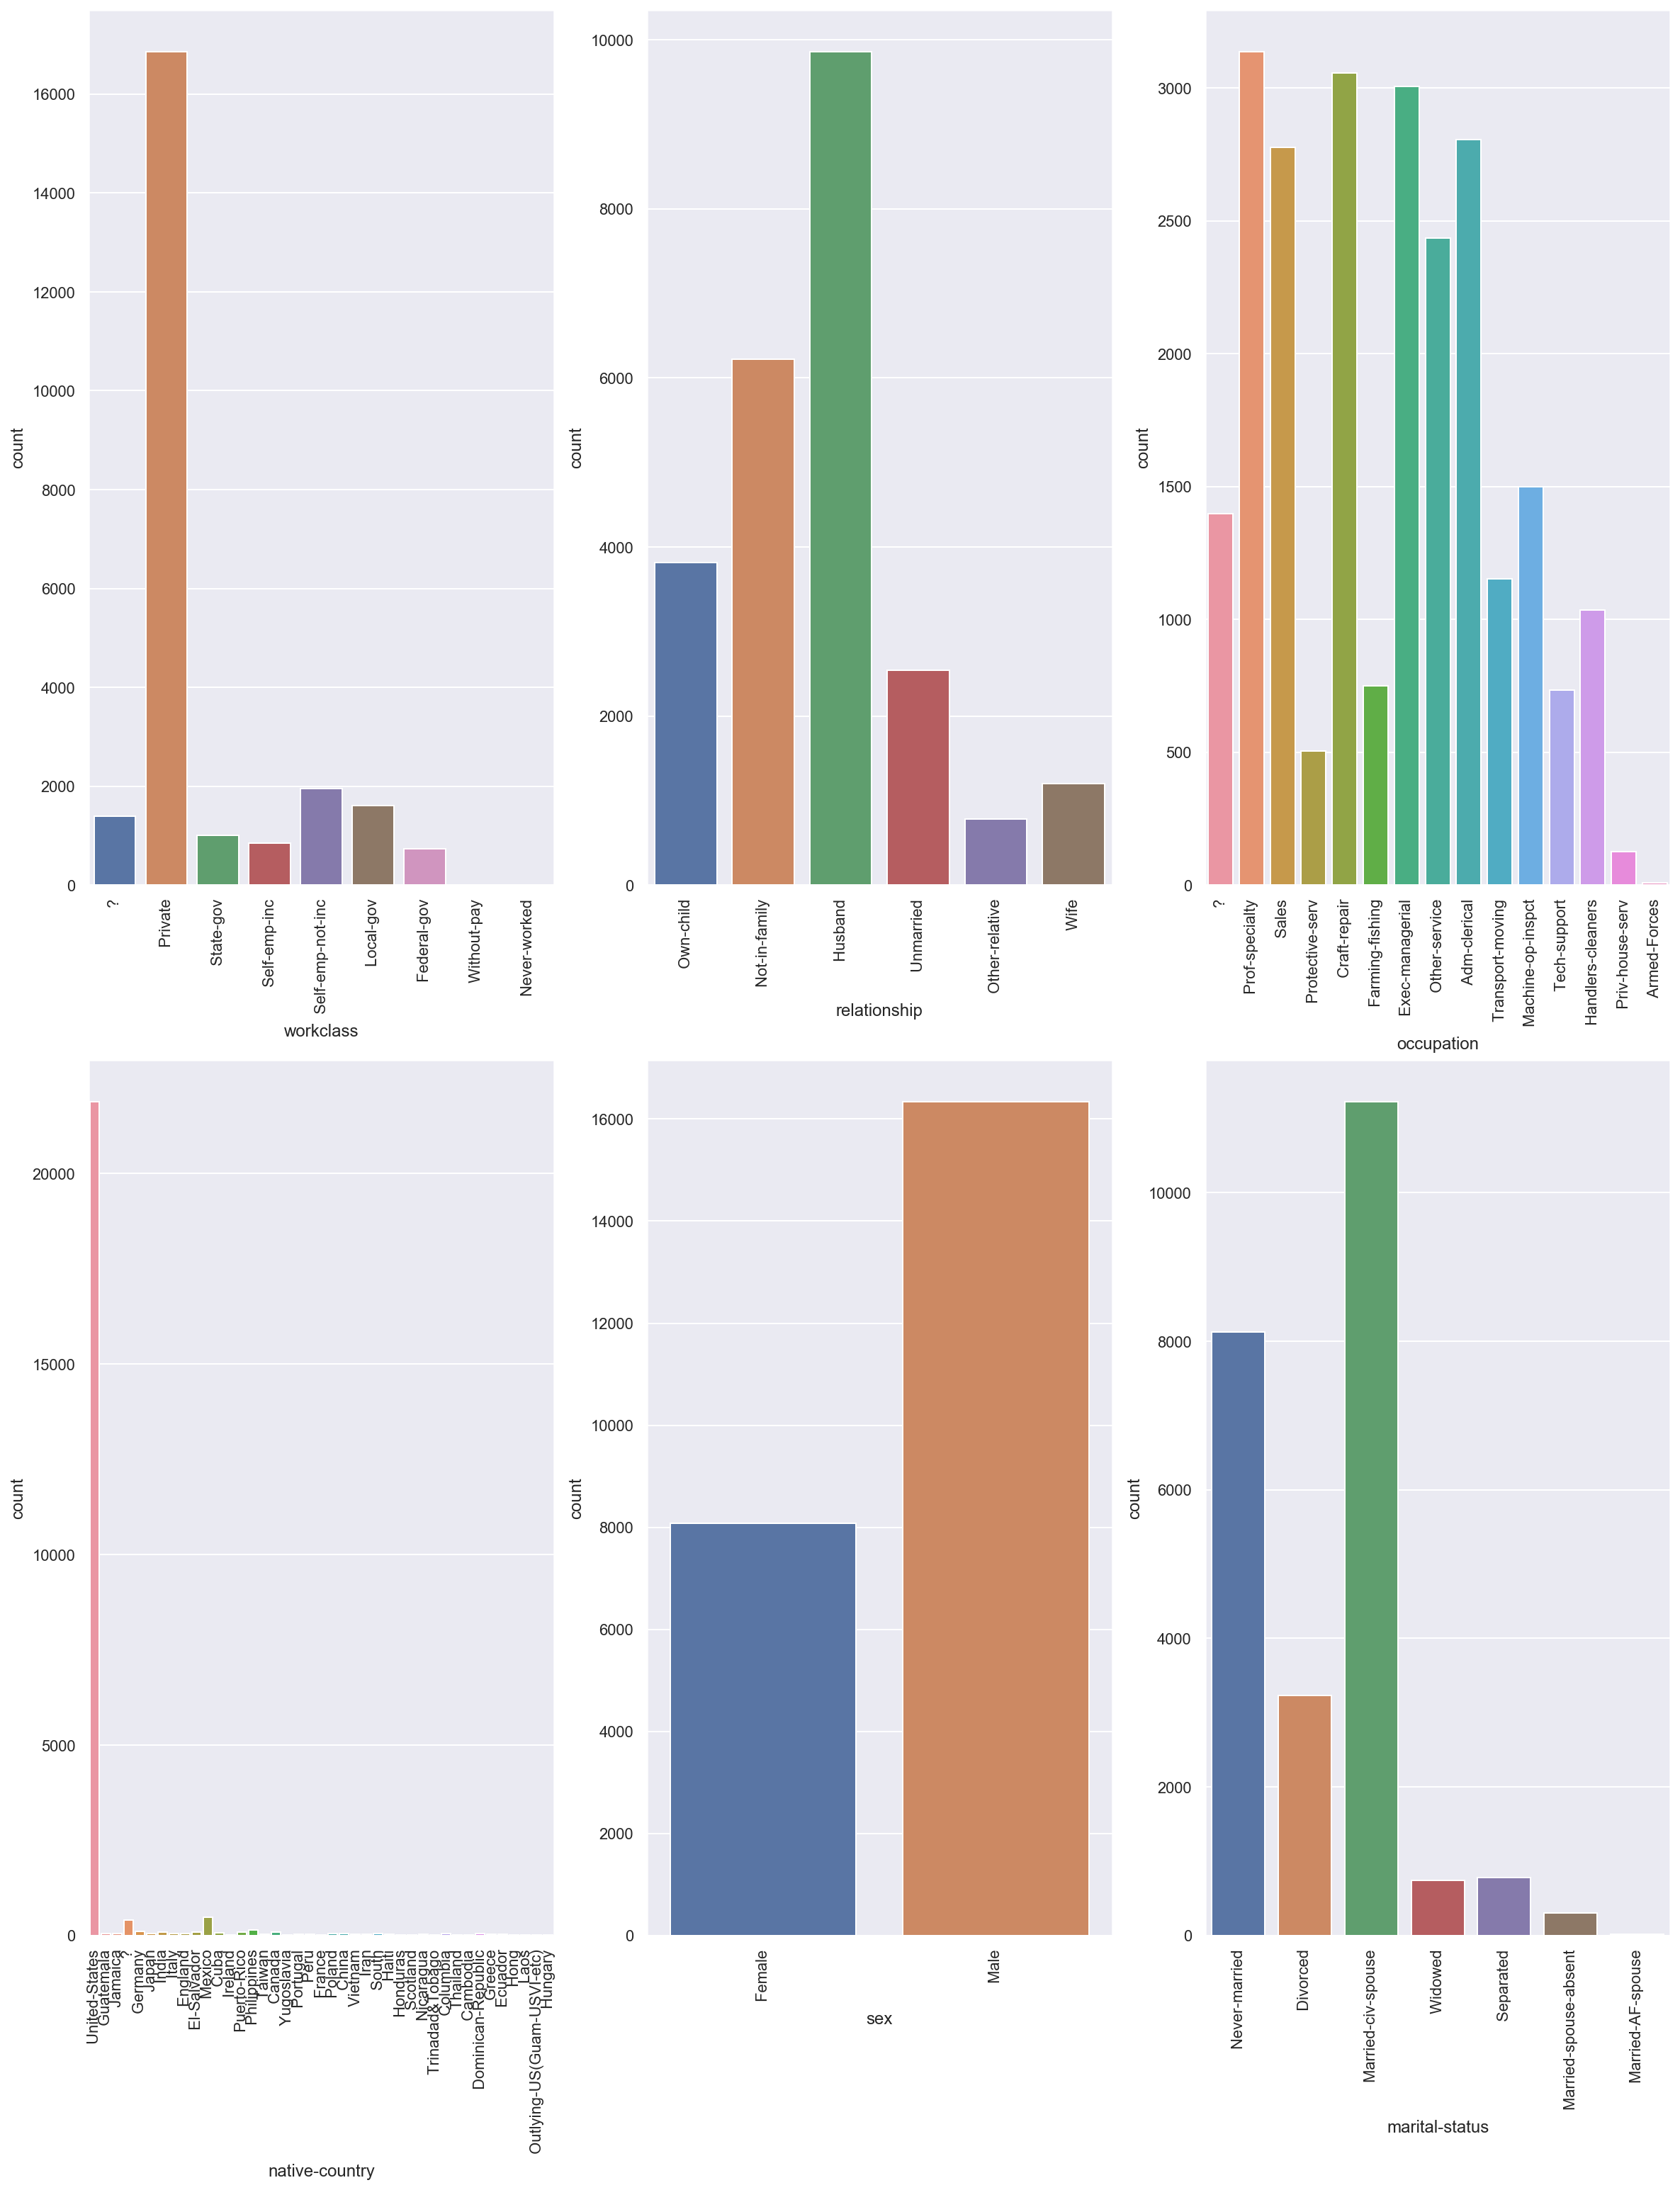

In [263]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(20,25))
for idx, feat in enumerate(categorical_cols):
    ax = axes[int(idx/3), idx%3]
    sns.countplot(x=feat, data=df,ax=ax)
#     ax.set_xlabel('')
#     ax.set_ylabel(feat)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.show()

Some conclusions about the plot:

Notably, we see that in the native-country field, the U.S count is exceptionally skewed. For plotting purposes, given that we have too many categories for nationality, we will not plot the countplot for the nationality feature. Let us do a simple countplot for the other features.

In [264]:
categorical_cols_toplot = ['relationship', 'occupation', 'workclass',
                          'sex', 'marital-status']

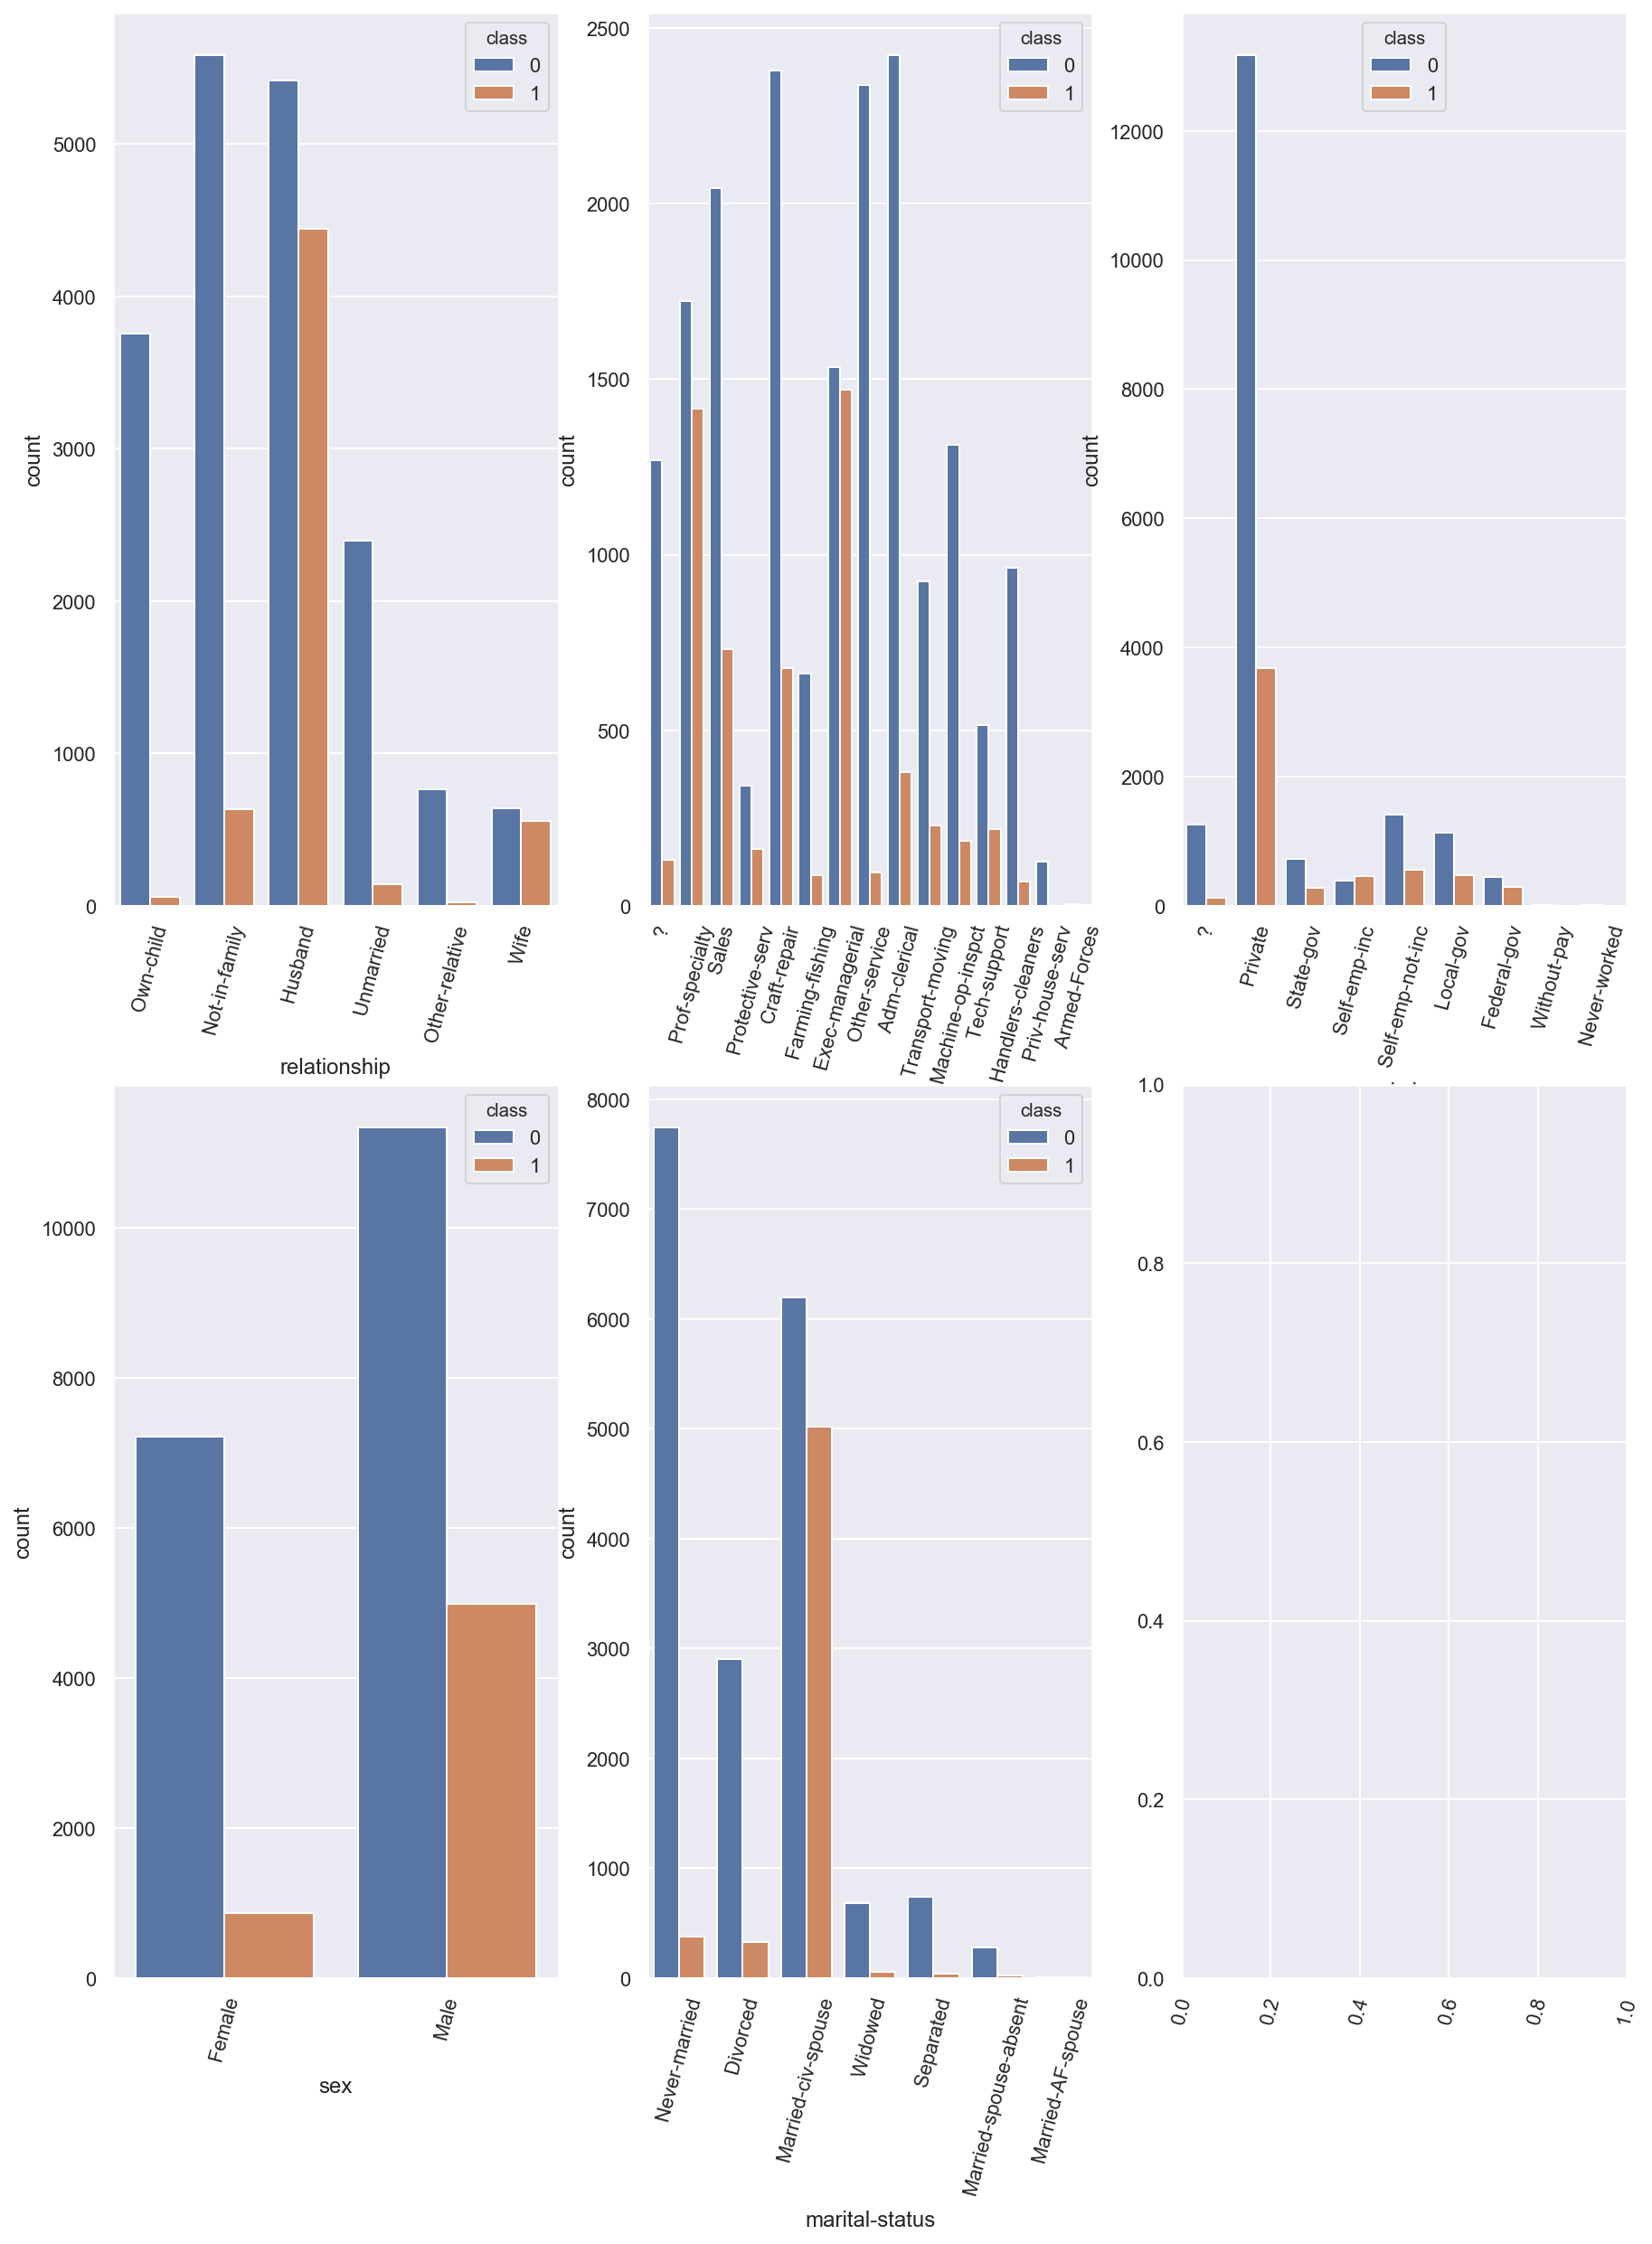

In [265]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(15,20))
for idx, feat in enumerate(categorical_cols_toplot):
    ax = axes[int(idx/3), idx%3]
    sns.countplot(df[feat], hue=df['class'],ax=ax)
#     ax.set_xlabel('')
#     ax.set_ylabel(feat)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=75)
plt.show()

Some interesting observations:
1. Males have a higher proportion earning > 50K.
2. The relationship variable and marital-status are painting the same picture that a large proportion of married-civ-spouse (husbands and wives) are generally earning more than 50K.
3. Generally all categorical features are influential in determining target variable.

For the nationalities, instead of plotting, we can consider doing a contigency table to understand if nationality does indeed affect our target variable. We should expect the ratios of our target variable to be about constant across the different nationalities, should nationality not be important.

We can see that countries such as Taiwan and Japan have a much higher proportion of '1' labels as compared to the other countries. It is clear that native-country does indeed influence the probability of the target variable. 

In [266]:
pd.crosstab(df['native-country'], df['class'], margins = 'index').sort_values(by = [1], ascending=False)

class                            0     1    All
native-country                                 
All                          18560  5861  24421
 United-States               16542  5341  21883
 ?                             300   110    410
 Philippines                   106    40    146
 India                          44    36     80
 Canada                         57    29     86
 Germany                        79    29    108
 Mexico                        458    24    482
 England                        35    23     58
 Japan                          29    20     49
 Italy                          38    19     57
 Cuba                           54    19     73
 China                          40    18     58
 Puerto-Rico                    74    15     89
 Taiwan                         23    12     35
 Iran                           25    11     36
 South                          43    11     54
 Jamaica                        45    10     55
 Poland                         38    10     48
 Greece                         17     9     26
 Portugal                       31     9     40
 France                         12     8     20
 Yugoslavia                      7     7     14
 Haiti                          29     6     35
 Hong                            9     6     15
 El-Salvador                    83     5     88
 Vietnam                        36     5     41
 Cambodia                       11     5     16
 Ireland                        14     5     19
 Ecuador                        21     3     24
 Columbia                       42     3     45
 Nicaragua                      24     2     26
 Peru                           23     2     25
 Scotland                        9     2     11
 Hungary                         6     2      8
 Trinadad&Tobago                10     1     11
 Dominican-Republic             45     1     46
 Outlying-US(Guam-USVI-etc)      9     1     10
 Laos                           17     1     18
 Honduras                       10     1     11
 Thailand                       17     0     17
 Guatemala                      48     0     48

#### Step 1: StratifiedShuffleSplit based on important variables.

We know from earlier EDA that we have `education-num` to be important in predicting if income >= 50K. We will consider discretizing the continuous variable into categories, so that our train-test split can be representative.

In [267]:
df['education-cat'] = pd.cut(df['education-num'], bins = [0., 5., 7., 9., 12., 17], 
                             labels = [1,2,3,4,5])


In [268]:
df['education-cat'].value_counts()

3    8194
4    7279
5    6117
2    1568
1    1263
Name: education-cat, dtype: int64

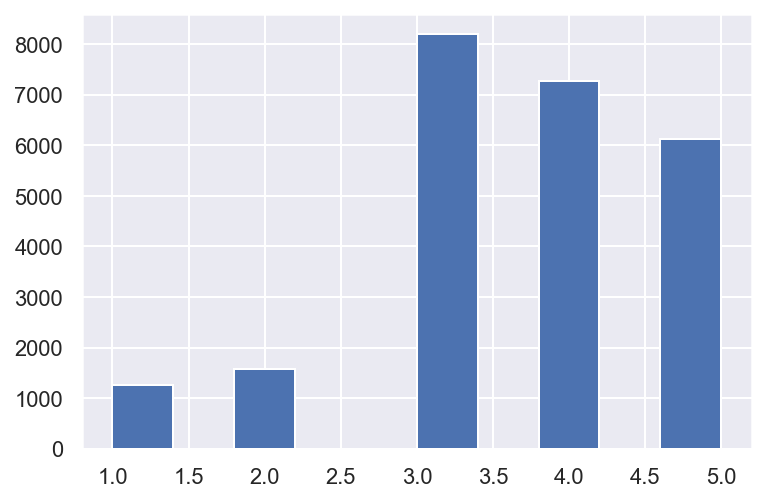

In [269]:
df['education-cat'].hist()

In [270]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["education-cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [271]:
strat_test_set['education-cat'].value_counts() / len(strat_test_set)

3    0.335517
4    0.298055
5    0.250358
2    0.064278
1    0.051791
Name: education-cat, dtype: float64

In [272]:
df['education-cat'].value_counts() / len(df)

3    0.335531
4    0.298063
5    0.250481
2    0.064207
1    0.051718
Name: education-cat, dtype: float64

In [273]:
def education_cat_proportions(data):
    return data['education-cat'].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

compare_props = pd.DataFrame({
    "Overall": education_cat_proportions(df),
    "Stratified": education_cat_proportions(strat_test_set),
    "Random": education_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [274]:
compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.051718    0.051791  0.053634      3.704312       0.141951
2  0.064207    0.064278  0.065097      1.386455       0.111153
3  0.335531    0.335517  0.339202      1.094010      -0.004175
4  0.298063    0.298055  0.303173      1.714347      -0.002641
5  0.250481    0.250358  0.238895     -4.625725      -0.049067

In [275]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('education-cat', axis=1, inplace=True)

In [276]:
X_train = strat_train_set.copy()

In [277]:
X_val = strat_test_set.copy()

#### Step 2: Removal of outliers using statistical analysis

We will ignore `capital gain` and `capital loss` for now, as we will feature engineer those later.

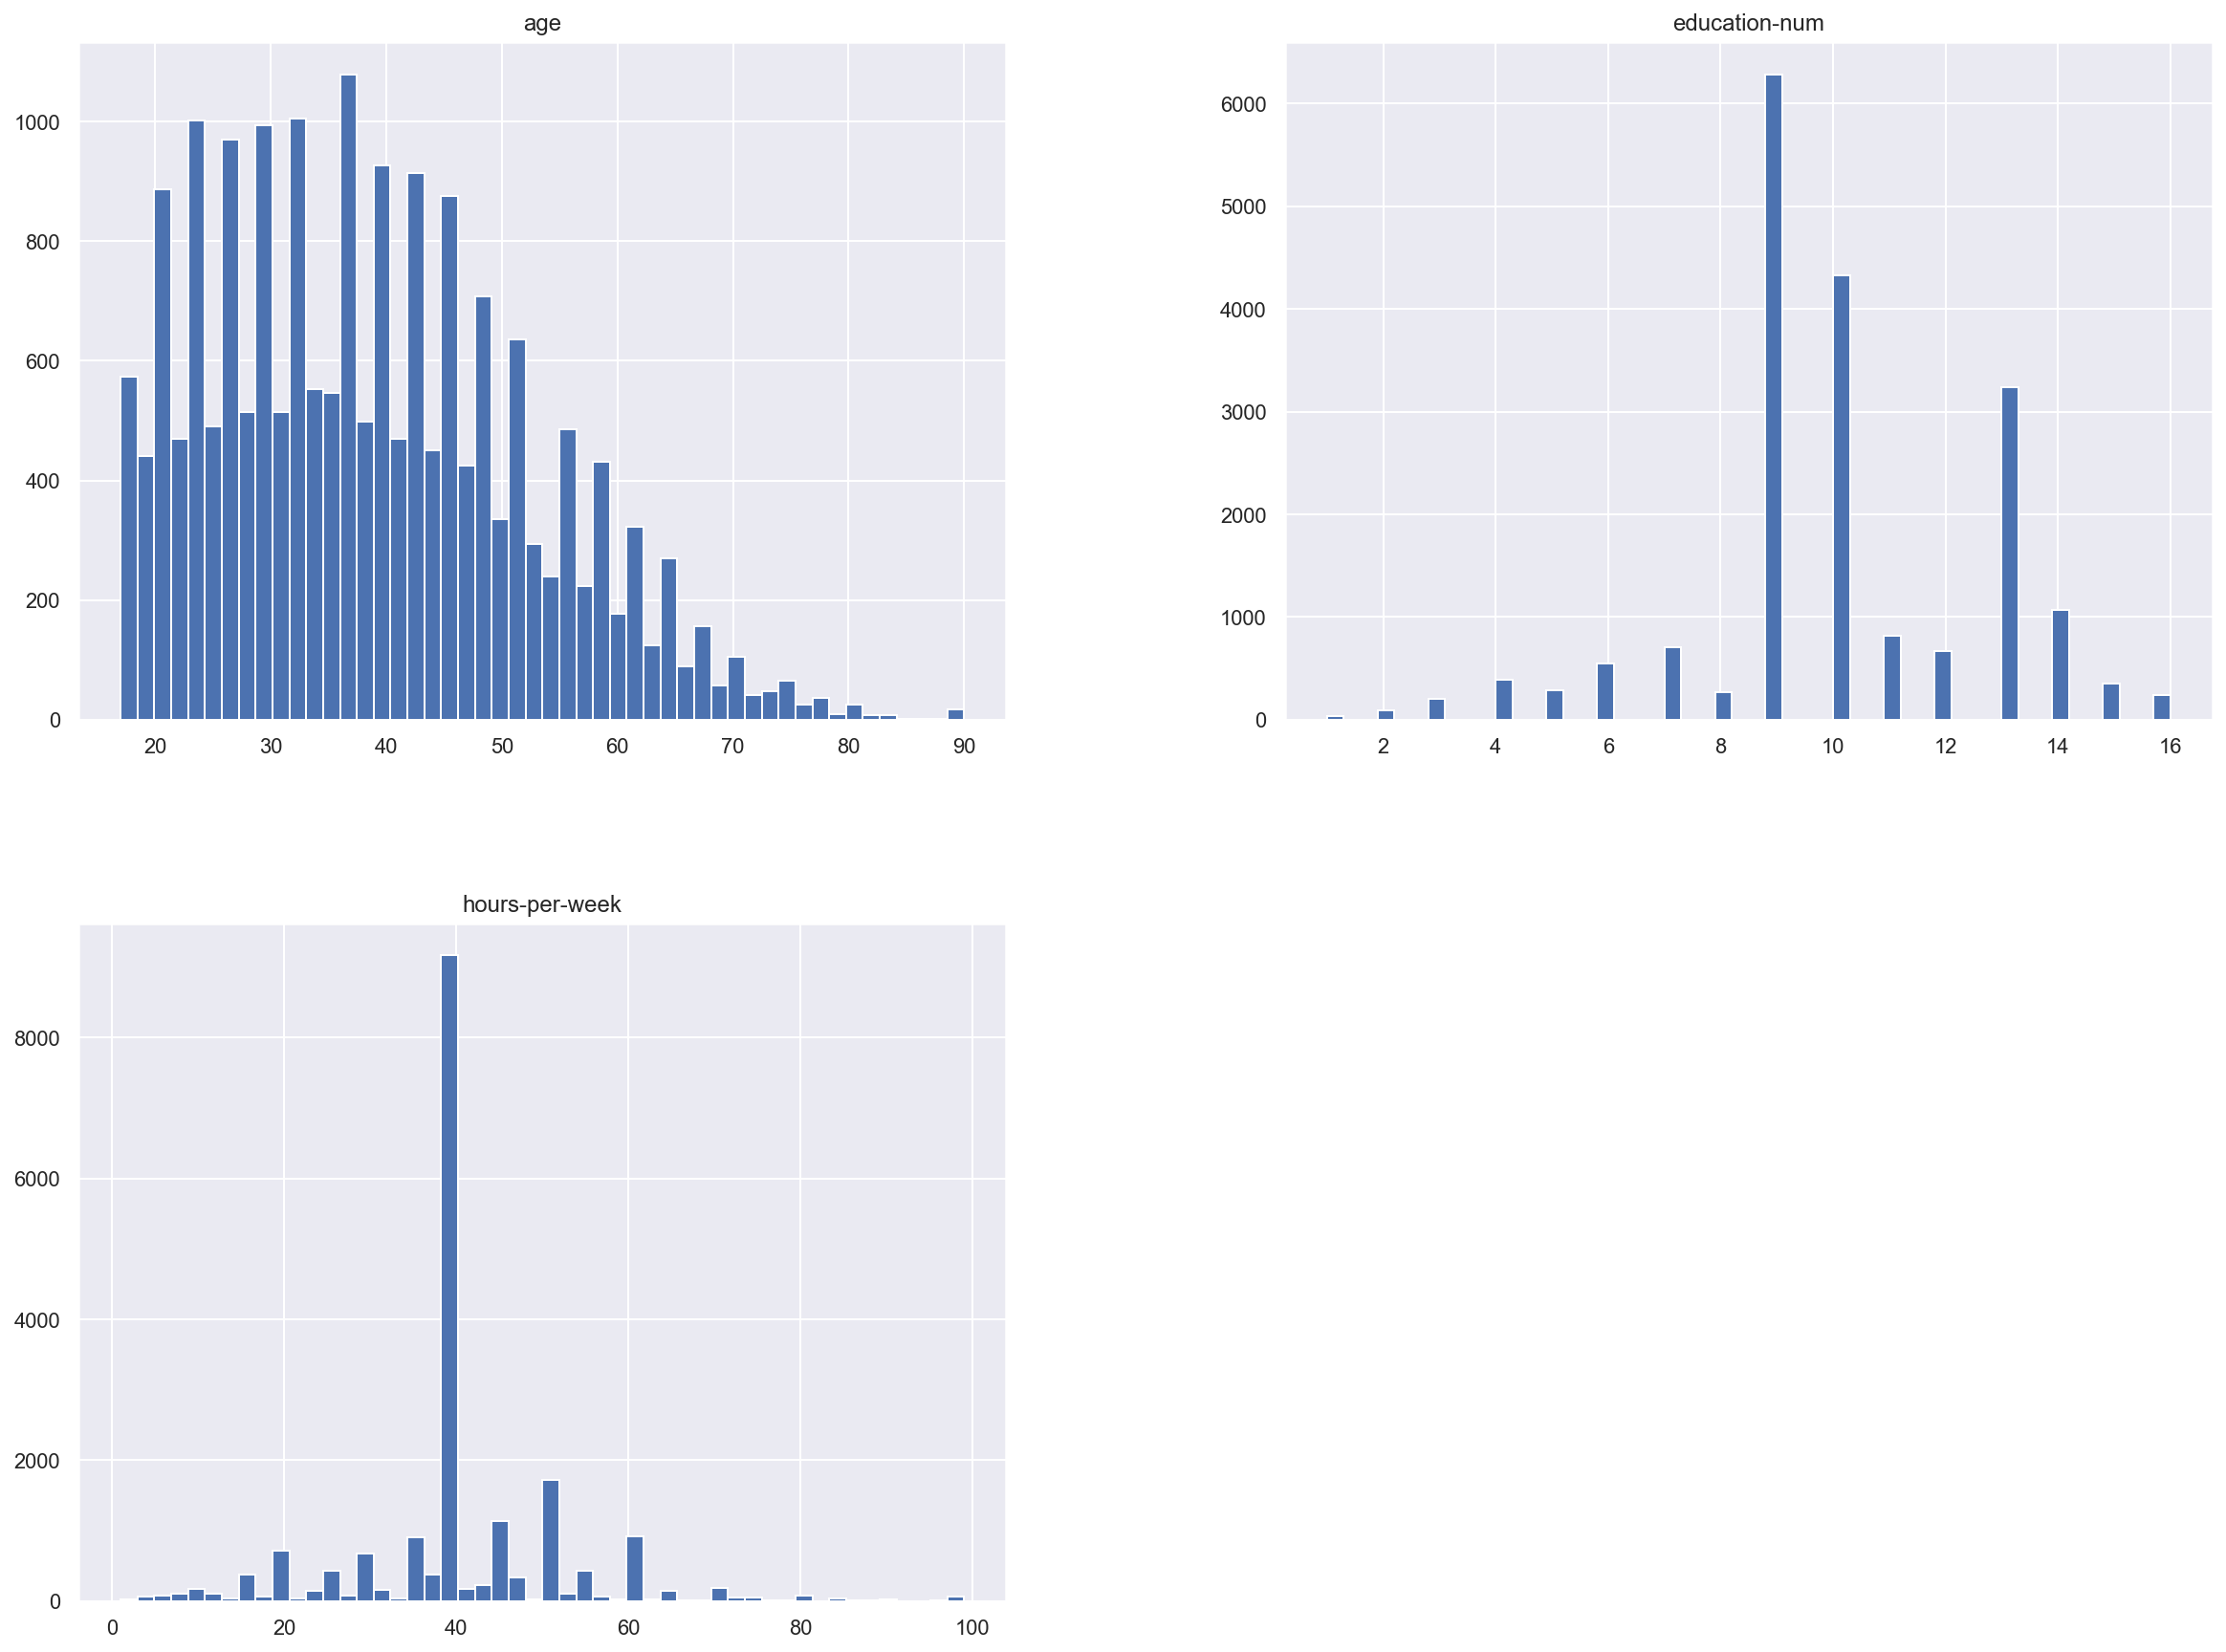

In [278]:
import matplotlib.pyplot as plt
numeric_cols_outliers = ['age', 'education-num', 'hours-per-week']
X_train[numeric_cols_outliers].hist(bins=50, figsize=(20,15))
plt.show()

In [216]:
# def remove_statistical_outliers(train_data, test_data, cols, threshold=3):
#     print(f'Current size of train_data: {train_data.shape}')
#     print(f'Current size of test_data: {test_data.shape}')
#     for col in cols:
#         train_std = train_data[col].std()
#         train_mean = train_data[col].mean()
        
#         cut_off = train_std * threshold
#         train_lower, train_upper = train_mean - cut_off, train_mean + cut_off
#         train_data = train_data[(train_data[col] < train_upper) & (train_data[col] > train_lower)]
#         test_data = test_data[(test_data[col] < train_upper) & (test_data[col] > train_lower)]
#         print('*' * 50)
#         print(f'Current size of train_data after removing outliers for {col}: {train_data.shape}')
#         print(f'Current size of test_data after removing outliers for {col}: {test_data.shape}')
#     return train_data, test_data
        

In [217]:
# X_train, X_val = remove_statistical_outliers(X_train, X_val, numeric_cols_outliers)

Current size of train_data: (19536, 14)
Current size of test_data: (4885, 14)
**************************************************
Current size of train_data after removing outliers for age: (19472, 14)
Current size of test_data after removing outliers for age: (4865, 14)
**************************************************
Current size of train_data after removing outliers for education-num: (19345, 14)
Current size of test_data after removing outliers for education-num: (4825, 14)
**************************************************
Current size of train_data after removing outliers for hours-per-week: (19090, 14)
Current size of test_data after removing outliers for hours-per-week: (4760, 14)


In [279]:
X_train

age          workclass  fnlwgt      education  education-num  \
17910   46            Private  191204      Assoc-voc             11   
23682   35            Private  454843   Some-college             10   
21792   36   Self-emp-not-inc  165855      Bachelors             13   
11950   62          Local-gov  206063   Some-college             10   
1949    44            Private  215304      Bachelors             13   
...    ...                ...     ...            ...            ...   
7899    33            Private  123253      Bachelors             13   
13944   37            Private   84306   Some-college             10   
255     52            Private  187356           10th              6   
14684   35            Private  115792      Bachelors             13   
1285    59   Self-emp-not-inc  198145    Prof-school             15   

            marital-status          occupation    relationship      sex  \
17910        Never-married     Exec-managerial       Own-child   Female   
23682   Married-civ-spouse        Craft-repair         Husband     Male   
21792   Married-civ-spouse               Sales         Husband     Male   
11950             Divorced       Other-service   Not-in-family     Male   
1949    Married-civ-spouse      Prof-specialty         Husband     Male   
...                    ...                 ...             ...      ...   
7899    Married-civ-spouse     Exec-managerial         Husband     Male   
13944   Married-civ-spouse       Other-service         Husband     Male   
255     Married-civ-spouse   Machine-op-inspct         Husband     Male   
14684   Married-civ-spouse      Prof-specialty         Husband     Male   
1285    Married-civ-spouse      Prof-specialty         Husband     Male   

       capital-gain  capital-loss  hours-per-week  native-country  class  
17910             0             0              40   United-States      0  
23682             0             0              40   United-States      1  
21792             0             0              40         Germany      0  
11950             0             0              45   United-States      0  
1949              0             0              45   United-States      1  
...             ...           ...             ...             ...    ...  
7899              0             0              55   United-States      1  
13944             0             0              40   United-States      0  
255               0             0              41   United-States      0  
14684             0             0              55   United-States      0  
1285              0             0              35   United-States      1  

[19536 rows x 14 columns]

#### Step 3: Handling missing values and duplicated values:
We first deal with duplicated rows.

We can see 20 non-unique rows, which effectively translates to 10 duplicated rows.

In [280]:
X_train[X_train.duplicated(subset = list(set(X_train.columns) - set(['class'])), keep = False)].sort_values(by = list(X_train.columns))

age workclass  fnlwgt      education  education-num  \
22391   17   Private  153021           12th              8   
22798   17   Private  153021           12th              8   
13105   19   Private  251579   Some-college             10   
21624   19   Private  251579   Some-college             10   
18217   23   Private  239539        HS-grad              9   
720     23   Private  239539        HS-grad              9   
1863    25   Private  195994        1st-4th              2   
20513   25   Private  195994        1st-4th              2   
22605   25   Private  308144      Bachelors             13   
15139   25   Private  308144      Bachelors             13   
16412   41   Private  116391      Bachelors             13   
3298    41   Private  116391      Bachelors             13   
7630    41   Private  242804        HS-grad              9   
9017    41   Private  242804        HS-grad              9   
3697    44   Private  367749      Bachelors             13   
13695   44   Private  367749      Bachelors             13   
12374   46   Private  133616   Some-college             10   
23081   46   Private  133616   Some-college             10   
4734    46   Private  235646        HS-grad              9   
9306    46   Private  235646        HS-grad              9   
17364   49   Private   31267        7th-8th              4   
17139   49   Private   31267        7th-8th              4   

            marital-status          occupation    relationship      sex  \
22391        Never-married               Sales       Own-child   Female   
22798        Never-married               Sales       Own-child   Female   
13105        Never-married       Other-service       Own-child     Male   
21624        Never-married       Other-service       Own-child     Male   
18217        Never-married   Machine-op-inspct       Own-child     Male   
720          Never-married   Machine-op-inspct       Own-child     Male   
1863         Never-married     Priv-house-serv   Not-in-family   Female   
20513        Never-married     Priv-house-serv   Not-in-family   Female   
22605        Never-married        Craft-repair   Not-in-family     Male   
15139        Never-married        Craft-repair   Not-in-family     Male   
16412   Married-civ-spouse     Exec-managerial         Husband     Male   
3298    Married-civ-spouse     Exec-managerial         Husband     Male   
7630    Married-civ-spouse    Transport-moving         Husband     Male   
9017    Married-civ-spouse    Transport-moving         Husband     Male   
3697         Never-married      Prof-specialty   Not-in-family   Female   
13695        Never-married      Prof-specialty   Not-in-family   Female   
12374             Divorced        Adm-clerical       Unmarried   Female   
23081             Divorced        Adm-clerical       Unmarried   Female   
4734    Married-civ-spouse        Craft-repair         Husband     Male   
9306    Married-civ-spouse        Craft-repair         Husband     Male   
17364   Married-civ-spouse        Craft-repair         Husband     Male   
17139   Married-civ-spouse        Craft-repair         Husband     Male   

       capital-gain  capital-loss  hours-per-week  native-country  class  
22391             0             0              20   United-States      0  
22798             0             0              20   United-States      0  
13105             0             0              14   United-States      0  
21624             0             0              14   United-States      0  
18217             0             0              40     Philippines      0  
720               0             0              40     Philippines      0  
1863              0             0              40       Guatemala      0  
20513             0             0              40       Guatemala      0  
22605             0             0              40          Mexico      0  
15139             0             0              40          Mexico      0  
16412             0          

We can proceed to drop the duplicated rows by simply doing the following:

In [281]:
X_train.drop_duplicates(subset = list(set(X_train.columns) - set(['class'])), keep='first',inplace=True)

We proceed to also clean for missing rows. Earlier on while we were doing our EDA, it was noteworthy to point out that some of the features: `native-country`, `occupation`, `workclass` had '?' to indicate they were missing. Let us take a look at some of these entries.

In [282]:
bool_mask = X_train.select_dtypes([np.object]).apply(lambda x: x.str.contains('\?'), axis = 1).any(axis = 1)

In [283]:
X_train[bool_mask] # we can see 1429 rows which have a question mark in them.

age workclass  fnlwgt      education  education-num  \
5931    43   Private  132633   Some-college             10   
23977   26   Private  147821      Bachelors             13   
4528    62         ?  176753        HS-grad              9   
23153   90         ?  225063   Some-college             10   
11196   38   Private  103408        Masters             14   
...    ...       ...     ...            ...            ...   
13624   74         ?  132112        HS-grad              9   
1100    17         ?  110998   Some-college             10   
18129   65         ?  195733   Some-college             10   
11164   20         ?  210781   Some-college             10   
5497    32   Private  245482        HS-grad              9   

            marital-status          occupation relationship      sex  \
5931    Married-civ-spouse   Handlers-cleaners         Wife   Female   
23977        Never-married               Sales    Own-child   Female   
4528    Married-civ-spouse                   ?      Husband     Male   
23153        Never-married                   ?    Own-child     Male   
11196   Married-civ-spouse     Exec-managerial      Husband     Male   
...                    ...                 ...          ...      ...   
13624   Married-civ-spouse                   ?      Husband     Male   
1100         Never-married                   ?    Own-child   Female   
18129   Married-civ-spouse                   ?      Husband     Male   
11164        Never-married                   ?    Own-child   Female   
5497    Married-civ-spouse   Machine-op-inspct      Husband     Male   

       capital-gain  capital-loss  hours-per-week  native-country  class  
5931              0             0              40               ?      0  
23977             0             0              45               ?      0  
4528              0             0              40   United-States      0  
23153             0             0              10           South      0  
11196             0             0              40               ?      0  
...             ...           ...             ...             ...    ...  
13624             0             0              48   United-States      0  
1100              0             0              40     Philippines      0  
18129             0             0              30   United-States      1  
11164             0             0              10   United-States      0  
5497              0             0              40               ?      0  

[1429 rows x 14 columns]

In [284]:
X_train = X_train.replace(to_replace='.*\?', value=np.nan, regex=True)
X_val = X_val.replace(to_replace='.*\?', value=np.nan, regex=True)

In [285]:
X_test = df_test.replace(to_replace='.*\?', value=np.nan, regex=True)

In [286]:
X_train.isnull().any() # We can see that we have missing values in the 3 columns as discussed.

age               False
workclass          True
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country     True
class             False
dtype: bool

In [287]:
y_train = X_train['class']
y_val = X_val['class']

In [288]:
X_train.drop('class', inplace=True, axis=1)
X_val.drop('class', inplace=True, axis=1)

#### Step 4: Feature Engineering
We note that in the earlier EDA, we have discussed that we want to remove some columns: `education`, `fnlwgt`. We also should consider doing some engineering on our capital-gain and capital-loss features to be one of the three values: 1 for capital gain, -1 for capital loss, and 0 for no gain/loss.


https://brendanhasz.github.io/2019/03/04/target-encoding.html#target-encoding
https://github.com/EpistasisLab/tpot/blob/master/tutorials/MAGIC%20Gamma%20Telescope/MAGIC%20Gamma%20Telescope.ipynb
https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb
https://www.kaggle.com/residentmario/encoding-categorical-data-in-sklearn

- Other encoders, CatBoost, JamesStein (not good only for normal)?
- Imputers?
- Engineer married variable, one hot encoding for 2 columns.
- ADASYN, with tree based models? not too sure if can work.


#### AttributesRemover:

In [289]:
X_train_copy = X_train.copy()

In [290]:
X_train_copy

age          workclass  fnlwgt      education  education-num  \
17910   46            Private  191204      Assoc-voc             11   
23682   35            Private  454843   Some-college             10   
21792   36   Self-emp-not-inc  165855      Bachelors             13   
11950   62          Local-gov  206063   Some-college             10   
1949    44            Private  215304      Bachelors             13   
...    ...                ...     ...            ...            ...   
7899    33            Private  123253      Bachelors             13   
13944   37            Private   84306   Some-college             10   
255     52            Private  187356           10th              6   
14684   35            Private  115792      Bachelors             13   
1285    59   Self-emp-not-inc  198145    Prof-school             15   

            marital-status          occupation    relationship      sex  \
17910        Never-married     Exec-managerial       Own-child   Female   
23682   Married-civ-spouse        Craft-repair         Husband     Male   
21792   Married-civ-spouse               Sales         Husband     Male   
11950             Divorced       Other-service   Not-in-family     Male   
1949    Married-civ-spouse      Prof-specialty         Husband     Male   
...                    ...                 ...             ...      ...   
7899    Married-civ-spouse     Exec-managerial         Husband     Male   
13944   Married-civ-spouse       Other-service         Husband     Male   
255     Married-civ-spouse   Machine-op-inspct         Husband     Male   
14684   Married-civ-spouse      Prof-specialty         Husband     Male   
1285    Married-civ-spouse      Prof-specialty         Husband     Male   

       capital-gain  capital-loss  hours-per-week  native-country  
17910             0             0              40   United-States  
23682             0             0              40   United-States  
21792             0             0              40         Germany  
11950             0             0              45   United-States  
1949              0             0              45   United-States  
...             ...           ...             ...             ...  
7899              0             0              55   United-States  
13944             0             0              40   United-States  
255               0             0              41   United-States  
14684             0             0              55   United-States  
1285              0             0              35   United-States  

[19525 rows x 13 columns]

#### AttributesAdder:

In [291]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['marital-status'] = X['marital-status'].map({' Never-married': 'Single', ' Divorced': 'Single',
                              ' Married-civ-spouse': 'Married', ' Married-spouse-absent': 'Married',
                              ' Married-AF-spouse': 'Married', ' Never-married': 'Single', ' Separated': 'Single'})
        X['capital'] = X['capital-gain'] - X['capital-loss']
        def mapper(x):
            if x['capital'] != 0:
                return 1
            else:
                return 0
        
        X['capital'] = X.apply(mapper, axis=1)
        X.drop(['capital-gain', 'capital-loss', 'education'], inplace=True,axis=1)
        return X

FE = FeatureEngineer()
testt = FE.transform(X_train_copy)

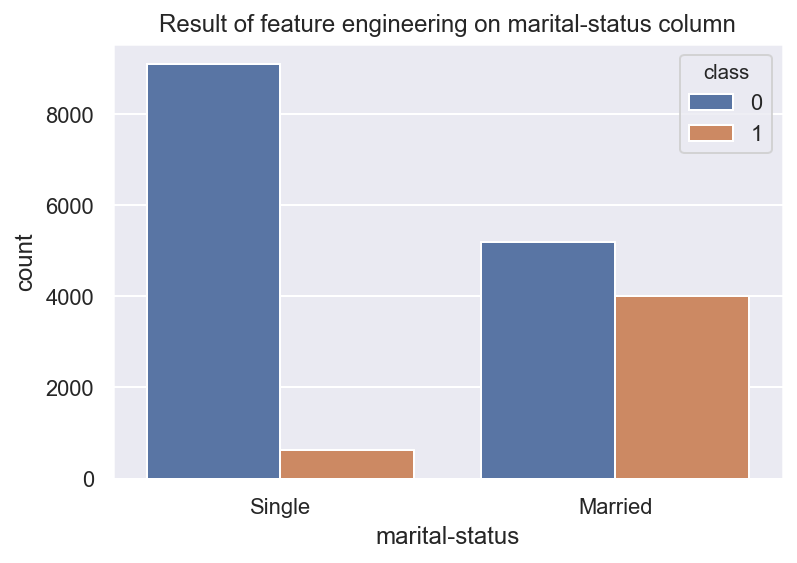

In [292]:
sns.countplot(testt['marital-status'], hue=y_train)
plt.title('Result of feature engineering on marital-status column')
plt.show() #

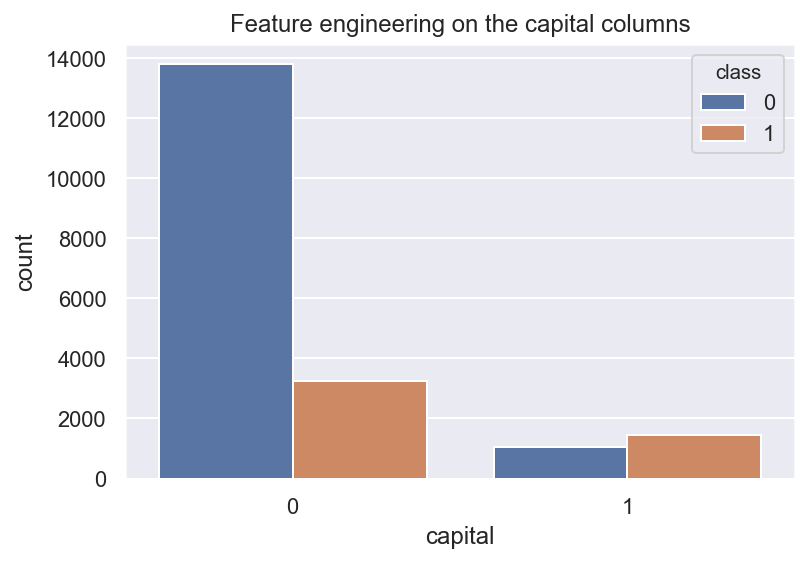

In [293]:
sns.countplot(testt['capital'], hue=y_train)
plt.title('Feature engineering on the capital columns')
plt.show()

In [294]:
class OneHotTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.cols = columns
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = pd.get_dummies(data=X, columns=self.cols)
        return X

# oht = OneHotTransformer(['sex', 'marital-status'])
# testtt = oht.transform(testt)

#### After feature engineering, what happens?

#### Imputer and the TargetEncoders:
For imputers, we can experiment with IterativeImputers, which we can check out.
https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

For categorical variable encoders, we consider using TargetEncoders:

In [295]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.
    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)
    
class TargetEncoderLOO(TargetEncoder):
    """Leave-one-out target encoder.
    """
    
    def __init__(self, cols=None):
        """Leave-one-out target encoding for categorical features.
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.
        """
        self.cols = cols
        

    def fit(self, X, y):
        """Fit leave-one-out target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to target encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.sum_count = dict()
        for col in self.cols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = \
                    (y[ix].sum(),ix.sum())
            
        # Return the fit object
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses leave-one-out target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        # Create output dataframe
        Xo = X.copy()

        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = sum_count[0]/sum_count[1]
                Xo[col] = vals

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    vals[ix] = (sum_count[0]-y[ix])/(sum_count[1]-1)
                Xo[col] = vals
            
        # Return encoded DataFrame
        return Xo
      
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)
    
class TargetEncoderCV(TargetEncoder):
    """Cross-fold target encoder.
    """
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-fold target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-fold splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.cols = cols
        

    def fit(self, X, y):
        """Fit cross-fold target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-fold target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix = []
        self._fit_tes = []
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:],
                                            y[train_ix]))
            else:
                raise TypeError('X must be DataFrame or ndarray')

        # Apply means across folds
        Xo = X.copy()
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = \
                    self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = \
                    self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X must be DataFrame or ndarray')
        return Xo

            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

### Tree-based Models and AutoML approach with processed numerical data with pipeline:
1. Feature Engineering
2. Categorical Encoding with OneHotEncoders and TargetEncoders
3. Normalisation
4. Imputation
5. ADASYN to balance class labels

In [296]:
final_cols = ['age',
            'workclass',
            'fnlwgt',
            'education-num',
            'occupation',
            'relationship',
            'hours-per-week',
            'native-country',
            'capital',
            'sex_ Female',
            'sex_ Male',
            'marital-status_Married',
            'marital-status_Single']

In [297]:
X_train_copy = X_train.copy()

In [298]:
pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('cat_onehot', OneHotTransformer(['sex', 'marital-status'])),
    ('cat_target', TargetEncoderCV()), # CatBoostEncoder?
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer()),
])

X_prepared = pipeline.fit_transform(X_train_copy, y_train)
X_val_prepared = pipeline.transform(X_val)
X_test_prepared = pipeline.transform(X_test)


#### Resampling technique to get balanced class labels.

In [299]:
X = pd.DataFrame(data=X_prepared, columns=final_cols)

In [300]:
ada = ADASYN()

In [301]:
X_train_resampled, y_train_resampled = ada.fit_sample(X, y_train)

##### TPOT

In [ ]:
with Espresso.shot(display_on = True):
    random_seeds = [21]
    winning_pipelines = []

    for seed in random_seeds:
        tpot = TPOTClassifier(cv=5, generations=20,
                              population_size=25,
                              scoring='f1',n_jobs=-1,
                              random_state=seed, verbosity=2)
        tpot.fit(X_train_resampled, y_train_resampled)
        current_pipe = tpot.fitted_pipeline_
        val_score = current_pipe.score(X_val_prepared, y_val)
        tpot.export(f'target_cv_adasyn_{val_score}.py')
#         current_pipe = tpot.fitted_pipeline_
        winning_pipelines.append(current_pipe)

        print(f'Current val score: {val_score}')
        print(f'Current pipe: {current_pipe}')

### XGBClassifier with Bayesian Hyperopt tuning

In [302]:
with Espresso.shot(display_on = False):   
    space = {'max_depth': hp.quniform('max_depth', 2, 10, 2),
            'learning_rate': hp.uniform('learning_rate', 0.001, 0.9),
            'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'reg_lambda': hp.uniform('reg_lambda', 0, 100),
            'subsample': hp.uniform('subsample', 0.5, 1.0)}

    def xgb_objective(params):
        params = {'max_depth': int(params['max_depth']), 'learning_rate': params['learning_rate'],
                 'min_child_weight': int(params['min_child_weight']),
                 'colsample_bytree': params['colsample_bytree'],
                 'reg_lambda': params['reg_lambda'],
                  'subsample': params['subsample'],
                 }
        xgb_clf = xgb.XGBClassifier(n_estimators=100, **params)
        best_score = cross_val_score(xgb_clf, X_train_resampled.values, y_train_resampled, scoring='f1', cv=10, n_jobs=-1, verbose=False).mean()
        loss = 1 - best_score
        return loss

    best = fmin(fn=xgb_objective,space=space, max_evals=100, rstate=np.random.RandomState(42), algo=tpe.suggest)
    print(best)

[espressomaker] Started on Fri, 08/May/2020 22:50:15 (display_on = False).
100%|██████████| 100/100 [16:20<00:00,  9.80s/trial, best loss: 0.1253208346255974]
{'colsample_bytree': 0.8983777837173029, 'learning_rate': 0.04928339953560307, 'max_depth': 10.0, 'min_child_weight': 2.0, 'reg_lambda': 1.5332006469399104, 'subsample': 0.5577984448813205}

[espressomaker] Finished on Fri, 08/May/2020 23:06:35.


In [314]:
best_xgb_model = xgb.XGBClassifier(
    learning_rate=best['learning_rate'],
    max_depth = int(best['max_depth']),
    min_child_weight= int(best['min_child_weight']),
    colsample_bytree=best['colsample_bytree'],
    reg_lambda=best['reg_lambda'],
    subsample=best['subsample'],
    n_estimators=100
)
best_xgb_model.fit(X_train_resampled.values, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8983777837173029, gamma=0,
              learning_rate=0.04928339953560307, max_delta_step=0, max_depth=10,
              min_child_weight=2, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1.5332006469399104, scale_pos_weight=1,
              seed=None, silent=True, subsample=0.5577984448813205)

In [312]:
X_train_resampled

age  workclass    fnlwgt  education-num  occupation  relationship  \
0      0.541395  -0.417699  0.023145       0.350253    1.545604     -1.160412   
1     -0.263738  -0.417699  2.551356      -0.038486   -0.156348      1.067729   
2     -0.190544   0.278369 -0.219943       1.127731    0.040785      1.074715   
3      1.712497   0.683877  0.165638      -0.038486   -1.362533     -0.688392   
4      0.395007  -0.417699  0.254256       1.127731    1.352156      1.067729   
...         ...        ...       ...            ...         ...           ...   
29652 -0.838536   0.645578  0.910103      -0.316683    0.848384      1.084387   
29653 -0.676161   0.633848  0.529203      -0.321315    1.578980      1.108728   
29654 -0.394274  -0.417699 -0.632616       1.127731    1.545604      1.067729   
29655 -0.302318  -0.426822 -0.683272       1.127731    1.474817      1.082826   
29656  1.492915   0.911116  0.456682       1.905210    1.559496      1.108728   

       hours-per-week  native-country   capital  sex_ Female  sex_ Male  \
0           -0.043520        0.095367 -0.383464     1.421798  -1.421798   
1           -0.043520        0.095367 -0.383464    -0.703335   0.703335   
2           -0.043520        0.949593 -0.383464    -0.703335   0.703335   
3            0.361998        0.095367 -0.383464    -0.703335   0.703335   
4            0.361998        0.095367 -0.383464    -0.703335   0.703335   
...               ...             ...       ...          ...        ...   
29652       -0.043520        0.043598 -0.383464    -0.703335   0.703335   
29653       -0.043520        0.130746 -0.383464    -0.703335   0.703335   
29654        1.173034        0.095367 -0.383464    -0.703335   0.703335   
29655        1.173034        0.108395 -0.383464    -0.703335   0.703335   
29656       -0.078541        0.130746 -0.383464    -0.703335   0.703335   

       marital-status_Married  marital-status_Single  
0                   -0.944241               1.004980  
1                    1.059052              -0.995044  
2                    1.059052              -0.995044  
3                   -0.944241               1.004980  
4                    1.059052              -0.995044  
...                       ...                    ...  
29652                1.059052              -0.995044  
29653                1.059052              -0.995044  
29654                1.059052              -0.995044  
29655                1.059052              -0.995044  
29656                1.059052              -0.995044  

[29657 rows x 13 columns]

In [313]:
X_val_prepared

array([[ 0.2486193 , -0.43642357,  0.01682584, ...,  0.70333465,
        -0.94424085,  1.00498039],
       [ 0.54139485,  0.38828995, -1.49565667, ...,  0.70333465,
        -0.94424085,  1.00498039],
       [ 0.46820096,  0.38828995, -0.44035201, ...,  0.70333465,
        -0.94424085,  1.00498039],
       ...,
       [ 0.46820096, -0.43642357, -1.00204767, ...,  0.70333465,
         1.05905183, -0.99504429],
       [ 0.46820096, -0.43642357,  0.82343204, ...,  0.70333465,
         1.05905183, -0.99504429],
       [ 0.17542541, -0.43642357, -0.42044386, ..., -1.42179829,
        -0.94424085,  1.00498039]])

In [316]:
val_pred = best_xgb_model.predict(X_val_prepared)

In [321]:
val_pred

array([1, 0, 1, ..., 1, 1, 1])

In [320]:
y_val

8864     0
22552    0
20391    0
1176     0
9893     0
        ..
15929    0
9501     0
19173    1
8334     0
20945    0
Name: class, Length: 4885, dtype: int64

In [325]:
f1_score(y_val, val_pred, average = 'weighted')

0.6839594095995255

### CatBoostClassifier with Bayesian Hyperopt Tuning

In [303]:
from catboost import CatBoostClassifier

In [ ]:
with Espresso.shot(display_on = False):   
    cat_space = {'max_depth': hp.quniform('max_depth', 2, 10, 2),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.8),
            'bagging_temperature': hp.uniform('bagging_temperature', 0, 100),
            'l2_leaf_reg': hp.qloguniform('l2_leaf_reg', 0, 2, 1),
            }
    
    def cb_objective(params):
        params = {'max_depth': int(params['max_depth']), 'learning_rate': params['learning_rate'],
                 'bagging_temperature': params['bagging_temperature'],
                 'l2_leaf_reg': int(params['l2_leaf_reg']),
                 }
        cb_clf = CatBoostClassifier(n_estimators=100, **params)
        best_score = cross_val_score(cb_clf, X_train_resampled.values, y_train_resampled, scoring='f1', cv=5, verbose=False).mean()
        loss = 1 - best_score
        return loss

    cat_best = fmin(fn=cb_objective,space=cat_space, max_evals=50, rstate=np.random.RandomState(42), algo=tpe.suggest)
    print(cat_best)
    

[espressomaker] Started on Fri, 08/May/2020 23:28:57 (display_on = False).
0:	learn: 0.6581038	total: 91.7ms	remaining: 9.08s    

1:	learn: 0.6336265	total: 168ms	remaining: 8.23s     

2:	learn: 0.5633649	total: 253ms	remaining: 8.17s     

3:	learn: 0.5615030	total: 348ms	remaining: 8.34s     

4:	learn: 0.5494044	total: 435ms	remaining: 8.26s     

5:	learn: 0.5458357	total: 542ms	remaining: 8.49s     

6:	learn: 0.5454431	total: 624ms	remaining: 8.29s     

7:	learn: 0.5402116	total: 705ms	remaining: 8.11s     

8:	learn: 0.4732556	total: 797ms	remaining: 8.05s     

9:	learn: 0.4728605	total: 882ms	remaining: 7.93s     

10:	learn: 0.4714160	total: 963ms	remaining: 7.79s    

11:	learn: 0.4659852	total: 1.05s	remaining: 7.73s    

12:	learn: 0.4654814	total: 1.14s	remaining: 7.64s    

13:	learn: 0.4635728	total: 1.22s	remaining: 7.49s    

14:	learn: 0.4614493	total: 1.29s	remaining: 7.3s     

15:	learn: 0.4490937	total: 1.37s	remaining: 7.18s    

16:	learn: 0.4453061	total: 1

44:	learn: 0.4300789	total: 2.86s	remaining: 3.49s    

45:	learn: 0.4288740	total: 2.92s	remaining: 3.43s    

46:	learn: 0.4280365	total: 2.96s	remaining: 3.34s    

47:	learn: 0.4276632	total: 3.03s	remaining: 3.28s    

48:	learn: 0.4276291	total: 3.1s	remaining: 3.22s     

49:	learn: 0.4242067	total: 3.2s	remaining: 3.2s      

50:	learn: 0.4191459	total: 3.28s	remaining: 3.15s    

51:	learn: 0.4186948	total: 3.33s	remaining: 3.07s    

52:	learn: 0.4186942	total: 3.4s	remaining: 3.02s     

53:	learn: 0.4183452	total: 3.45s	remaining: 2.94s    

54:	learn: 0.4177648	total: 3.5s	remaining: 2.86s     

55:	learn: 0.4170616	total: 3.56s	remaining: 2.8s     

56:	learn: 0.4169811	total: 3.6s	remaining: 2.72s     

57:	learn: 0.4055359	total: 3.65s	remaining: 2.65s    

58:	learn: 0.4050671	total: 3.69s	remaining: 2.56s    

59:	learn: 0.4012046	total: 3.73s	remaining: 2.48s    

60:	learn: 0.4009828	total: 3.76s	remaining: 2.4s     

61:	learn: 0.4008398	total: 3.82s	remaining: 2.3

90:	learn: 0.3911405	total: 5.38s	remaining: 532ms    

91:	learn: 0.3910521	total: 5.45s	remaining: 474ms    

92:	learn: 0.3906073	total: 5.52s	remaining: 416ms    

93:	learn: 0.3902820	total: 5.57s	remaining: 355ms    

94:	learn: 0.3902279	total: 5.62s	remaining: 296ms    

95:	learn: 0.3897066	total: 5.67s	remaining: 236ms    

96:	learn: 0.3896092	total: 5.72s	remaining: 177ms    

97:	learn: 0.3894887	total: 5.77s	remaining: 118ms    

98:	learn: 0.3894033	total: 5.81s	remaining: 58.7ms   

99:	learn: 0.3886714	total: 5.87s	remaining: 0us      

0:	learn: 0.6426547	total: 31.8ms	remaining: 3.15s    

1:	learn: 0.6077669	total: 87.7ms	remaining: 4.3s     

2:	learn: 0.5957755	total: 127ms	remaining: 4.1s      

3:	learn: 0.5872868	total: 179ms	remaining: 4.29s     

4:	learn: 0.5667611	total: 230ms	remaining: 4.37s     

5:	learn: 0.5525628	total: 276ms	remaining: 4.33s     

6:	learn: 0.5378887	total: 330ms	remaining: 4.39s     

7:	learn: 0.5377311	total: 376ms	remaining: 4.32

36:	learn: 0.4450508	total: 3.06s	remaining: 5.2s     

37:	learn: 0.4438500	total: 3.1s	remaining: 5.05s     

38:	learn: 0.4431442	total: 3.14s	remaining: 4.91s    

39:	learn: 0.4406956	total: 3.18s	remaining: 4.77s    

40:	learn: 0.4398301	total: 3.21s	remaining: 4.63s    

41:	learn: 0.4388198	total: 3.26s	remaining: 4.5s     

42:	learn: 0.4091243	total: 3.33s	remaining: 4.41s    

43:	learn: 0.4090371	total: 3.38s	remaining: 4.3s     

44:	learn: 0.4086976	total: 3.42s	remaining: 4.18s    

45:	learn: 0.4084237	total: 3.45s	remaining: 4.05s    

46:	learn: 0.4039570	total: 3.49s	remaining: 3.93s    

47:	learn: 0.4023743	total: 3.52s	remaining: 3.82s    

48:	learn: 0.4003211	total: 3.56s	remaining: 3.71s    

49:	learn: 0.3814198	total: 3.6s	remaining: 3.6s      

50:	learn: 0.3805400	total: 3.64s	remaining: 3.49s    

51:	learn: 0.3778823	total: 3.67s	remaining: 3.39s    

52:	learn: 0.3773275	total: 3.71s	remaining: 3.29s    

53:	learn: 0.3772524	total: 3.76s	remaining: 3.2

56:	learn: 0.3879565	total: 3.83s	remaining: 2.89s                              

57:	learn: 0.3875609	total: 4.01s	remaining: 2.91s                              

58:	learn: 0.3875546	total: 4.07s	remaining: 2.83s                              

59:	learn: 0.3874155	total: 4.11s	remaining: 2.74s                              

60:	learn: 0.3873624	total: 4.16s	remaining: 2.66s                              

61:	learn: 0.3866776	total: 4.2s	remaining: 2.58s                               

62:	learn: 0.3844806	total: 4.36s	remaining: 2.56s                              

63:	learn: 0.3821864	total: 4.41s	remaining: 2.48s                              

64:	learn: 0.3821481	total: 4.46s	remaining: 2.4s                               

65:	learn: 0.3820799	total: 4.5s	remaining: 2.32s                               

66:	learn: 0.3787247	total: 4.55s	remaining: 2.24s                              

67:	learn: 0.3692280	total: 4.6s	remaining: 2.17s                               

68:	learn: 0.369

55:	learn: 0.3650832	total: 3.38s	remaining: 2.66s                              

56:	learn: 0.3642736	total: 3.43s	remaining: 2.59s                              

57:	learn: 0.3604983	total: 3.48s	remaining: 2.52s                              

58:	learn: 0.3590787	total: 3.53s	remaining: 2.45s                              

59:	learn: 0.3586360	total: 3.57s	remaining: 2.38s                              

60:	learn: 0.3583957	total: 3.65s	remaining: 2.33s                              

61:	learn: 0.3540059	total: 3.71s	remaining: 2.27s                              

62:	learn: 0.3536451	total: 3.75s	remaining: 2.2s                               

63:	learn: 0.3535700	total: 3.8s	remaining: 2.14s                               

64:	learn: 0.3528902	total: 3.85s	remaining: 2.07s                              

65:	learn: 0.3522814	total: 3.89s	remaining: 2s                                 

66:	learn: 0.3522361	total: 3.94s	remaining: 1.94s                              

67:	learn: 0.352

54:	learn: 0.4252910	total: 2.58s	remaining: 2.11s                              

55:	learn: 0.4252735	total: 2.63s	remaining: 2.07s                              

56:	learn: 0.4247929	total: 2.67s	remaining: 2.01s                              

57:	learn: 0.4245726	total: 2.7s	remaining: 1.96s                               

58:	learn: 0.4245205	total: 2.75s	remaining: 1.91s                              

59:	learn: 0.4217586	total: 2.78s	remaining: 1.85s                              

60:	learn: 0.4202496	total: 2.82s	remaining: 1.8s                               

61:	learn: 0.4199622	total: 2.86s	remaining: 1.75s                              

62:	learn: 0.4173789	total: 2.91s	remaining: 1.71s                              

63:	learn: 0.4172600	total: 2.95s	remaining: 1.66s                              

64:	learn: 0.4166911	total: 3s	remaining: 1.61s                                 

65:	learn: 0.4156593	total: 3.04s	remaining: 1.57s                              

66:	learn: 0.415

53:	learn: 0.4249174	total: 2.66s	remaining: 2.26s                              

54:	learn: 0.4145023	total: 2.71s	remaining: 2.21s                              

55:	learn: 0.4142016	total: 2.75s	remaining: 2.16s                              

56:	learn: 0.4134634	total: 2.8s	remaining: 2.11s                               

57:	learn: 0.4131564	total: 2.84s	remaining: 2.06s                              

58:	learn: 0.4115391	total: 2.88s	remaining: 2s                                 

59:	learn: 0.4098910	total: 2.93s	remaining: 1.95s                              

60:	learn: 0.4095061	total: 2.97s	remaining: 1.9s                               

61:	learn: 0.4085052	total: 3.02s	remaining: 1.85s                              

62:	learn: 0.4083114	total: 3.06s	remaining: 1.8s                               

63:	learn: 0.4080839	total: 3.11s	remaining: 1.75s                              

64:	learn: 0.4075670	total: 3.15s	remaining: 1.7s                               

65:	learn: 0.407

52:	learn: 0.3905062	total: 2.72s	remaining: 2.42s                              

53:	learn: 0.3904213	total: 2.75s	remaining: 2.34s                              

54:	learn: 0.3900247	total: 2.79s	remaining: 2.28s                              

55:	learn: 0.3896759	total: 2.84s	remaining: 2.23s                              

56:	learn: 0.3889072	total: 2.89s	remaining: 2.18s                              

57:	learn: 0.3884063	total: 2.93s	remaining: 2.12s                              

58:	learn: 0.3882577	total: 2.99s	remaining: 2.08s                              

59:	learn: 0.3880517	total: 3.03s	remaining: 2.02s                              

60:	learn: 0.3874289	total: 3.08s	remaining: 1.97s                              

61:	learn: 0.3873452	total: 3.15s	remaining: 1.93s                              

62:	learn: 0.3869810	total: 3.21s	remaining: 1.89s                              

63:	learn: 0.3869564	total: 3.28s	remaining: 1.84s                              

64:	learn: 0.386

51:	learn: 0.6931470	total: 2.81s	remaining: 2.6s                                

52:	learn: 0.6931470	total: 2.87s	remaining: 2.55s                               

53:	learn: 0.6931470	total: 2.91s	remaining: 2.48s                               

54:	learn: 0.6931470	total: 2.96s	remaining: 2.42s                               

55:	learn: 0.6931470	total: 3s	remaining: 2.36s                                  

56:	learn: 0.6931470	total: 3.04s	remaining: 2.3s                                

57:	learn: 0.6931470	total: 3.08s	remaining: 2.23s                               

58:	learn: 0.6931470	total: 3.12s	remaining: 2.17s                               

59:	learn: 0.6931470	total: 3.17s	remaining: 2.11s                               

60:	learn: 0.6931470	total: 3.21s	remaining: 2.05s                               

61:	learn: 0.6931470	total: 3.25s	remaining: 1.99s                               

62:	learn: 0.6931470	total: 3.29s	remaining: 1.93s                               

63:	

49:	learn: 0.6931470	total: 2.19s	remaining: 2.19s                               

50:	learn: 0.6931470	total: 2.24s	remaining: 2.15s                               

51:	learn: 0.6931470	total: 2.28s	remaining: 2.1s                                

52:	learn: 0.6931470	total: 2.32s	remaining: 2.06s                               

53:	learn: 0.6931470	total: 2.36s	remaining: 2.01s                               

54:	learn: 0.6931470	total: 2.4s	remaining: 1.96s                                

55:	learn: 0.6931470	total: 2.44s	remaining: 1.92s                               

56:	learn: 0.6931470	total: 2.48s	remaining: 1.87s                               

57:	learn: 0.6931470	total: 2.52s	remaining: 1.82s                               

58:	learn: 0.6931470	total: 2.55s	remaining: 1.77s                               

59:	learn: 0.6931470	total: 2.59s	remaining: 1.73s                               

60:	learn: 0.6931470	total: 2.63s	remaining: 1.68s                               

61:	

47:	learn: 0.6931470	total: 2.17s	remaining: 2.35s                               

48:	learn: 0.6931470	total: 2.22s	remaining: 2.31s                               

49:	learn: 0.6931470	total: 2.26s	remaining: 2.26s                               

50:	learn: 0.6931470	total: 2.3s	remaining: 2.21s                                

51:	learn: 0.6931470	total: 2.34s	remaining: 2.16s                               

52:	learn: 0.6931470	total: 2.38s	remaining: 2.11s                               

53:	learn: 0.6931470	total: 2.42s	remaining: 2.06s                               

54:	learn: 0.6931470	total: 2.46s	remaining: 2.01s                               

55:	learn: 0.6931470	total: 2.5s	remaining: 1.96s                                

56:	learn: 0.6931470	total: 2.54s	remaining: 1.92s                               

57:	learn: 0.6931470	total: 2.58s	remaining: 1.87s                               

58:	learn: 0.6931470	total: 2.62s	remaining: 1.82s                               

59:	

45:	learn: 0.6931470	total: 2.08s	remaining: 2.44s                               

46:	learn: 0.6931470	total: 2.13s	remaining: 2.4s                                

47:	learn: 0.6931470	total: 2.17s	remaining: 2.35s                               

48:	learn: 0.6931470	total: 2.21s	remaining: 2.3s                                

49:	learn: 0.6931470	total: 2.25s	remaining: 2.25s                               

50:	learn: 0.6931470	total: 2.29s	remaining: 2.2s                                

51:	learn: 0.6931470	total: 2.33s	remaining: 2.15s                               

52:	learn: 0.6931470	total: 2.38s	remaining: 2.11s                               

53:	learn: 0.6931470	total: 2.42s	remaining: 2.06s                               

54:	learn: 0.6931470	total: 2.46s	remaining: 2.01s                               

55:	learn: 0.6931470	total: 2.5s	remaining: 1.96s                                

56:	learn: 0.6931470	total: 2.54s	remaining: 1.92s                               

57:	

43:	learn: 0.6931470	total: 1.97s	remaining: 2.51s                               

44:	learn: 0.6931470	total: 2.02s	remaining: 2.46s                               

45:	learn: 0.6931470	total: 2.06s	remaining: 2.41s                               

46:	learn: 0.6931470	total: 2.1s	remaining: 2.36s                                

47:	learn: 0.6931470	total: 2.13s	remaining: 2.31s                               

48:	learn: 0.6931470	total: 2.17s	remaining: 2.26s                               

49:	learn: 0.6931470	total: 2.21s	remaining: 2.21s                               

50:	learn: 0.6931470	total: 2.25s	remaining: 2.17s                               

51:	learn: 0.6931470	total: 2.28s	remaining: 2.11s                               

52:	learn: 0.6931470	total: 2.33s	remaining: 2.06s                               

53:	learn: 0.6931470	total: 2.37s	remaining: 2.02s                               

54:	learn: 0.6931470	total: 2.41s	remaining: 1.97s                               

55:	

41:	learn: 0.6931470	total: 1.9s	remaining: 2.62s                                

42:	learn: 0.6931470	total: 1.95s	remaining: 2.58s                               

43:	learn: 0.6931470	total: 1.98s	remaining: 2.52s                               

44:	learn: 0.6931470	total: 2.02s	remaining: 2.47s                               

45:	learn: 0.6931470	total: 2.06s	remaining: 2.42s                               

46:	learn: 0.6931470	total: 2.11s	remaining: 2.38s                               

47:	learn: 0.6931470	total: 2.15s	remaining: 2.33s                               

48:	learn: 0.6931470	total: 2.19s	remaining: 2.28s                               

49:	learn: 0.6931470	total: 2.23s	remaining: 2.23s                               

50:	learn: 0.6931470	total: 2.27s	remaining: 2.18s                               

51:	learn: 0.6931470	total: 2.31s	remaining: 2.14s                               

52:	learn: 0.6931470	total: 2.35s	remaining: 2.09s                               

53:	

39:	learn: 0.6931470	total: 1.81s	remaining: 2.71s                               

40:	learn: 0.6931470	total: 1.86s	remaining: 2.67s                               

41:	learn: 0.6931470	total: 1.95s	remaining: 2.7s                                

42:	learn: 0.6931470	total: 2.01s	remaining: 2.67s                               

43:	learn: 0.6931470	total: 2.05s	remaining: 2.61s                               

44:	learn: 0.6931470	total: 2.09s	remaining: 2.56s                               

45:	learn: 0.6931470	total: 2.12s	remaining: 2.49s                               

46:	learn: 0.6931470	total: 2.16s	remaining: 2.44s                               

47:	learn: 0.6931470	total: 2.21s	remaining: 2.39s                               

48:	learn: 0.6931470	total: 2.25s	remaining: 2.34s                               

49:	learn: 0.6931470	total: 2.29s	remaining: 2.29s                               

50:	learn: 0.6931470	total: 2.33s	remaining: 2.24s                               

51:	

37:	learn: 0.6931470	total: 565ms	remaining: 922ms                               

38:	learn: 0.6931470	total: 579ms	remaining: 906ms                               

39:	learn: 0.6931470	total: 593ms	remaining: 890ms                               

40:	learn: 0.6931470	total: 606ms	remaining: 872ms                               

41:	learn: 0.6931470	total: 619ms	remaining: 855ms                               

42:	learn: 0.6931470	total: 633ms	remaining: 839ms                               

43:	learn: 0.6931470	total: 647ms	remaining: 823ms                               

44:	learn: 0.6931470	total: 660ms	remaining: 807ms                               

45:	learn: 0.6931470	total: 673ms	remaining: 790ms                               

46:	learn: 0.6931470	total: 687ms	remaining: 775ms                               

47:	learn: 0.6931470	total: 702ms	remaining: 760ms                               

48:	learn: 0.6931470	total: 716ms	remaining: 745ms                               

49:	

35:	learn: 0.6931470	total: 570ms	remaining: 1.01s                               

36:	learn: 0.6931470	total: 584ms	remaining: 995ms                               

37:	learn: 0.6931470	total: 599ms	remaining: 978ms                               

38:	learn: 0.6931470	total: 614ms	remaining: 960ms                               

39:	learn: 0.6931470	total: 627ms	remaining: 940ms                               

40:	learn: 0.6931470	total: 641ms	remaining: 923ms                               

41:	learn: 0.6931470	total: 658ms	remaining: 908ms                               

42:	learn: 0.6931470	total: 672ms	remaining: 891ms                               

43:	learn: 0.6931470	total: 686ms	remaining: 873ms                               

44:	learn: 0.6931470	total: 699ms	remaining: 855ms                               

45:	learn: 0.6931470	total: 713ms	remaining: 837ms                               

46:	learn: 0.6931470	total: 726ms	remaining: 819ms                               

47:	

33:	learn: 0.6931470	total: 501ms	remaining: 973ms                               

34:	learn: 0.6931470	total: 515ms	remaining: 957ms                               

35:	learn: 0.6931470	total: 530ms	remaining: 942ms                               

36:	learn: 0.6931470	total: 569ms	remaining: 970ms                               

37:	learn: 0.6931470	total: 589ms	remaining: 962ms                               

38:	learn: 0.6931470	total: 604ms	remaining: 945ms                               

39:	learn: 0.6931470	total: 618ms	remaining: 928ms                               

40:	learn: 0.6931470	total: 632ms	remaining: 910ms                               

41:	learn: 0.6931470	total: 645ms	remaining: 891ms                               

42:	learn: 0.6931470	total: 660ms	remaining: 875ms                               

43:	learn: 0.6931470	total: 676ms	remaining: 860ms                               

44:	learn: 0.6931470	total: 690ms	remaining: 844ms                               

45:	

31:	learn: 0.6931470	total: 468ms	remaining: 995ms                               

32:	learn: 0.6931470	total: 482ms	remaining: 979ms                               

33:	learn: 0.6931470	total: 497ms	remaining: 965ms                               

34:	learn: 0.6931470	total: 513ms	remaining: 952ms                               

35:	learn: 0.6931470	total: 529ms	remaining: 940ms                               

36:	learn: 0.6931470	total: 543ms	remaining: 925ms                               

37:	learn: 0.6931470	total: 558ms	remaining: 910ms                               

38:	learn: 0.6931470	total: 572ms	remaining: 895ms                               

39:	learn: 0.6931470	total: 585ms	remaining: 877ms                               

40:	learn: 0.6931470	total: 598ms	remaining: 861ms                               

41:	learn: 0.6931470	total: 612ms	remaining: 845ms                               

42:	learn: 0.6931470	total: 639ms	remaining: 848ms                               

43:	

29:	learn: 0.6931470	total: 446ms	remaining: 1.04s                               

30:	learn: 0.6931470	total: 460ms	remaining: 1.02s                               

31:	learn: 0.6931470	total: 475ms	remaining: 1.01s                               

32:	learn: 0.6931470	total: 490ms	remaining: 995ms                               

33:	learn: 0.6931470	total: 504ms	remaining: 979ms                               

34:	learn: 0.6931470	total: 519ms	remaining: 964ms                               

35:	learn: 0.6931470	total: 535ms	remaining: 951ms                               

36:	learn: 0.6931470	total: 549ms	remaining: 936ms                               

37:	learn: 0.6931470	total: 567ms	remaining: 924ms                               

38:	learn: 0.6931470	total: 582ms	remaining: 910ms                               

39:	learn: 0.6931470	total: 596ms	remaining: 895ms                               

40:	learn: 0.6931470	total: 611ms	remaining: 879ms                               

41:	

27:	learn: 0.6931470	total: 509ms	remaining: 1.31s                               

28:	learn: 0.6931470	total: 523ms	remaining: 1.28s                               

29:	learn: 0.6931470	total: 537ms	remaining: 1.25s                               

30:	learn: 0.6931470	total: 552ms	remaining: 1.23s                               

31:	learn: 0.6931470	total: 567ms	remaining: 1.2s                                

32:	learn: 0.6931470	total: 582ms	remaining: 1.18s                               

33:	learn: 0.6931470	total: 597ms	remaining: 1.16s                               

34:	learn: 0.6931470	total: 612ms	remaining: 1.14s                               

35:	learn: 0.6931470	total: 626ms	remaining: 1.11s                               

36:	learn: 0.6931470	total: 641ms	remaining: 1.09s                               

37:	learn: 0.6931470	total: 656ms	remaining: 1.07s                               

38:	learn: 0.6931470	total: 671ms	remaining: 1.05s                               

39:	

25:	learn: 0.6931470	total: 421ms	remaining: 1.2s                                

26:	learn: 0.6931470	total: 436ms	remaining: 1.18s                               

27:	learn: 0.6931470	total: 451ms	remaining: 1.16s                               

28:	learn: 0.6931470	total: 465ms	remaining: 1.14s                               

29:	learn: 0.6931470	total: 480ms	remaining: 1.12s                               

30:	learn: 0.6931470	total: 494ms	remaining: 1.1s                                

31:	learn: 0.6931470	total: 509ms	remaining: 1.08s                               

32:	learn: 0.6931470	total: 523ms	remaining: 1.06s                               

33:	learn: 0.6931470	total: 538ms	remaining: 1.04s                               

34:	learn: 0.6931470	total: 553ms	remaining: 1.03s                               

35:	learn: 0.6931470	total: 567ms	remaining: 1.01s                               

36:	learn: 0.6931470	total: 582ms	remaining: 991ms                               

37:	

23:	learn: 0.6931470	total: 381ms	remaining: 1.21s                               

24:	learn: 0.6931470	total: 395ms	remaining: 1.18s                               

25:	learn: 0.6931470	total: 411ms	remaining: 1.17s                               

26:	learn: 0.6931470	total: 426ms	remaining: 1.15s                               

27:	learn: 0.6931470	total: 440ms	remaining: 1.13s                               

28:	learn: 0.6931470	total: 455ms	remaining: 1.11s                               

29:	learn: 0.6931470	total: 472ms	remaining: 1.1s                                

30:	learn: 0.6931470	total: 487ms	remaining: 1.08s                               

31:	learn: 0.6931470	total: 502ms	remaining: 1.07s                               

32:	learn: 0.6931470	total: 516ms	remaining: 1.05s                               

33:	learn: 0.6931470	total: 531ms	remaining: 1.03s                               

34:	learn: 0.6931470	total: 545ms	remaining: 1.01s                               

35:	

21:	learn: 0.6931470	total: 327ms	remaining: 1.16s                               

22:	learn: 0.6931470	total: 347ms	remaining: 1.16s                               

23:	learn: 0.6931470	total: 366ms	remaining: 1.16s                               

24:	learn: 0.6931470	total: 381ms	remaining: 1.14s                               

25:	learn: 0.6931470	total: 395ms	remaining: 1.12s                               

26:	learn: 0.6931470	total: 410ms	remaining: 1.11s                               

27:	learn: 0.6931470	total: 427ms	remaining: 1.1s                                

28:	learn: 0.6931470	total: 441ms	remaining: 1.08s                               

29:	learn: 0.6931470	total: 455ms	remaining: 1.06s                               

30:	learn: 0.6931470	total: 470ms	remaining: 1.04s                               

31:	learn: 0.6931470	total: 483ms	remaining: 1.03s                               

32:	learn: 0.6931470	total: 497ms	remaining: 1.01s                               

33:	

19:	learn: 0.6931470	total: 307ms	remaining: 1.23s                               

20:	learn: 0.6931470	total: 323ms	remaining: 1.21s                               

21:	learn: 0.6931470	total: 338ms	remaining: 1.2s                                

22:	learn: 0.6931470	total: 352ms	remaining: 1.18s                               

23:	learn: 0.6931470	total: 366ms	remaining: 1.16s                               

24:	learn: 0.6931470	total: 381ms	remaining: 1.14s                               

25:	learn: 0.6931470	total: 396ms	remaining: 1.13s                               

26:	learn: 0.6931470	total: 410ms	remaining: 1.11s                               

27:	learn: 0.6931470	total: 425ms	remaining: 1.09s                               

28:	learn: 0.6931470	total: 439ms	remaining: 1.07s                               

29:	learn: 0.6931470	total: 454ms	remaining: 1.06s                               

30:	learn: 0.6931470	total: 467ms	remaining: 1.04s                               

31:	

17:	learn: 0.6931470	total: 268ms	remaining: 1.22s                               

18:	learn: 0.6931470	total: 283ms	remaining: 1.21s                               

19:	learn: 0.6931470	total: 297ms	remaining: 1.19s                               

20:	learn: 0.6931470	total: 311ms	remaining: 1.17s                               

21:	learn: 0.6931470	total: 326ms	remaining: 1.16s                               

22:	learn: 0.6931470	total: 343ms	remaining: 1.15s                               

23:	learn: 0.6931470	total: 359ms	remaining: 1.14s                               

24:	learn: 0.6931470	total: 375ms	remaining: 1.13s                               

25:	learn: 0.6931470	total: 390ms	remaining: 1.11s                               

26:	learn: 0.6931470	total: 404ms	remaining: 1.09s                               

27:	learn: 0.6931470	total: 417ms	remaining: 1.07s                               

28:	learn: 0.6931470	total: 430ms	remaining: 1.05s                               

29:	

15:	learn: 0.6931470	total: 229ms	remaining: 1.2s                                

16:	learn: 0.6931470	total: 244ms	remaining: 1.19s                               

17:	learn: 0.6931470	total: 259ms	remaining: 1.18s                               

18:	learn: 0.6931470	total: 273ms	remaining: 1.16s                               

19:	learn: 0.6931470	total: 288ms	remaining: 1.15s                               

20:	learn: 0.6931470	total: 302ms	remaining: 1.14s                               

21:	learn: 0.6931470	total: 316ms	remaining: 1.12s                               

22:	learn: 0.6931470	total: 330ms	remaining: 1.11s                               

23:	learn: 0.6931470	total: 355ms	remaining: 1.12s                               

24:	learn: 0.6931470	total: 371ms	remaining: 1.11s                               

25:	learn: 0.6931470	total: 387ms	remaining: 1.1s                                

26:	learn: 0.6931470	total: 402ms	remaining: 1.08s                               

27:	

13:	learn: 0.6931470	total: 214ms	remaining: 1.31s                               

14:	learn: 0.6931470	total: 230ms	remaining: 1.3s                                

15:	learn: 0.6931470	total: 248ms	remaining: 1.3s                                

16:	learn: 0.6931470	total: 262ms	remaining: 1.28s                               

17:	learn: 0.6931470	total: 277ms	remaining: 1.26s                               

18:	learn: 0.6931470	total: 291ms	remaining: 1.24s                               

19:	learn: 0.6931470	total: 306ms	remaining: 1.22s                               

20:	learn: 0.6931470	total: 320ms	remaining: 1.2s                                

21:	learn: 0.6931470	total: 335ms	remaining: 1.19s                               

22:	learn: 0.6931470	total: 365ms	remaining: 1.22s                               

23:	learn: 0.6931470	total: 379ms	remaining: 1.2s                                

24:	learn: 0.6931470	total: 393ms	remaining: 1.18s                               

25:	

11:	learn: 0.4211214	total: 680ms	remaining: 4.99s                               

12:	learn: 0.4186281	total: 737ms	remaining: 4.93s                               

13:	learn: 0.4148382	total: 800ms	remaining: 4.92s                               

14:	learn: 0.4148317	total: 819ms	remaining: 4.64s                               

15:	learn: 0.4000761	total: 882ms	remaining: 4.63s                               

16:	learn: 0.3993812	total: 936ms	remaining: 4.57s                               

17:	learn: 0.3780104	total: 994ms	remaining: 4.53s                               

18:	learn: 0.3778879	total: 1.02s	remaining: 4.37s                               

19:	learn: 0.3761878	total: 1.08s	remaining: 4.32s                               

20:	learn: 0.3752883	total: 1.14s	remaining: 4.27s                               

21:	learn: 0.3750360	total: 1.19s	remaining: 4.21s                               

22:	learn: 0.3744893	total: 1.25s	remaining: 4.17s                               

23:	

9:	learn: 0.4277405	total: 574ms	remaining: 5.17s                                

10:	learn: 0.4274409	total: 599ms	remaining: 4.85s                               

11:	learn: 0.4256667	total: 655ms	remaining: 4.8s                                

12:	learn: 0.4253871	total: 679ms	remaining: 4.54s                               

13:	learn: 0.4248263	total: 732ms	remaining: 4.5s                                

14:	learn: 0.4246312	total: 785ms	remaining: 4.45s                               

15:	learn: 0.4236571	total: 839ms	remaining: 4.4s                                

16:	learn: 0.4207520	total: 894ms	remaining: 4.36s                               

17:	learn: 0.4196570	total: 948ms	remaining: 4.32s                               

18:	learn: 0.4179382	total: 1s	remaining: 4.28s                                  

19:	learn: 0.4165388	total: 1.06s	remaining: 4.26s                               

20:	learn: 0.4157047	total: 1.12s	remaining: 4.21s                               

21:	

7:	learn: 0.4336556	total: 453ms	remaining: 5.21s                                

8:	learn: 0.4332280	total: 505ms	remaining: 5.1s                                 

9:	learn: 0.4310882	total: 558ms	remaining: 5.02s                                

10:	learn: 0.4309049	total: 581ms	remaining: 4.7s                                

11:	learn: 0.4299106	total: 635ms	remaining: 4.66s                               

12:	learn: 0.4225705	total: 690ms	remaining: 4.62s                               

13:	learn: 0.4192435	total: 745ms	remaining: 4.58s                               

14:	learn: 0.4189432	total: 793ms	remaining: 4.5s                                

15:	learn: 0.4041641	total: 848ms	remaining: 4.45s                               

16:	learn: 0.4019373	total: 903ms	remaining: 4.41s                               

17:	learn: 0.3969011	total: 959ms	remaining: 4.37s                               

18:	learn: 0.3959011	total: 1.01s	remaining: 4.32s                               

19:	

5:	learn: 0.4714305	total: 344ms	remaining: 5.4s                                 

6:	learn: 0.4697919	total: 399ms	remaining: 5.31s                                

7:	learn: 0.4690050	total: 422ms	remaining: 4.86s                                

8:	learn: 0.4689969	total: 439ms	remaining: 4.44s                                

9:	learn: 0.4564683	total: 495ms	remaining: 4.45s                                

10:	learn: 0.4534833	total: 552ms	remaining: 4.47s                               

11:	learn: 0.4526763	total: 608ms	remaining: 4.46s                               

12:	learn: 0.4498304	total: 662ms	remaining: 4.43s                               

13:	learn: 0.4483366	total: 716ms	remaining: 4.4s                                

14:	learn: 0.4369267	total: 774ms	remaining: 4.39s                               

15:	learn: 0.4340946	total: 832ms	remaining: 4.37s                               

16:	learn: 0.4287645	total: 890ms	remaining: 4.34s                               

17:	

3:	learn: 0.5471551	total: 200ms	remaining: 4.79s                                

4:	learn: 0.5414066	total: 255ms	remaining: 4.85s                                

5:	learn: 0.5399956	total: 310ms	remaining: 4.85s                                

6:	learn: 0.5370716	total: 364ms	remaining: 4.83s                                

7:	learn: 0.5357030	total: 421ms	remaining: 4.84s                                

8:	learn: 0.5345207	total: 475ms	remaining: 4.81s                                

9:	learn: 0.5334457	total: 531ms	remaining: 4.78s                                

10:	learn: 0.5325687	total: 586ms	remaining: 4.74s                               

11:	learn: 0.5323951	total: 642ms	remaining: 4.71s                               

12:	learn: 0.5314454	total: 696ms	remaining: 4.66s                               

13:	learn: 0.5058044	total: 751ms	remaining: 4.62s                               

14:	learn: 0.4936945	total: 806ms	remaining: 4.57s                               

15:	

1:	learn: 0.6931470	total: 28.4ms	remaining: 1.39s                               

2:	learn: 0.6931470	total: 42.8ms	remaining: 1.39s                               

3:	learn: 0.6931470	total: 56.7ms	remaining: 1.36s                               

4:	learn: 0.6931470	total: 71.3ms	remaining: 1.35s                               

5:	learn: 0.6931470	total: 86ms	remaining: 1.35s                                 

6:	learn: 0.6931470	total: 101ms	remaining: 1.34s                                

7:	learn: 0.6931470	total: 116ms	remaining: 1.34s                                

8:	learn: 0.6931470	total: 131ms	remaining: 1.32s                                

9:	learn: 0.6931470	total: 144ms	remaining: 1.3s                                 

10:	learn: 0.6931470	total: 158ms	remaining: 1.28s                               

11:	learn: 0.6931470	total: 172ms	remaining: 1.26s                               

12:	learn: 0.6931470	total: 186ms	remaining: 1.25s                               

13:	

99:	learn: 0.6931470	total: 1.49s	remaining: 0us                                 

0:	learn: 0.6931470	total: 12.5ms	remaining: 1.24s                               

1:	learn: 0.6931470	total: 27.6ms	remaining: 1.35s                               

2:	learn: 0.6931470	total: 42.3ms	remaining: 1.37s                               

3:	learn: 0.6931470	total: 56.6ms	remaining: 1.36s                               

4:	learn: 0.6931470	total: 71.7ms	remaining: 1.36s                               

5:	learn: 0.6931470	total: 85.3ms	remaining: 1.33s                               

6:	learn: 0.6931470	total: 99.7ms	remaining: 1.32s                               

7:	learn: 0.6931470	total: 115ms	remaining: 1.32s                                

8:	learn: 0.6931470	total: 129ms	remaining: 1.3s                                 

9:	learn: 0.6931470	total: 142ms	remaining: 1.28s                                

10:	learn: 0.6931470	total: 165ms	remaining: 1.34s                               

11:	

97:	learn: 0.6931470	total: 1.43s	remaining: 29.2ms                              

98:	learn: 0.6931470	total: 1.44s	remaining: 14.6ms                              

99:	learn: 0.6931470	total: 1.46s	remaining: 0us                                 

0:	learn: 0.6931470	total: 12.8ms	remaining: 1.27s                               

1:	learn: 0.6931470	total: 28.6ms	remaining: 1.4s                                

2:	learn: 0.6931470	total: 43.8ms	remaining: 1.42s                               

3:	learn: 0.6931470	total: 59.8ms	remaining: 1.44s                               

4:	learn: 0.6931470	total: 74.9ms	remaining: 1.42s                               

5:	learn: 0.6931470	total: 90.5ms	remaining: 1.42s                               

6:	learn: 0.6931470	total: 105ms	remaining: 1.4s                                 

7:	learn: 0.6931470	total: 120ms	remaining: 1.38s                                

8:	learn: 0.6931470	total: 135ms	remaining: 1.37s                                

9:	l

95:	learn: 0.6931470	total: 1.39s	remaining: 57.9ms                              

96:	learn: 0.6931470	total: 1.4s	remaining: 43.4ms                               

97:	learn: 0.6931470	total: 1.42s	remaining: 28.9ms                              

98:	learn: 0.6931470	total: 1.43s	remaining: 14.5ms                              

99:	learn: 0.6931470	total: 1.44s	remaining: 0us                                 

0:	learn: 0.6931470	total: 13.4ms	remaining: 1.32s                               

1:	learn: 0.6931470	total: 29.1ms	remaining: 1.43s                               

2:	learn: 0.6931470	total: 44.9ms	remaining: 1.45s                               

3:	learn: 0.6931470	total: 60.4ms	remaining: 1.45s                               

4:	learn: 0.6931470	total: 75ms	remaining: 1.43s                                 

5:	learn: 0.6931470	total: 90.2ms	remaining: 1.41s                               

6:	learn: 0.6931470	total: 106ms	remaining: 1.41s                                

7:	l

93:	learn: 0.6931470	total: 1.78s	remaining: 114ms                               

94:	learn: 0.6931470	total: 1.79s	remaining: 94.4ms                              

95:	learn: 0.6931470	total: 1.81s	remaining: 75.4ms                              

96:	learn: 0.6931470	total: 1.82s	remaining: 56.4ms                              

97:	learn: 0.6931470	total: 1.85s	remaining: 37.8ms                              

98:	learn: 0.6931470	total: 1.86s	remaining: 18.8ms                              

99:	learn: 0.6931470	total: 1.88s	remaining: 0us                                 

0:	learn: 0.6931470	total: 16.1ms	remaining: 1.59s                               

1:	learn: 0.6931470	total: 35.1ms	remaining: 1.72s                               

2:	learn: 0.6931470	total: 49.9ms	remaining: 1.61s                               

3:	learn: 0.6931470	total: 76.7ms	remaining: 1.84s                               

4:	learn: 0.6931470	total: 92.5ms	remaining: 1.76s                               

5:	l

91:	learn: 0.6931470	total: 1.46s	remaining: 127ms                               

92:	learn: 0.6931470	total: 1.47s	remaining: 111ms                               

93:	learn: 0.6931470	total: 1.48s	remaining: 94.7ms                              

94:	learn: 0.6931470	total: 1.5s	remaining: 78.8ms                               

95:	learn: 0.6931470	total: 1.51s	remaining: 63.1ms                              

96:	learn: 0.6931470	total: 1.53s	remaining: 47.3ms                              

97:	learn: 0.6931470	total: 1.54s	remaining: 31.4ms                              

98:	learn: 0.6931470	total: 1.55s	remaining: 15.7ms                              

99:	learn: 0.6931470	total: 1.57s	remaining: 0us                                 

0:	learn: 0.6931470	total: 12.7ms	remaining: 1.26s                               

1:	learn: 0.6931470	total: 27.6ms	remaining: 1.35s                               

2:	learn: 0.6931470	total: 42.5ms	remaining: 1.37s                               

3:	l

89:	learn: 0.6931470	total: 1.33s	remaining: 148ms                               

90:	learn: 0.6931470	total: 1.35s	remaining: 133ms                               

91:	learn: 0.6931470	total: 1.36s	remaining: 119ms                               

92:	learn: 0.6931470	total: 1.38s	remaining: 104ms                               

93:	learn: 0.6931470	total: 1.39s	remaining: 88.9ms                              

94:	learn: 0.6931470	total: 1.41s	remaining: 74.1ms                              

95:	learn: 0.6931470	total: 1.42s	remaining: 59.3ms                              

96:	learn: 0.6931470	total: 1.44s	remaining: 44.5ms                              

97:	learn: 0.6931470	total: 1.45s	remaining: 29.7ms                              

98:	learn: 0.6931470	total: 1.47s	remaining: 14.8ms                              

99:	learn: 0.6931470	total: 1.48s	remaining: 0us                                 

0:	learn: 0.6931470	total: 12.4ms	remaining: 1.22s                               

1:	l

87:	learn: 0.6931470	total: 1.29s	remaining: 176ms                               

88:	learn: 0.6931470	total: 1.3s	remaining: 161ms                                

89:	learn: 0.6931470	total: 1.32s	remaining: 147ms                               

90:	learn: 0.6931470	total: 1.33s	remaining: 132ms                               

91:	learn: 0.6931470	total: 1.35s	remaining: 117ms                               

92:	learn: 0.6931470	total: 1.36s	remaining: 102ms                               

93:	learn: 0.6931470	total: 1.37s	remaining: 87.8ms                              

94:	learn: 0.6931470	total: 1.39s	remaining: 73.1ms                              

95:	learn: 0.6931470	total: 1.4s	remaining: 58.4ms                               

96:	learn: 0.6931470	total: 1.41s	remaining: 43.8ms                              

97:	learn: 0.6931470	total: 1.43s	remaining: 29.2ms                              

98:	learn: 0.6931470	total: 1.44s	remaining: 14.6ms                              

99:	

85:	learn: 0.6931470	total: 1.34s	remaining: 218ms                               

86:	learn: 0.6931470	total: 1.35s	remaining: 202ms                               

87:	learn: 0.6931470	total: 1.37s	remaining: 187ms                               

88:	learn: 0.6931470	total: 1.38s	remaining: 171ms                               

89:	learn: 0.6931470	total: 1.4s	remaining: 155ms                                

90:	learn: 0.6931470	total: 1.41s	remaining: 140ms                               

91:	learn: 0.6931470	total: 1.43s	remaining: 124ms                               

92:	learn: 0.6931470	total: 1.44s	remaining: 109ms                               

93:	learn: 0.6931470	total: 1.46s	remaining: 92.9ms                              

94:	learn: 0.6931470	total: 1.47s	remaining: 77.4ms                              

95:	learn: 0.6931470	total: 1.49s	remaining: 61.9ms                              

96:	learn: 0.6931470	total: 1.5s	remaining: 46.4ms                               

97:	

83:	learn: 0.6931470	total: 1.26s	remaining: 241ms                               

84:	learn: 0.6931470	total: 1.28s	remaining: 225ms                               

85:	learn: 0.6931470	total: 1.29s	remaining: 210ms                               

86:	learn: 0.6931470	total: 1.3s	remaining: 195ms                                

87:	learn: 0.6931470	total: 1.32s	remaining: 180ms                               

88:	learn: 0.6931470	total: 1.33s	remaining: 165ms                               

89:	learn: 0.6931470	total: 1.35s	remaining: 150ms                               

90:	learn: 0.6931470	total: 1.36s	remaining: 135ms                               

91:	learn: 0.6931470	total: 1.38s	remaining: 120ms                               

92:	learn: 0.6931470	total: 1.39s	remaining: 105ms                               

93:	learn: 0.6931470	total: 1.41s	remaining: 89.7ms                              

94:	learn: 0.6931470	total: 1.42s	remaining: 74.8ms                              

95:	

81:	learn: 0.6931470	total: 1.18s	remaining: 260ms                               

82:	learn: 0.6931470	total: 1.2s	remaining: 245ms                                

83:	learn: 0.6931470	total: 1.21s	remaining: 231ms                               

84:	learn: 0.6931470	total: 1.23s	remaining: 217ms                               

85:	learn: 0.6931470	total: 1.24s	remaining: 202ms                               

86:	learn: 0.6931470	total: 1.25s	remaining: 188ms                               

87:	learn: 0.6931470	total: 1.27s	remaining: 173ms                               

88:	learn: 0.6931470	total: 1.28s	remaining: 159ms                               

89:	learn: 0.6931470	total: 1.3s	remaining: 144ms                                

90:	learn: 0.6931470	total: 1.31s	remaining: 130ms                               

91:	learn: 0.6931470	total: 1.33s	remaining: 116ms                               

92:	learn: 0.6931470	total: 1.34s	remaining: 101ms                               

93:	

79:	learn: 0.6931470	total: 1.19s	remaining: 297ms                               

80:	learn: 0.6931470	total: 1.2s	remaining: 282ms                                

81:	learn: 0.6931470	total: 1.22s	remaining: 267ms                               

82:	learn: 0.6931470	total: 1.23s	remaining: 252ms                               

83:	learn: 0.6931470	total: 1.24s	remaining: 237ms                               

84:	learn: 0.6931470	total: 1.26s	remaining: 222ms                               

85:	learn: 0.6931470	total: 1.27s	remaining: 207ms                               

86:	learn: 0.6931470	total: 1.29s	remaining: 192ms                               

87:	learn: 0.6931470	total: 1.3s	remaining: 177ms                                

88:	learn: 0.5846114	total: 1.5s	remaining: 186ms                                

89:	learn: 0.5846114	total: 1.51s	remaining: 168ms                               

90:	learn: 0.5846114	total: 1.53s	remaining: 151ms                               

91:	

77:	learn: 0.6931470	total: 1.2s	remaining: 340ms                                

78:	learn: 0.6931470	total: 1.22s	remaining: 324ms                               

79:	learn: 0.6931470	total: 1.23s	remaining: 308ms                               

80:	learn: 0.6931470	total: 1.25s	remaining: 293ms                               

81:	learn: 0.6931470	total: 1.26s	remaining: 277ms                               

82:	learn: 0.6931470	total: 1.28s	remaining: 262ms                               

83:	learn: 0.6931470	total: 1.29s	remaining: 246ms                               

84:	learn: 0.6931470	total: 1.31s	remaining: 231ms                               

85:	learn: 0.6931470	total: 1.32s	remaining: 215ms                               

86:	learn: 0.6931470	total: 1.33s	remaining: 200ms                               

87:	learn: 0.6931470	total: 1.35s	remaining: 184ms                               

88:	learn: 0.6733252	total: 1.54s	remaining: 191ms                               

89:	

75:	learn: 0.5524620	total: 1.45s	remaining: 459ms                               

76:	learn: 0.5524620	total: 1.47s	remaining: 438ms                               

77:	learn: 0.5524620	total: 1.48s	remaining: 418ms                               

78:	learn: 0.5524620	total: 1.5s	remaining: 398ms                                

79:	learn: 0.5524620	total: 1.51s	remaining: 377ms                               

80:	learn: 0.5524620	total: 1.52s	remaining: 357ms                               

81:	learn: 0.5524620	total: 1.54s	remaining: 337ms                               

82:	learn: 0.5524620	total: 1.55s	remaining: 318ms                               

83:	learn: 0.5524620	total: 1.56s	remaining: 298ms                               

84:	learn: 0.5524620	total: 1.58s	remaining: 279ms                               

85:	learn: 0.5524620	total: 1.59s	remaining: 260ms                               

86:	learn: 0.5509337	total: 1.77s	remaining: 265ms                               

87:	

73:	learn: 0.5173264	total: 1.42s	remaining: 500ms                               

74:	learn: 0.5173264	total: 1.44s	remaining: 479ms                               

75:	learn: 0.5173264	total: 1.45s	remaining: 458ms                               

76:	learn: 0.5173264	total: 1.47s	remaining: 438ms                               

77:	learn: 0.5173264	total: 1.48s	remaining: 418ms                               

78:	learn: 0.5173264	total: 1.5s	remaining: 398ms                                

79:	learn: 0.5173264	total: 1.51s	remaining: 378ms                               

80:	learn: 0.5173264	total: 1.53s	remaining: 358ms                               

81:	learn: 0.5173264	total: 1.54s	remaining: 338ms                               

82:	learn: 0.5173264	total: 1.55s	remaining: 319ms                               

83:	learn: 0.5173264	total: 1.57s	remaining: 299ms                               

84:	learn: 0.5173264	total: 1.58s	remaining: 280ms                               

85:	

71:	learn: 0.5756918	total: 1.44s	remaining: 559ms                               

72:	learn: 0.5756918	total: 1.45s	remaining: 537ms                               

73:	learn: 0.5756918	total: 1.47s	remaining: 516ms                               

74:	learn: 0.5756918	total: 1.48s	remaining: 494ms                               

75:	learn: 0.5756918	total: 1.5s	remaining: 473ms                                

76:	learn: 0.5756918	total: 1.51s	remaining: 452ms                               

77:	learn: 0.5756918	total: 1.53s	remaining: 431ms                               

78:	learn: 0.5756918	total: 1.54s	remaining: 410ms                               

79:	learn: 0.5756918	total: 1.56s	remaining: 389ms                               

80:	learn: 0.5756918	total: 1.57s	remaining: 369ms                               

81:	learn: 0.5756918	total: 1.59s	remaining: 348ms                               

82:	learn: 0.5756918	total: 1.6s	remaining: 328ms                                

83:	

68:	learn: 0.4560900	total: 1.03s	remaining: 462ms                                

69:	learn: 0.4555642	total: 1.05s	remaining: 448ms                                

70:	learn: 0.4552237	total: 1.06s	remaining: 433ms                                

71:	learn: 0.4523669	total: 1.07s	remaining: 418ms                                

72:	learn: 0.4522958	total: 1.09s	remaining: 402ms                                

73:	learn: 0.4521970	total: 1.1s	remaining: 388ms                                 

74:	learn: 0.4520464	total: 1.12s	remaining: 373ms                                

75:	learn: 0.4519285	total: 1.13s	remaining: 358ms                                

76:	learn: 0.4518929	total: 1.15s	remaining: 343ms                                

77:	learn: 0.4395081	total: 1.16s	remaining: 328ms                                

78:	learn: 0.4386194	total: 1.18s	remaining: 313ms                                

79:	learn: 0.4384289	total: 1.19s	remaining: 298ms                          

65:	learn: 0.4322438	total: 993ms	remaining: 512ms                                

66:	learn: 0.4322414	total: 1.01s	remaining: 497ms                                

67:	learn: 0.4291605	total: 1.02s	remaining: 481ms                                

68:	learn: 0.4286761	total: 1.04s	remaining: 466ms                                

69:	learn: 0.4286355	total: 1.05s	remaining: 451ms                                

70:	learn: 0.4285086	total: 1.07s	remaining: 436ms                                

71:	learn: 0.4284092	total: 1.08s	remaining: 420ms                                

72:	learn: 0.4283689	total: 1.09s	remaining: 405ms                                

73:	learn: 0.4278519	total: 1.11s	remaining: 390ms                                

74:	learn: 0.4277694	total: 1.12s	remaining: 375ms                                

75:	learn: 0.4276296	total: 1.14s	remaining: 359ms                                

76:	learn: 0.4276101	total: 1.15s	remaining: 344ms                          

62:	learn: 0.4202555	total: 939ms	remaining: 552ms                                

63:	learn: 0.4197868	total: 955ms	remaining: 537ms                                

64:	learn: 0.4195301	total: 968ms	remaining: 521ms                                

65:	learn: 0.4195226	total: 983ms	remaining: 506ms                                

66:	learn: 0.4193800	total: 997ms	remaining: 491ms                                

67:	learn: 0.4187124	total: 1.01s	remaining: 476ms                                

68:	learn: 0.4186673	total: 1.03s	remaining: 461ms                                

69:	learn: 0.4186664	total: 1.04s	remaining: 446ms                                

70:	learn: 0.4186512	total: 1.06s	remaining: 431ms                                

71:	learn: 0.4186140	total: 1.07s	remaining: 417ms                                

72:	learn: 0.4184256	total: 1.1s	remaining: 406ms                                 

73:	learn: 0.4184144	total: 1.12s	remaining: 393ms                          

59:	learn: 0.4027066	total: 932ms	remaining: 621ms                                

60:	learn: 0.4026029	total: 946ms	remaining: 605ms                                

61:	learn: 0.4025992	total: 959ms	remaining: 588ms                                

62:	learn: 0.4024664	total: 973ms	remaining: 572ms                                

63:	learn: 0.4023895	total: 987ms	remaining: 555ms                                

64:	learn: 0.3994880	total: 1s	remaining: 539ms                                   

65:	learn: 0.3994847	total: 1.01s	remaining: 522ms                                

66:	learn: 0.3986501	total: 1.03s	remaining: 506ms                                

67:	learn: 0.3985996	total: 1.04s	remaining: 490ms                                

68:	learn: 0.3953985	total: 1.05s	remaining: 474ms                                

69:	learn: 0.3952236	total: 1.07s	remaining: 458ms                                

70:	learn: 0.3949930	total: 1.08s	remaining: 442ms                          

56:	learn: 0.4140450	total: 864ms	remaining: 652ms                                

57:	learn: 0.4135623	total: 878ms	remaining: 636ms                                

58:	learn: 0.4135141	total: 893ms	remaining: 620ms                                

59:	learn: 0.4134625	total: 908ms	remaining: 605ms                                

60:	learn: 0.4134335	total: 922ms	remaining: 589ms                                

61:	learn: 0.4134143	total: 936ms	remaining: 574ms                                

62:	learn: 0.4125329	total: 950ms	remaining: 558ms                                

63:	learn: 0.4125305	total: 964ms	remaining: 542ms                                

64:	learn: 0.4124894	total: 979ms	remaining: 527ms                                

65:	learn: 0.4124494	total: 993ms	remaining: 512ms                                

66:	learn: 0.4124006	total: 1.01s	remaining: 496ms                                

67:	learn: 0.4123712	total: 1.02s	remaining: 481ms                          

53:	learn: 0.6931470	total: 792ms	remaining: 674ms                                

54:	learn: 0.6931470	total: 806ms	remaining: 660ms                                

55:	learn: 0.6931470	total: 822ms	remaining: 646ms                                

56:	learn: 0.6931470	total: 835ms	remaining: 630ms                                

57:	learn: 0.6931470	total: 850ms	remaining: 615ms                                

58:	learn: 0.6931470	total: 864ms	remaining: 600ms                                

59:	learn: 0.6931470	total: 879ms	remaining: 586ms                                

60:	learn: 0.6931470	total: 895ms	remaining: 572ms                                

61:	learn: 0.6931470	total: 909ms	remaining: 557ms                                

62:	learn: 0.6931470	total: 924ms	remaining: 543ms                                

63:	learn: 0.6931470	total: 941ms	remaining: 530ms                                

64:	learn: 0.6931470	total: 962ms	remaining: 518ms                          

50:	learn: 0.6931470	total: 777ms	remaining: 747ms                                

51:	learn: 0.6931470	total: 792ms	remaining: 731ms                                

52:	learn: 0.6931470	total: 808ms	remaining: 716ms                                

53:	learn: 0.6931470	total: 822ms	remaining: 700ms                                

54:	learn: 0.6931470	total: 837ms	remaining: 684ms                                

55:	learn: 0.6931470	total: 851ms	remaining: 668ms                                

56:	learn: 0.6931470	total: 865ms	remaining: 652ms                                

57:	learn: 0.6931470	total: 881ms	remaining: 638ms                                

58:	learn: 0.6931470	total: 896ms	remaining: 622ms                                

59:	learn: 0.6931470	total: 910ms	remaining: 607ms                                

60:	learn: 0.6931470	total: 925ms	remaining: 592ms                                

61:	learn: 0.6931470	total: 940ms	remaining: 576ms                          

47:	learn: 0.6931470	total: 788ms	remaining: 854ms                                

48:	learn: 0.6931470	total: 801ms	remaining: 834ms                                

49:	learn: 0.6931470	total: 816ms	remaining: 816ms                                

50:	learn: 0.6931470	total: 830ms	remaining: 798ms                                

51:	learn: 0.6931470	total: 848ms	remaining: 783ms                                

52:	learn: 0.6931470	total: 864ms	remaining: 766ms                                

53:	learn: 0.6931470	total: 887ms	remaining: 756ms                                

54:	learn: 0.6931470	total: 904ms	remaining: 740ms                                

55:	learn: 0.6931470	total: 918ms	remaining: 722ms                                

56:	learn: 0.6931470	total: 933ms	remaining: 703ms                                

57:	learn: 0.6931470	total: 946ms	remaining: 685ms                                

58:	learn: 0.6931470	total: 960ms	remaining: 667ms                          

44:	learn: 0.6931470	total: 688ms	remaining: 840ms                                

45:	learn: 0.6931470	total: 702ms	remaining: 825ms                                

46:	learn: 0.6931470	total: 717ms	remaining: 809ms                                

47:	learn: 0.6931470	total: 732ms	remaining: 793ms                                

48:	learn: 0.6931470	total: 746ms	remaining: 777ms                                

49:	learn: 0.6931470	total: 761ms	remaining: 761ms                                

50:	learn: 0.6931470	total: 775ms	remaining: 745ms                                

51:	learn: 0.6931470	total: 791ms	remaining: 730ms                                

52:	learn: 0.6931470	total: 805ms	remaining: 714ms                                

53:	learn: 0.6931470	total: 819ms	remaining: 698ms                                

54:	learn: 0.6931470	total: 833ms	remaining: 682ms                                

55:	learn: 0.6931470	total: 847ms	remaining: 666ms                          

41:	learn: 0.6931470	total: 640ms	remaining: 884ms                                

42:	learn: 0.6931470	total: 656ms	remaining: 869ms                                

43:	learn: 0.6931470	total: 670ms	remaining: 853ms                                

44:	learn: 0.6931470	total: 684ms	remaining: 837ms                                

45:	learn: 0.6931470	total: 700ms	remaining: 821ms                                

46:	learn: 0.6931470	total: 714ms	remaining: 805ms                                

47:	learn: 0.6931470	total: 729ms	remaining: 789ms                                

48:	learn: 0.6931470	total: 743ms	remaining: 773ms                                

49:	learn: 0.6931470	total: 758ms	remaining: 758ms                                

50:	learn: 0.6931470	total: 773ms	remaining: 743ms                                

51:	learn: 0.6931470	total: 788ms	remaining: 728ms                                

52:	learn: 0.6931470	total: 803ms	remaining: 712ms                          

38:	learn: 0.3983256	total: 6.18s	remaining: 9.67s                                

39:	learn: 0.3978973	total: 6.37s	remaining: 9.55s                                

40:	learn: 0.3944521	total: 6.58s	remaining: 9.46s                                

41:	learn: 0.3938245	total: 6.77s	remaining: 9.35s                                

42:	learn: 0.3936911	total: 6.85s	remaining: 9.08s                                

43:	learn: 0.3935275	total: 7.04s	remaining: 8.96s                                

44:	learn: 0.3927254	total: 7.23s	remaining: 8.84s                                

45:	learn: 0.3924557	total: 7.42s	remaining: 8.72s                                

46:	learn: 0.3924315	total: 7.44s	remaining: 8.39s                                

47:	learn: 0.3914294	total: 7.65s	remaining: 8.28s                                

48:	learn: 0.3910483	total: 7.84s	remaining: 8.16s                                

49:	learn: 0.3902302	total: 8.03s	remaining: 8.03s                          

35:	learn: 0.4316707	total: 5.43s	remaining: 9.66s                                

36:	learn: 0.4258819	total: 5.62s	remaining: 9.58s                                

37:	learn: 0.4258764	total: 5.64s	remaining: 9.2s                                 

38:	learn: 0.4257043	total: 5.69s	remaining: 8.9s                                 

39:	learn: 0.4254634	total: 5.88s	remaining: 8.82s                                

40:	learn: 0.4246190	total: 6.11s	remaining: 8.79s                                

41:	learn: 0.4245715	total: 6.19s	remaining: 8.55s                                

42:	learn: 0.4242061	total: 6.35s	remaining: 8.42s                                

43:	learn: 0.4234563	total: 6.54s	remaining: 8.33s                                

44:	learn: 0.4233356	total: 6.74s	remaining: 8.24s                                

45:	learn: 0.4232194	total: 6.83s	remaining: 8.01s                                

46:	learn: 0.4197296	total: 7.02s	remaining: 7.91s                          

32:	learn: 0.4734835	total: 4.73s	remaining: 9.61s                                

33:	learn: 0.4729735	total: 4.92s	remaining: 9.55s                                

34:	learn: 0.4729677	total: 4.94s	remaining: 9.18s                                

35:	learn: 0.4720900	total: 5.14s	remaining: 9.13s                                

36:	learn: 0.4719624	total: 5.18s	remaining: 8.83s                                

37:	learn: 0.4701770	total: 5.37s	remaining: 8.76s                                

38:	learn: 0.4697644	total: 5.53s	remaining: 8.64s                                

39:	learn: 0.4646151	total: 5.72s	remaining: 8.58s                                

40:	learn: 0.4624151	total: 5.91s	remaining: 8.51s                                

41:	learn: 0.4594805	total: 6.11s	remaining: 8.44s                                

42:	learn: 0.4593198	total: 6.19s	remaining: 8.21s                                

43:	learn: 0.4590419	total: 6.38s	remaining: 8.12s                          

29:	learn: 0.4465365	total: 4.55s	remaining: 10.6s                                

30:	learn: 0.4463212	total: 4.74s	remaining: 10.6s                                

31:	learn: 0.4462638	total: 4.77s	remaining: 10.1s                                

32:	learn: 0.4462227	total: 4.81s	remaining: 9.77s                                

33:	learn: 0.4443338	total: 5s	remaining: 9.71s                                   

34:	learn: 0.4387134	total: 5.2s	remaining: 9.65s                                 

35:	learn: 0.4371039	total: 5.39s	remaining: 9.58s                                

36:	learn: 0.4341631	total: 5.58s	remaining: 9.5s                                 

37:	learn: 0.4341478	total: 5.6s	remaining: 9.14s                                 

38:	learn: 0.4341475	total: 5.62s	remaining: 8.78s                                

39:	learn: 0.4340163	total: 5.77s	remaining: 8.65s                                

40:	learn: 0.4339449	total: 5.96s	remaining: 8.57s                          

26:	learn: 0.4309154	total: 4.25s	remaining: 11.5s                                

27:	learn: 0.4162743	total: 4.44s	remaining: 11.4s                                

28:	learn: 0.4140593	total: 4.63s	remaining: 11.3s                                

29:	learn: 0.4140251	total: 4.65s	remaining: 10.9s                                

30:	learn: 0.4112619	total: 4.84s	remaining: 10.8s                                

31:	learn: 0.4104629	total: 5.04s	remaining: 10.7s                                

32:	learn: 0.4101772	total: 5.23s	remaining: 10.6s                                

33:	learn: 0.4077732	total: 5.42s	remaining: 10.5s                                

34:	learn: 0.4070551	total: 5.61s	remaining: 10.4s                                

35:	learn: 0.4037797	total: 5.8s	remaining: 10.3s                                 

36:	learn: 0.3980100	total: 6s	remaining: 10.2s                                   

37:	learn: 0.3976419	total: 6.2s	remaining: 10.1s                           

23:	learn: 0.6689165	total: 460ms	remaining: 1.46s                                

24:	learn: 0.6656374	total: 483ms	remaining: 1.45s                                

25:	learn: 0.6655871	total: 501ms	remaining: 1.43s                                

26:	learn: 0.6655871	total: 516ms	remaining: 1.39s                                

27:	learn: 0.6655871	total: 531ms	remaining: 1.36s                                

28:	learn: 0.6655871	total: 545ms	remaining: 1.33s                                

29:	learn: 0.6617893	total: 567ms	remaining: 1.32s                                

30:	learn: 0.6583210	total: 588ms	remaining: 1.31s                                

31:	learn: 0.6579562	total: 609ms	remaining: 1.29s                                

32:	learn: 0.6573787	total: 630ms	remaining: 1.28s                                

33:	learn: 0.6573787	total: 646ms	remaining: 1.25s                                

34:	learn: 0.6572919	total: 666ms	remaining: 1.24s                          

20:	learn: 0.6502104	total: 388ms	remaining: 1.46s                                

21:	learn: 0.6487052	total: 409ms	remaining: 1.45s                                

22:	learn: 0.6487052	total: 425ms	remaining: 1.42s                                

23:	learn: 0.6487052	total: 439ms	remaining: 1.39s                                

24:	learn: 0.6487052	total: 452ms	remaining: 1.36s                                

25:	learn: 0.6456204	total: 474ms	remaining: 1.35s                                

26:	learn: 0.6442479	total: 496ms	remaining: 1.34s                                

27:	learn: 0.6428899	total: 532ms	remaining: 1.37s                                

28:	learn: 0.6428696	total: 553ms	remaining: 1.35s                                

29:	learn: 0.6419621	total: 573ms	remaining: 1.34s                                

30:	learn: 0.6372923	total: 593ms	remaining: 1.32s                                

31:	learn: 0.6372922	total: 607ms	remaining: 1.29s                          

17:	learn: 0.6691286	total: 333ms	remaining: 1.51s                                

18:	learn: 0.6682282	total: 357ms	remaining: 1.52s                                

19:	learn: 0.6643196	total: 384ms	remaining: 1.53s                                

20:	learn: 0.6643196	total: 403ms	remaining: 1.51s                                

21:	learn: 0.6629212	total: 424ms	remaining: 1.5s                                 

22:	learn: 0.6620674	total: 446ms	remaining: 1.49s                                

23:	learn: 0.6598661	total: 466ms	remaining: 1.48s                                

24:	learn: 0.6547032	total: 488ms	remaining: 1.47s                                

25:	learn: 0.6546898	total: 507ms	remaining: 1.44s                                

26:	learn: 0.6520467	total: 529ms	remaining: 1.43s                                

27:	learn: 0.6503209	total: 549ms	remaining: 1.41s                                

28:	learn: 0.6503209	total: 566ms	remaining: 1.39s                          

14:	learn: 0.6671698	total: 275ms	remaining: 1.56s                                

15:	learn: 0.6644211	total: 295ms	remaining: 1.55s                                

16:	learn: 0.6643211	total: 314ms	remaining: 1.53s                                

17:	learn: 0.6643211	total: 328ms	remaining: 1.49s                                

18:	learn: 0.6618753	total: 350ms	remaining: 1.49s                                

19:	learn: 0.6556194	total: 376ms	remaining: 1.5s                                 

20:	learn: 0.6556193	total: 389ms	remaining: 1.46s                                

21:	learn: 0.6553304	total: 409ms	remaining: 1.45s                                

22:	learn: 0.6544332	total: 428ms	remaining: 1.43s                                

23:	learn: 0.6521180	total: 448ms	remaining: 1.42s                                

24:	learn: 0.6486423	total: 467ms	remaining: 1.4s                                 

25:	learn: 0.6485393	total: 486ms	remaining: 1.38s                          

11:	learn: 0.6687994	total: 227ms	remaining: 1.67s                                

12:	learn: 0.6687994	total: 241ms	remaining: 1.61s                                

13:	learn: 0.6624914	total: 262ms	remaining: 1.61s                                

14:	learn: 0.6624913	total: 276ms	remaining: 1.57s                                

15:	learn: 0.6624538	total: 297ms	remaining: 1.56s                                

16:	learn: 0.6624059	total: 316ms	remaining: 1.54s                                

17:	learn: 0.6624058	total: 331ms	remaining: 1.51s                                

18:	learn: 0.6623699	total: 358ms	remaining: 1.52s                                

19:	learn: 0.6614349	total: 377ms	remaining: 1.51s                                

20:	learn: 0.6614348	total: 393ms	remaining: 1.48s                                

21:	learn: 0.6577802	total: 412ms	remaining: 1.46s                                

22:	learn: 0.6553235	total: 433ms	remaining: 1.45s                          

8:	learn: 0.6931470	total: 133ms	remaining: 1.34s                                 

9:	learn: 0.6931470	total: 146ms	remaining: 1.31s                                 

10:	learn: 0.6931470	total: 161ms	remaining: 1.3s                                 

11:	learn: 0.6931470	total: 175ms	remaining: 1.28s                                

12:	learn: 0.6931470	total: 190ms	remaining: 1.27s                                

13:	learn: 0.6931470	total: 204ms	remaining: 1.25s                                

14:	learn: 0.6931470	total: 219ms	remaining: 1.24s                                

15:	learn: 0.6931470	total: 234ms	remaining: 1.23s                                

16:	learn: 0.6931470	total: 249ms	remaining: 1.22s                                

17:	learn: 0.6931470	total: 264ms	remaining: 1.2s                                 

18:	learn: 0.6931470	total: 279ms	remaining: 1.19s                                

19:	learn: 0.6931470	total: 293ms	remaining: 1.17s                          

5:	learn: 0.6931470	total: 99.1ms	remaining: 1.55s                                

6:	learn: 0.6931470	total: 114ms	remaining: 1.51s                                 

7:	learn: 0.6931470	total: 130ms	remaining: 1.5s                                  

8:	learn: 0.6931470	total: 145ms	remaining: 1.47s                                 

9:	learn: 0.6931470	total: 161ms	remaining: 1.45s                                 

10:	learn: 0.6931470	total: 176ms	remaining: 1.42s                                

11:	learn: 0.6931470	total: 191ms	remaining: 1.4s                                 

12:	learn: 0.6931470	total: 205ms	remaining: 1.37s                                

13:	learn: 0.6931470	total: 219ms	remaining: 1.35s                                

14:	learn: 0.6931470	total: 234ms	remaining: 1.33s                                

15:	learn: 0.6931470	total: 250ms	remaining: 1.31s                                

16:	learn: 0.6931470	total: 265ms	remaining: 1.29s                          

2:	learn: 0.6931470	total: 43.2ms	remaining: 1.4s                                 

3:	learn: 0.6931470	total: 57.7ms	remaining: 1.39s                                

4:	learn: 0.6931470	total: 71.9ms	remaining: 1.37s                                

5:	learn: 0.6931470	total: 86.6ms	remaining: 1.36s                                

6:	learn: 0.6931470	total: 101ms	remaining: 1.34s                                 

7:	learn: 0.6931470	total: 116ms	remaining: 1.34s                                 

8:	learn: 0.6931470	total: 131ms	remaining: 1.32s                                 

9:	learn: 0.6931470	total: 146ms	remaining: 1.31s                                 

10:	learn: 0.6931470	total: 161ms	remaining: 1.3s                                 

11:	learn: 0.6931470	total: 176ms	remaining: 1.29s                                

12:	learn: 0.6931470	total: 191ms	remaining: 1.28s                                

13:	learn: 0.6931470	total: 206ms	remaining: 1.27s                          

99:	learn: 0.6931470	total: 1.54s	remaining: 0us                                  

0:	learn: 0.6931470	total: 12.2ms	remaining: 1.21s                                

1:	learn: 0.6931470	total: 27ms	remaining: 1.32s                                  

2:	learn: 0.6931470	total: 40.4ms	remaining: 1.3s                                 

3:	learn: 0.6931470	total: 53.9ms	remaining: 1.29s                                

4:	learn: 0.6931470	total: 69.1ms	remaining: 1.31s                                

5:	learn: 0.6931470	total: 83.9ms	remaining: 1.31s                                

6:	learn: 0.6931470	total: 98.6ms	remaining: 1.31s                                

7:	learn: 0.6931470	total: 113ms	remaining: 1.3s                                  

8:	learn: 0.6931470	total: 128ms	remaining: 1.29s                                 

9:	learn: 0.6931470	total: 143ms	remaining: 1.28s                                 

10:	learn: 0.6931470	total: 157ms	remaining: 1.27s                          

96:	learn: 0.6931470	total: 1.42s	remaining: 44ms                                 

97:	learn: 0.6931470	total: 1.44s	remaining: 29.3ms                               

98:	learn: 0.6931470	total: 1.45s	remaining: 14.7ms                               

99:	learn: 0.6931470	total: 1.47s	remaining: 0us                                  

0:	learn: 0.6931470	total: 13.4ms	remaining: 1.33s                                

1:	learn: 0.6931470	total: 28.7ms	remaining: 1.41s                                

2:	learn: 0.6931470	total: 42.2ms	remaining: 1.36s                                

3:	learn: 0.6931470	total: 57.6ms	remaining: 1.38s                                

4:	learn: 0.6931470	total: 71.1ms	remaining: 1.35s                                

5:	learn: 0.6931470	total: 86.1ms	remaining: 1.35s                                

6:	learn: 0.6931470	total: 99.8ms	remaining: 1.33s                                

7:	learn: 0.6931470	total: 113ms	remaining: 1.3s                            

93:	learn: 0.6931470	total: 1.43s	remaining: 91.1ms                               

94:	learn: 0.6931470	total: 1.44s	remaining: 75.8ms                               

95:	learn: 0.6931470	total: 1.46s	remaining: 60.7ms                               

96:	learn: 0.6931470	total: 1.47s	remaining: 45.4ms                               

97:	learn: 0.6931470	total: 1.48s	remaining: 30.3ms                               

98:	learn: 0.6931470	total: 1.5s	remaining: 15.1ms                                

99:	learn: 0.6931470	total: 1.51s	remaining: 0us                                  

0:	learn: 0.6931470	total: 13.1ms	remaining: 1.29s                                

1:	learn: 0.6931470	total: 35.2ms	remaining: 1.72s                                

2:	learn: 0.6931470	total: 50ms	remaining: 1.61s                                  

3:	learn: 0.6931470	total: 66.1ms	remaining: 1.58s                                

4:	learn: 0.6931470	total: 80.8ms	remaining: 1.53s                          

90:	learn: 0.6931470	total: 1.35s	remaining: 134ms                                

91:	learn: 0.6931470	total: 1.36s	remaining: 119ms                                

92:	learn: 0.6931470	total: 1.38s	remaining: 104ms                                

93:	learn: 0.6931470	total: 1.39s	remaining: 89ms                                 

94:	learn: 0.6931470	total: 1.41s	remaining: 74.1ms                               

95:	learn: 0.6931470	total: 1.42s	remaining: 59.3ms                               

96:	learn: 0.6931470	total: 1.44s	remaining: 44.5ms                               

97:	learn: 0.6931470	total: 1.46s	remaining: 29.7ms                               

98:	learn: 0.6931470	total: 1.47s	remaining: 14.9ms                               

99:	learn: 0.6931470	total: 1.49s	remaining: 0us                                  

0:	learn: 0.6931470	total: 12.4ms	remaining: 1.23s                                

1:	learn: 0.6931470	total: 27.8ms	remaining: 1.36s                          

87:	learn: 0.6931470	total: 1.37s	remaining: 187ms                                

88:	learn: 0.6931470	total: 1.39s	remaining: 171ms                                

89:	learn: 0.6931470	total: 1.4s	remaining: 155ms                                 

90:	learn: 0.6931470	total: 1.41s	remaining: 140ms                                

91:	learn: 0.6931470	total: 1.43s	remaining: 124ms                                

92:	learn: 0.6931470	total: 1.44s	remaining: 108ms                                

93:	learn: 0.6931470	total: 1.45s	remaining: 92.8ms                               

94:	learn: 0.6931470	total: 1.47s	remaining: 77.3ms                               

95:	learn: 0.6931470	total: 1.48s	remaining: 61.8ms                               

96:	learn: 0.6931470	total: 1.5s	remaining: 46.4ms                                

97:	learn: 0.6931470	total: 1.51s	remaining: 30.9ms                               

98:	learn: 0.6931470	total: 1.53s	remaining: 15.4ms                         

84:	learn: 0.6931470	total: 1.29s	remaining: 227ms                                

85:	learn: 0.6931470	total: 1.3s	remaining: 212ms                                 

86:	learn: 0.6931470	total: 1.31s	remaining: 197ms                                

87:	learn: 0.6931470	total: 1.33s	remaining: 181ms                                

88:	learn: 0.6931470	total: 1.34s	remaining: 166ms                                

89:	learn: 0.6931470	total: 1.36s	remaining: 151ms                                

90:	learn: 0.6931470	total: 1.37s	remaining: 136ms                                

91:	learn: 0.6931470	total: 1.39s	remaining: 121ms                                

92:	learn: 0.6931470	total: 1.4s	remaining: 105ms                                 

93:	learn: 0.6931470	total: 1.42s	remaining: 90.3ms                               

94:	learn: 0.6931470	total: 1.43s	remaining: 75.3ms                               

95:	learn: 0.6931470	total: 1.44s	remaining: 60.2ms                         

81:	learn: 0.6931470	total: 1.22s	remaining: 267ms                                

82:	learn: 0.6931470	total: 1.23s	remaining: 252ms                                

83:	learn: 0.6931470	total: 1.24s	remaining: 237ms                                

84:	learn: 0.6931470	total: 1.25s	remaining: 221ms                                

85:	learn: 0.6931470	total: 1.27s	remaining: 206ms                                

86:	learn: 0.6931470	total: 1.28s	remaining: 192ms                                

87:	learn: 0.6931470	total: 1.3s	remaining: 177ms                                 

88:	learn: 0.6931470	total: 1.31s	remaining: 163ms                                

89:	learn: 0.6931470	total: 1.33s	remaining: 148ms                                

90:	learn: 0.6931470	total: 1.34s	remaining: 133ms                                

91:	learn: 0.6931470	total: 1.35s	remaining: 118ms                                

92:	learn: 0.6931470	total: 1.37s	remaining: 103ms                          

78:	learn: 0.6931470	total: 1.21s	remaining: 322ms                                

79:	learn: 0.6931470	total: 1.23s	remaining: 306ms                                

80:	learn: 0.6931470	total: 1.24s	remaining: 291ms                                

81:	learn: 0.6931470	total: 1.25s	remaining: 275ms                                

82:	learn: 0.6931470	total: 1.27s	remaining: 260ms                                

83:	learn: 0.6931470	total: 1.28s	remaining: 245ms                                

84:	learn: 0.6931470	total: 1.3s	remaining: 229ms                                 

85:	learn: 0.6931470	total: 1.31s	remaining: 214ms                                

86:	learn: 0.6931470	total: 1.33s	remaining: 198ms                                

87:	learn: 0.6931470	total: 1.34s	remaining: 183ms                                

88:	learn: 0.6931470	total: 1.36s	remaining: 168ms                                

89:	learn: 0.6931470	total: 1.37s	remaining: 153ms                          

75:	learn: 0.6931470	total: 1.13s	remaining: 358ms                                

76:	learn: 0.6931470	total: 1.15s	remaining: 342ms                                

77:	learn: 0.6931470	total: 1.16s	remaining: 327ms                                

78:	learn: 0.6931470	total: 1.17s	remaining: 312ms                                

79:	learn: 0.6931470	total: 1.19s	remaining: 297ms                                

80:	learn: 0.6931470	total: 1.2s	remaining: 282ms                                 

81:	learn: 0.6931470	total: 1.22s	remaining: 267ms                                

82:	learn: 0.6931470	total: 1.23s	remaining: 252ms                                

83:	learn: 0.6931470	total: 1.24s	remaining: 237ms                                

84:	learn: 0.6931470	total: 1.26s	remaining: 222ms                                

85:	learn: 0.6931470	total: 1.27s	remaining: 207ms                                

86:	learn: 0.6931470	total: 1.28s	remaining: 192ms                          

72:	learn: 0.6931470	total: 1.13s	remaining: 418ms                                

73:	learn: 0.6931470	total: 1.15s	remaining: 402ms                                

74:	learn: 0.6931470	total: 1.16s	remaining: 386ms                                

75:	learn: 0.6931470	total: 1.17s	remaining: 370ms                                

76:	learn: 0.6931470	total: 1.19s	remaining: 354ms                                

77:	learn: 0.6931470	total: 1.2s	remaining: 339ms                                 

78:	learn: 0.6931470	total: 1.22s	remaining: 323ms                                

79:	learn: 0.6931470	total: 1.23s	remaining: 307ms                                

80:	learn: 0.6931470	total: 1.24s	remaining: 292ms                                

81:	learn: 0.6931470	total: 1.26s	remaining: 276ms                                

82:	learn: 0.6931470	total: 1.27s	remaining: 261ms                                

83:	learn: 0.6931470	total: 1.29s	remaining: 245ms                          

69:	learn: 0.6931470	total: 1.03s	remaining: 440ms                                

70:	learn: 0.6931470	total: 1.04s	remaining: 425ms                                

71:	learn: 0.6931470	total: 1.05s	remaining: 410ms                                

72:	learn: 0.6931470	total: 1.07s	remaining: 395ms                                

73:	learn: 0.6931470	total: 1.08s	remaining: 380ms                                

74:	learn: 0.6931470	total: 1.1s	remaining: 366ms                                 

75:	learn: 0.6931470	total: 1.11s	remaining: 351ms                                

76:	learn: 0.6931470	total: 1.13s	remaining: 336ms                                

77:	learn: 0.6931470	total: 1.14s	remaining: 322ms                                

78:	learn: 0.6931470	total: 1.15s	remaining: 307ms                                

79:	learn: 0.6931470	total: 1.17s	remaining: 292ms                                

80:	learn: 0.6931470	total: 1.18s	remaining: 278ms                          

66:	learn: 0.6931470	total: 963ms	remaining: 474ms                                

67:	learn: 0.6931470	total: 977ms	remaining: 460ms                                

68:	learn: 0.6931470	total: 994ms	remaining: 446ms                                

69:	learn: 0.6931470	total: 1.01s	remaining: 432ms                                

70:	learn: 0.6931470	total: 1.02s	remaining: 418ms                                

71:	learn: 0.6931470	total: 1.04s	remaining: 404ms                                

72:	learn: 0.6931470	total: 1.05s	remaining: 390ms                                

73:	learn: 0.6931470	total: 1.07s	remaining: 376ms                                

74:	learn: 0.6931470	total: 1.08s	remaining: 362ms                                

75:	learn: 0.6931470	total: 1.11s	remaining: 350ms                                

76:	learn: 0.6931470	total: 1.12s	remaining: 335ms                                

77:	learn: 0.6931470	total: 1.13s	remaining: 320ms                          

63:	learn: 0.6931470	total: 932ms	remaining: 524ms                                

64:	learn: 0.6931470	total: 946ms	remaining: 510ms                                

65:	learn: 0.6931470	total: 960ms	remaining: 495ms                                

66:	learn: 0.6931470	total: 975ms	remaining: 480ms                                

67:	learn: 0.6931470	total: 987ms	remaining: 465ms                                

68:	learn: 0.6931470	total: 1s	remaining: 450ms                                   

69:	learn: 0.6931470	total: 1.01s	remaining: 435ms                                

70:	learn: 0.6931470	total: 1.03s	remaining: 420ms                                

71:	learn: 0.6931470	total: 1.04s	remaining: 406ms                                

72:	learn: 0.6931470	total: 1.06s	remaining: 391ms                                

73:	learn: 0.6931470	total: 1.07s	remaining: 377ms                                

74:	learn: 0.6931470	total: 1.09s	remaining: 362ms                          

60:	learn: 0.6931470	total: 999ms	remaining: 639ms                                

61:	learn: 0.6931470	total: 1.01s	remaining: 622ms                                

62:	learn: 0.6931470	total: 1.03s	remaining: 604ms                                

63:	learn: 0.6931470	total: 1.04s	remaining: 587ms                                

64:	learn: 0.6931470	total: 1.06s	remaining: 569ms                                

65:	learn: 0.6931470	total: 1.07s	remaining: 552ms                                

66:	learn: 0.6931470	total: 1.09s	remaining: 535ms                                

67:	learn: 0.6931470	total: 1.1s	remaining: 518ms                                 

68:	learn: 0.6931470	total: 1.12s	remaining: 502ms                                

69:	learn: 0.6931470	total: 1.14s	remaining: 488ms                                

70:	learn: 0.6931470	total: 1.15s	remaining: 472ms                                

71:	learn: 0.6931470	total: 1.17s	remaining: 454ms                          

57:	learn: 0.6931470	total: 893ms	remaining: 646ms                                

58:	learn: 0.6931470	total: 908ms	remaining: 631ms                                

59:	learn: 0.6931470	total: 922ms	remaining: 615ms                                

60:	learn: 0.6931470	total: 937ms	remaining: 599ms                                

61:	learn: 0.6931470	total: 954ms	remaining: 585ms                                

62:	learn: 0.6931470	total: 968ms	remaining: 569ms                                

63:	learn: 0.6931470	total: 987ms	remaining: 555ms                                

64:	learn: 0.6931470	total: 1s	remaining: 540ms                                   

65:	learn: 0.6931470	total: 1.01s	remaining: 523ms                                

66:	learn: 0.6931470	total: 1.03s	remaining: 508ms                                

67:	learn: 0.6931470	total: 1.05s	remaining: 492ms                                

68:	learn: 0.6931470	total: 1.06s	remaining: 477ms                          

54:	learn: 0.6931470	total: 831ms	remaining: 680ms                                

55:	learn: 0.6931470	total: 845ms	remaining: 664ms                                

56:	learn: 0.6931470	total: 859ms	remaining: 648ms                                

57:	learn: 0.6931470	total: 874ms	remaining: 633ms                                

58:	learn: 0.6931470	total: 888ms	remaining: 617ms                                

59:	learn: 0.6931470	total: 903ms	remaining: 602ms                                

60:	learn: 0.6931470	total: 917ms	remaining: 587ms                                

61:	learn: 0.6931470	total: 931ms	remaining: 571ms                                

62:	learn: 0.6931470	total: 944ms	remaining: 555ms                                

63:	learn: 0.6931470	total: 959ms	remaining: 539ms                                

64:	learn: 0.6931470	total: 975ms	remaining: 525ms                                

65:	learn: 0.6931470	total: 992ms	remaining: 511ms                          

51:	learn: 0.6931470	total: 781ms	remaining: 721ms                                

52:	learn: 0.6931470	total: 799ms	remaining: 708ms                                

53:	learn: 0.6931470	total: 813ms	remaining: 692ms                                

54:	learn: 0.6931470	total: 827ms	remaining: 676ms                                

55:	learn: 0.6931470	total: 840ms	remaining: 660ms                                

56:	learn: 0.6931470	total: 854ms	remaining: 644ms                                

57:	learn: 0.6931470	total: 867ms	remaining: 628ms                                

58:	learn: 0.6931470	total: 882ms	remaining: 613ms                                

59:	learn: 0.6931470	total: 896ms	remaining: 597ms                                

60:	learn: 0.6931470	total: 910ms	remaining: 582ms                                

61:	learn: 0.6931470	total: 924ms	remaining: 566ms                                

62:	learn: 0.6931470	total: 937ms	remaining: 550ms                          

48:	learn: 0.6931470	total: 732ms	remaining: 762ms                                

49:	learn: 0.6931470	total: 746ms	remaining: 746ms                                

50:	learn: 0.6931470	total: 760ms	remaining: 730ms                                

51:	learn: 0.6931470	total: 775ms	remaining: 716ms                                

52:	learn: 0.6931470	total: 790ms	remaining: 700ms                                

53:	learn: 0.6931470	total: 804ms	remaining: 685ms                                

54:	learn: 0.6931470	total: 819ms	remaining: 670ms                                

55:	learn: 0.6931470	total: 833ms	remaining: 655ms                                

56:	learn: 0.6931470	total: 847ms	remaining: 639ms                                

57:	learn: 0.6931470	total: 862ms	remaining: 624ms                                

58:	learn: 0.6931470	total: 876ms	remaining: 609ms                                

59:	learn: 0.6931470	total: 890ms	remaining: 593ms                          

45:	learn: 0.6931470	total: 681ms	remaining: 799ms                                

46:	learn: 0.6931470	total: 695ms	remaining: 784ms                                

47:	learn: 0.6931470	total: 710ms	remaining: 769ms                                

48:	learn: 0.6931470	total: 723ms	remaining: 753ms                                

49:	learn: 0.6931470	total: 738ms	remaining: 738ms                                

50:	learn: 0.6931470	total: 752ms	remaining: 723ms                                

51:	learn: 0.6931470	total: 766ms	remaining: 707ms                                

52:	learn: 0.6931470	total: 779ms	remaining: 691ms                                

53:	learn: 0.6931470	total: 792ms	remaining: 675ms                                

54:	learn: 0.6931470	total: 807ms	remaining: 660ms                                

55:	learn: 0.6931470	total: 821ms	remaining: 645ms                                

56:	learn: 0.6931470	total: 834ms	remaining: 629ms                          

42:	learn: 0.6931470	total: 646ms	remaining: 856ms                                

43:	learn: 0.6931470	total: 661ms	remaining: 841ms                                

44:	learn: 0.6931470	total: 676ms	remaining: 826ms                                

45:	learn: 0.6931470	total: 691ms	remaining: 812ms                                

46:	learn: 0.6931470	total: 707ms	remaining: 797ms                                

47:	learn: 0.6931470	total: 721ms	remaining: 781ms                                

48:	learn: 0.6931470	total: 735ms	remaining: 765ms                                

49:	learn: 0.6931470	total: 758ms	remaining: 758ms                                

50:	learn: 0.6931470	total: 774ms	remaining: 744ms                                

51:	learn: 0.6931470	total: 788ms	remaining: 728ms                                

52:	learn: 0.6931470	total: 801ms	remaining: 711ms                                

53:	learn: 0.6931470	total: 816ms	remaining: 695ms                          

39:	learn: 0.6931470	total: 620ms	remaining: 931ms                                

40:	learn: 0.6931470	total: 634ms	remaining: 912ms                                

41:	learn: 0.6931470	total: 648ms	remaining: 895ms                                

42:	learn: 0.6931470	total: 662ms	remaining: 878ms                                

43:	learn: 0.6931470	total: 676ms	remaining: 861ms                                

44:	learn: 0.6931470	total: 690ms	remaining: 844ms                                

45:	learn: 0.6931470	total: 704ms	remaining: 827ms                                

46:	learn: 0.6931470	total: 719ms	remaining: 811ms                                

47:	learn: 0.6931470	total: 734ms	remaining: 795ms                                

48:	learn: 0.6931470	total: 748ms	remaining: 778ms                                

49:	learn: 0.6931470	total: 762ms	remaining: 762ms                                

50:	learn: 0.6931470	total: 776ms	remaining: 745ms                          

36:	learn: 0.6931470	total: 848ms	remaining: 1.44s                                

37:	learn: 0.6931470	total: 862ms	remaining: 1.41s                                

38:	learn: 0.6931470	total: 883ms	remaining: 1.38s                                

39:	learn: 0.6931470	total: 899ms	remaining: 1.35s                                

40:	learn: 0.6931470	total: 913ms	remaining: 1.31s                                

41:	learn: 0.6931470	total: 928ms	remaining: 1.28s                                

42:	learn: 0.6931470	total: 942ms	remaining: 1.25s                                

43:	learn: 0.6931470	total: 956ms	remaining: 1.22s                                

44:	learn: 0.6931470	total: 971ms	remaining: 1.19s                                

45:	learn: 0.6931470	total: 985ms	remaining: 1.16s                                

46:	learn: 0.6931470	total: 999ms	remaining: 1.13s                                

47:	learn: 0.6931470	total: 1.01s	remaining: 1.1s                           

33:	learn: 0.6931470	total: 642ms	remaining: 1.25s                                

34:	learn: 0.6931470	total: 657ms	remaining: 1.22s                                

35:	learn: 0.6931470	total: 675ms	remaining: 1.2s                                 

36:	learn: 0.6931470	total: 690ms	remaining: 1.18s                                

37:	learn: 0.6931470	total: 706ms	remaining: 1.15s                                

38:	learn: 0.6931470	total: 721ms	remaining: 1.13s                                

39:	learn: 0.6931470	total: 735ms	remaining: 1.1s                                 

40:	learn: 0.6931470	total: 750ms	remaining: 1.08s                                

41:	learn: 0.6931470	total: 765ms	remaining: 1.06s                                

42:	learn: 0.6931470	total: 780ms	remaining: 1.03s                                

43:	learn: 0.6931470	total: 795ms	remaining: 1.01s                                

44:	learn: 0.6931470	total: 810ms	remaining: 989ms                          

30:	learn: 0.2146569	total: 2.11s	remaining: 4.69s                                

31:	learn: 0.2140786	total: 2.19s	remaining: 4.67s                                

32:	learn: 0.2140735	total: 2.3s	remaining: 4.67s                                 

33:	learn: 0.2116601	total: 2.36s	remaining: 4.58s                                

34:	learn: 0.2112196	total: 2.41s	remaining: 4.48s                                

35:	learn: 0.2108117	total: 2.48s	remaining: 4.4s                                 

36:	learn: 0.2104164	total: 2.53s	remaining: 4.3s                                 

37:	learn: 0.2098800	total: 2.58s	remaining: 4.21s                                

38:	learn: 0.2094471	total: 2.63s	remaining: 4.12s                                

39:	learn: 0.2094267	total: 2.69s	remaining: 4.04s                                

40:	learn: 0.2087816	total: 2.76s	remaining: 3.97s                                

41:	learn: 0.2083685	total: 2.82s	remaining: 3.89s                          

27:	learn: 0.2484521	total: 1.93s	remaining: 4.95s                                

28:	learn: 0.2481007	total: 1.99s	remaining: 4.86s                                

29:	learn: 0.2475104	total: 2.05s	remaining: 4.78s                                

30:	learn: 0.2472628	total: 2.1s	remaining: 4.68s                                 

31:	learn: 0.2461186	total: 2.14s	remaining: 4.55s                                

32:	learn: 0.2456948	total: 2.2s	remaining: 4.47s                                 

33:	learn: 0.2454445	total: 2.27s	remaining: 4.4s                                 

34:	learn: 0.2450052	total: 2.33s	remaining: 4.32s                                

35:	learn: 0.2447838	total: 2.38s	remaining: 4.24s                                

36:	learn: 0.2437336	total: 2.49s	remaining: 4.24s                                

37:	learn: 0.2435014	total: 2.54s	remaining: 4.14s                                

38:	learn: 0.2427058	total: 2.59s	remaining: 4.05s                          

24:	learn: 0.2910498	total: 1.76s	remaining: 5.28s                                

25:	learn: 0.2906237	total: 1.83s	remaining: 5.22s                                

26:	learn: 0.2903599	total: 1.93s	remaining: 5.21s                                

27:	learn: 0.2896581	total: 1.98s	remaining: 5.09s                                

28:	learn: 0.2859149	total: 2.04s	remaining: 4.99s                                

29:	learn: 0.2856313	total: 2.1s	remaining: 4.91s                                 

30:	learn: 0.2852654	total: 2.16s	remaining: 4.8s                                 

31:	learn: 0.2838469	total: 2.22s	remaining: 4.72s                                

32:	learn: 0.2822838	total: 2.3s	remaining: 4.67s                                 

33:	learn: 0.2820635	total: 2.35s	remaining: 4.56s                                

34:	learn: 0.2818356	total: 2.4s	remaining: 4.47s                                 

35:	learn: 0.2814251	total: 2.46s	remaining: 4.38s                          

21:	learn: 0.2887905	total: 586ms	remaining: 2.08s                                

22:	learn: 0.2881541	total: 611ms	remaining: 2.04s                                

23:	learn: 0.2876490	total: 632ms	remaining: 2s                                   

24:	learn: 0.2873294	total: 659ms	remaining: 1.98s                                

25:	learn: 0.2859955	total: 681ms	remaining: 1.94s                                

26:	learn: 0.2852674	total: 710ms	remaining: 1.92s                                

27:	learn: 0.2846744	total: 731ms	remaining: 1.88s                                

28:	learn: 0.2836448	total: 762ms	remaining: 1.86s                                

29:	learn: 0.2828969	total: 782ms	remaining: 1.82s                                

30:	learn: 0.2827558	total: 810ms	remaining: 1.8s                                 

31:	learn: 0.2817482	total: 830ms	remaining: 1.76s                                

32:	learn: 0.2804404	total: 850ms	remaining: 1.73s                          

18:	learn: 0.2872566	total: 1.4s	remaining: 5.95s                                 

19:	learn: 0.2864339	total: 1.47s	remaining: 5.86s                                

20:	learn: 0.2856321	total: 1.52s	remaining: 5.74s                                

21:	learn: 0.2852927	total: 1.57s	remaining: 5.55s                                

22:	learn: 0.2845846	total: 1.65s	remaining: 5.51s                                

23:	learn: 0.2835836	total: 1.7s	remaining: 5.39s                                 

24:	learn: 0.2828518	total: 1.76s	remaining: 5.27s                                

25:	learn: 0.2814827	total: 1.81s	remaining: 5.16s                                

26:	learn: 0.2803432	total: 1.87s	remaining: 5.05s                                

27:	learn: 0.2800203	total: 1.93s	remaining: 4.95s                                

28:	learn: 0.2795104	total: 1.98s	remaining: 4.84s                                

29:	learn: 0.2789903	total: 2.03s	remaining: 4.75s                          

15:	learn: 0.2670664	total: 1.08s	remaining: 5.66s                                

16:	learn: 0.2657762	total: 1.15s	remaining: 5.62s                                

17:	learn: 0.2649192	total: 1.19s	remaining: 5.43s                                

18:	learn: 0.2642703	total: 1.24s	remaining: 5.3s                                 

19:	learn: 0.2637473	total: 1.3s	remaining: 5.19s                                 

20:	learn: 0.2621126	total: 1.36s	remaining: 5.13s                                

21:	learn: 0.2545821	total: 1.42s	remaining: 5.03s                                

22:	learn: 0.2535811	total: 1.47s	remaining: 4.92s                                

23:	learn: 0.2529500	total: 1.53s	remaining: 4.84s                                

24:	learn: 0.2520958	total: 1.61s	remaining: 4.83s                                

25:	learn: 0.2517970	total: 1.68s	remaining: 4.78s                                

26:	learn: 0.2497583	total: 1.73s	remaining: 4.68s                          

12:	learn: 0.3087764	total: 747ms	remaining: 5s                                   

13:	learn: 0.3012654	total: 808ms	remaining: 4.96s                                

14:	learn: 0.3004110	total: 862ms	remaining: 4.88s                                

15:	learn: 0.2984766	total: 915ms	remaining: 4.8s                                 

16:	learn: 0.2964961	total: 970ms	remaining: 4.73s                                

17:	learn: 0.2957282	total: 1.03s	remaining: 4.71s                                

18:	learn: 0.2884265	total: 1.09s	remaining: 4.65s                                

19:	learn: 0.2883291	total: 1.15s	remaining: 4.59s                                

20:	learn: 0.2879243	total: 1.2s	remaining: 4.52s                                 

21:	learn: 0.2861933	total: 1.25s	remaining: 4.45s                                

22:	learn: 0.2857670	total: 1.31s	remaining: 4.39s                                

23:	learn: 0.2852064	total: 1.36s	remaining: 4.32s                          

9:	learn: 0.3483199	total: 534ms	remaining: 4.8s                                  

10:	learn: 0.3470189	total: 598ms	remaining: 4.84s                                

11:	learn: 0.3456041	total: 655ms	remaining: 4.8s                                 

12:	learn: 0.3363684	total: 708ms	remaining: 4.74s                                

13:	learn: 0.3356852	total: 763ms	remaining: 4.68s                                

14:	learn: 0.3343737	total: 818ms	remaining: 4.64s                                

15:	learn: 0.3338584	total: 870ms	remaining: 4.57s                                

16:	learn: 0.3336144	total: 925ms	remaining: 4.52s                                

17:	learn: 0.3261694	total: 978ms	remaining: 4.45s                                

18:	learn: 0.3247044	total: 1.03s	remaining: 4.4s                                 

19:	learn: 0.3241979	total: 1.08s	remaining: 4.34s                                

20:	learn: 0.3233395	total: 1.14s	remaining: 4.29s                          

6:	learn: 0.3510577	total: 398ms	remaining: 5.29s                                 

7:	learn: 0.3458046	total: 460ms	remaining: 5.29s                                 

8:	learn: 0.3362436	total: 516ms	remaining: 5.22s                                 

9:	learn: 0.3345434	total: 570ms	remaining: 5.13s                                 

10:	learn: 0.3312623	total: 625ms	remaining: 5.05s                                

11:	learn: 0.3302111	total: 680ms	remaining: 4.98s                                

12:	learn: 0.3284573	total: 740ms	remaining: 4.95s                                

13:	learn: 0.3277603	total: 793ms	remaining: 4.87s                                

14:	learn: 0.3274438	total: 850ms	remaining: 4.81s                                

15:	learn: 0.3265356	total: 903ms	remaining: 4.74s                                

16:	learn: 0.3260360	total: 957ms	remaining: 4.67s                                

17:	learn: 0.3198077	total: 1.01s	remaining: 4.62s                          

3:	learn: 0.3852526	total: 358ms	remaining: 8.6s                                  

4:	learn: 0.3764087	total: 420ms	remaining: 7.97s                                 

5:	learn: 0.3475981	total: 476ms	remaining: 7.46s                                 

6:	learn: 0.3416091	total: 522ms	remaining: 6.94s                                 

7:	learn: 0.3389677	total: 601ms	remaining: 6.92s                                 

8:	learn: 0.3319658	total: 660ms	remaining: 6.67s                                 

9:	learn: 0.3257374	total: 738ms	remaining: 6.64s                                 

10:	learn: 0.3241592	total: 788ms	remaining: 6.38s                                

11:	learn: 0.3231683	total: 841ms	remaining: 6.17s                                

12:	learn: 0.3224454	total: 905ms	remaining: 6.05s                                

13:	learn: 0.3216682	total: 975ms	remaining: 5.99s                                

14:	learn: 0.3208472	total: 1.01s	remaining: 5.75s                          

0:	learn: 0.5331178	total: 50.9ms	remaining: 5.04s                                

1:	learn: 0.4238831	total: 94.2ms	remaining: 4.62s                                

2:	learn: 0.3896190	total: 141ms	remaining: 4.57s                                 

3:	learn: 0.3679364	total: 224ms	remaining: 5.37s                                 

4:	learn: 0.3333524	total: 282ms	remaining: 5.36s                                 

5:	learn: 0.3197499	total: 365ms	remaining: 5.72s                                 

6:	learn: 0.3069394	total: 420ms	remaining: 5.58s                                 

7:	learn: 0.3023272	total: 490ms	remaining: 5.63s                                 

8:	learn: 0.2991550	total: 537ms	remaining: 5.43s                                 

9:	learn: 0.2839583	total: 590ms	remaining: 5.31s                                 

10:	learn: 0.2803418	total: 655ms	remaining: 5.3s                                 

11:	learn: 0.2764246	total: 721ms	remaining: 5.29s                          

97:	learn: 0.1639651	total: 6.2s	remaining: 126ms                                 

98:	learn: 0.1636108	total: 6.26s	remaining: 63.3ms                               

99:	learn: 0.1632200	total: 6.32s	remaining: 0us                                  

0:	learn: 0.5385117	total: 17.2ms	remaining: 1.7s                                 

1:	learn: 0.4415723	total: 69.9ms	remaining: 3.43s                                

2:	learn: 0.3930918	total: 123ms	remaining: 3.97s                                 

3:	learn: 0.3708003	total: 177ms	remaining: 4.24s                                 

4:	learn: 0.3568827	total: 231ms	remaining: 4.38s                                 

5:	learn: 0.3286710	total: 284ms	remaining: 4.44s                                 

6:	learn: 0.3211390	total: 337ms	remaining: 4.48s                                 

7:	learn: 0.3150193	total: 395ms	remaining: 4.54s                                 

8:	learn: 0.3124414	total: 452ms	remaining: 4.57s                           

94:	learn: 0.2093282	total: 5.33s	remaining: 281ms                                

95:	learn: 0.2093282	total: 5.36s	remaining: 223ms                                

96:	learn: 0.2091488	total: 5.39s	remaining: 167ms                                

97:	learn: 0.2089969	total: 5.43s	remaining: 111ms                                

98:	learn: 0.2084117	total: 5.46s	remaining: 55.1ms                               

99:	learn: 0.2082181	total: 5.49s	remaining: 0us                                  

0:	learn: 0.5398876	total: 43ms	remaining: 4.25s                                  

1:	learn: 0.4681941	total: 83.7ms	remaining: 4.1s                                 

2:	learn: 0.4084877	total: 120ms	remaining: 3.89s                                 

3:	learn: 0.3941218	total: 162ms	remaining: 3.88s                                 

4:	learn: 0.3829320	total: 197ms	remaining: 3.74s                                 

5:	learn: 0.3730892	total: 230ms	remaining: 3.6s                            

91:	learn: 0.2608257	total: 2.79s	remaining: 243ms                                

92:	learn: 0.2605389	total: 2.82s	remaining: 213ms                                

93:	learn: 0.2604499	total: 2.86s	remaining: 182ms                                

94:	learn: 0.2602675	total: 2.89s	remaining: 152ms                                

95:	learn: 0.2597660	total: 2.94s	remaining: 122ms                                

96:	learn: 0.2597650	total: 2.96s	remaining: 91.7ms                               

97:	learn: 0.2594235	total: 3s	remaining: 61.2ms                                  

98:	learn: 0.2594230	total: 3.03s	remaining: 30.6ms                               

99:	learn: 0.2593605	total: 3.06s	remaining: 0us                                  

0:	learn: 0.5360633	total: 37.4ms	remaining: 3.71s                                

1:	learn: 0.4604032	total: 73.2ms	remaining: 3.59s                                

2:	learn: 0.4344382	total: 112ms	remaining: 3.63s                           

88:	learn: 0.2605009	total: 2.54s	remaining: 314ms                                

89:	learn: 0.2604294	total: 2.56s	remaining: 285ms                                

90:	learn: 0.2600818	total: 2.58s	remaining: 255ms                                

91:	learn: 0.2600706	total: 2.6s	remaining: 226ms                                 

92:	learn: 0.2600652	total: 2.62s	remaining: 197ms                                

93:	learn: 0.2599933	total: 2.64s	remaining: 168ms                                

94:	learn: 0.2598453	total: 2.66s	remaining: 140ms                                

95:	learn: 0.2597022	total: 2.68s	remaining: 112ms                                

96:	learn: 0.2592550	total: 2.7s	remaining: 83.4ms                                

97:	learn: 0.2592528	total: 2.72s	remaining: 55.5ms                               

98:	learn: 0.2583524	total: 2.74s	remaining: 27.7ms                               

99:	learn: 0.2580551	total: 2.76s	remaining: 0us                            

85:	learn: 0.2549704	total: 2.86s	remaining: 466ms                                

86:	learn: 0.2544986	total: 2.9s	remaining: 433ms                                 

87:	learn: 0.2543464	total: 2.93s	remaining: 400ms                                

88:	learn: 0.2541005	total: 2.96s	remaining: 366ms                                

89:	learn: 0.2539426	total: 2.99s	remaining: 332ms                                

90:	learn: 0.2537824	total: 3.02s	remaining: 299ms                                

91:	learn: 0.2537712	total: 3.04s	remaining: 265ms                                

92:	learn: 0.2533467	total: 3.08s	remaining: 232ms                                

93:	learn: 0.2533402	total: 3.1s	remaining: 198ms                                 

94:	learn: 0.2530441	total: 3.13s	remaining: 165ms                                

95:	learn: 0.2528049	total: 3.17s	remaining: 132ms                                

96:	learn: 0.2526685	total: 3.2s	remaining: 98.9ms                          

82:	learn: 0.2308018	total: 1.56s	remaining: 319ms                                

83:	learn: 0.2306885	total: 1.57s	remaining: 300ms                                

84:	learn: 0.2303557	total: 1.59s	remaining: 281ms                                

85:	learn: 0.2302879	total: 1.61s	remaining: 262ms                                

86:	learn: 0.2301033	total: 1.63s	remaining: 243ms                                

87:	learn: 0.2288890	total: 1.64s	remaining: 224ms                                

88:	learn: 0.2287804	total: 1.66s	remaining: 205ms                                

89:	learn: 0.2273610	total: 1.68s	remaining: 186ms                                

90:	learn: 0.2269852	total: 1.69s	remaining: 167ms                                

91:	learn: 0.2268820	total: 1.71s	remaining: 149ms                                

92:	learn: 0.2268810	total: 1.72s	remaining: 130ms                                

93:	learn: 0.2268790	total: 1.74s	remaining: 111ms                          

79:	learn: 0.2611536	total: 1.71s	remaining: 428ms                                

80:	learn: 0.2604154	total: 1.81s	remaining: 425ms                                

81:	learn: 0.2603791	total: 1.88s	remaining: 412ms                                

82:	learn: 0.2602982	total: 1.92s	remaining: 394ms                                

83:	learn: 0.2601048	total: 1.98s	remaining: 377ms                                

84:	learn: 0.2596717	total: 2.01s	remaining: 355ms                                

85:	learn: 0.2595227	total: 2.12s	remaining: 344ms                                

86:	learn: 0.2587603	total: 2.18s	remaining: 326ms                                

87:	learn: 0.2587003	total: 2.23s	remaining: 304ms                                

88:	learn: 0.2582710	total: 2.3s	remaining: 284ms                                 

89:	learn: 0.2579254	total: 2.33s	remaining: 259ms                                

90:	learn: 0.2576423	total: 2.39s	remaining: 236ms                          

76:	learn: 0.2952907	total: 3.16s	remaining: 944ms                                

77:	learn: 0.2949034	total: 3.18s	remaining: 897ms                                

78:	learn: 0.2946224	total: 3.2s	remaining: 851ms                                 

79:	learn: 0.2945662	total: 3.22s	remaining: 805ms                                

80:	learn: 0.2945251	total: 3.24s	remaining: 760ms                                

81:	learn: 0.2938541	total: 3.26s	remaining: 715ms                                

82:	learn: 0.2937271	total: 3.28s	remaining: 671ms                                

83:	learn: 0.2933459	total: 3.29s	remaining: 627ms                                

84:	learn: 0.2932395	total: 3.31s	remaining: 585ms                                

85:	learn: 0.2930993	total: 3.33s	remaining: 542ms                                

86:	learn: 0.2930167	total: 3.35s	remaining: 500ms                                

87:	learn: 0.2929567	total: 3.36s	remaining: 459ms                          

73:	learn: 0.2983481	total: 3.35s	remaining: 1.18s                                

74:	learn: 0.2982438	total: 3.39s	remaining: 1.13s                                

75:	learn: 0.2978596	total: 3.42s	remaining: 1.08s                                

76:	learn: 0.2975966	total: 3.43s	remaining: 1.02s                                

77:	learn: 0.2974907	total: 3.45s	remaining: 974ms                                

78:	learn: 0.2974476	total: 3.47s	remaining: 923ms                                

79:	learn: 0.2971324	total: 3.49s	remaining: 872ms                                

80:	learn: 0.2969707	total: 3.5s	remaining: 822ms                                 

81:	learn: 0.2968435	total: 3.52s	remaining: 773ms                                

82:	learn: 0.2967091	total: 3.56s	remaining: 730ms                                

83:	learn: 0.2965275	total: 3.58s	remaining: 682ms                                

84:	learn: 0.2961817	total: 3.6s	remaining: 635ms                           

70:	learn: 0.2943594	total: 2.38s	remaining: 972ms                                

71:	learn: 0.2943384	total: 2.4s	remaining: 934ms                                 

72:	learn: 0.2942506	total: 2.42s	remaining: 896ms                                

73:	learn: 0.2939549	total: 2.44s	remaining: 857ms                                

74:	learn: 0.2939085	total: 2.46s	remaining: 819ms                                

75:	learn: 0.2938936	total: 2.48s	remaining: 783ms                                

76:	learn: 0.2937661	total: 2.49s	remaining: 745ms                                

77:	learn: 0.2935268	total: 2.52s	remaining: 710ms                                

78:	learn: 0.2933671	total: 2.53s	remaining: 673ms                                

79:	learn: 0.2932202	total: 2.55s	remaining: 638ms                                

80:	learn: 0.2930759	total: 2.57s	remaining: 603ms                                

81:	learn: 0.2928569	total: 2.59s	remaining: 568ms                          

67:	learn: 0.4062553	total: 1.85s	remaining: 869ms                                

68:	learn: 0.4062402	total: 1.87s	remaining: 840ms                                

69:	learn: 0.4061850	total: 1.89s	remaining: 810ms                                

70:	learn: 0.4061285	total: 1.91s	remaining: 780ms                                

71:	learn: 0.4061206	total: 1.94s	remaining: 753ms                                

72:	learn: 0.4060638	total: 1.96s	remaining: 726ms                                

73:	learn: 0.4060126	total: 1.99s	remaining: 699ms                                

74:	learn: 0.4058625	total: 2.01s	remaining: 669ms                                

75:	learn: 0.4058514	total: 2.03s	remaining: 641ms                                

76:	learn: 0.4056221	total: 2.06s	remaining: 615ms                                

77:	learn: 0.4048928	total: 2.08s	remaining: 587ms                                

78:	learn: 0.4048249	total: 2.1s	remaining: 560ms                           

64:	learn: 0.4263946	total: 1.85s	remaining: 997ms                                

65:	learn: 0.4263684	total: 1.88s	remaining: 967ms                                

66:	learn: 0.4263169	total: 1.9s	remaining: 938ms                                 

67:	learn: 0.4235107	total: 1.94s	remaining: 911ms                                

68:	learn: 0.4234412	total: 1.95s	remaining: 878ms                                

69:	learn: 0.4199306	total: 1.99s	remaining: 852ms                                

70:	learn: 0.4197534	total: 2.02s	remaining: 824ms                                

71:	learn: 0.4192552	total: 2.05s	remaining: 797ms                                

72:	learn: 0.4184999	total: 2.08s	remaining: 771ms                                

73:	learn: 0.4164592	total: 2.11s	remaining: 742ms                                

74:	learn: 0.4164080	total: 2.14s	remaining: 715ms                                

75:	learn: 0.4163740	total: 2.18s	remaining: 688ms                          

61:	learn: 0.4283511	total: 1.64s	remaining: 1s                                   

62:	learn: 0.4283142	total: 1.66s	remaining: 974ms                                

63:	learn: 0.4273148	total: 1.69s	remaining: 950ms                                

64:	learn: 0.4271043	total: 1.71s	remaining: 918ms                                

65:	learn: 0.4267447	total: 1.73s	remaining: 891ms                                

66:	learn: 0.4247126	total: 1.75s	remaining: 862ms                                

67:	learn: 0.4246808	total: 1.79s	remaining: 843ms                                

68:	learn: 0.4243808	total: 1.83s	remaining: 821ms                                

69:	learn: 0.4237545	total: 1.86s	remaining: 798ms                                

70:	learn: 0.4235957	total: 1.9s	remaining: 774ms                                 

71:	learn: 0.4233156	total: 1.92s	remaining: 748ms                                

72:	learn: 0.4218711	total: 1.94s	remaining: 719ms                          

58:	learn: 0.4241022	total: 1.67s	remaining: 1.16s                                

59:	learn: 0.4239487	total: 1.7s	remaining: 1.13s                                 

60:	learn: 0.4239008	total: 1.73s	remaining: 1.1s                                 

61:	learn: 0.4235466	total: 1.75s	remaining: 1.07s                                

62:	learn: 0.4234981	total: 1.78s	remaining: 1.04s                                

63:	learn: 0.4224375	total: 1.81s	remaining: 1.02s                                

64:	learn: 0.4198436	total: 1.84s	remaining: 990ms                                

65:	learn: 0.4198299	total: 1.87s	remaining: 962ms                                

66:	learn: 0.4198036	total: 1.9s	remaining: 936ms                                 

67:	learn: 0.4197905	total: 1.93s	remaining: 909ms                                

68:	learn: 0.4196543	total: 1.96s	remaining: 881ms                                

69:	learn: 0.4195521	total: 1.99s	remaining: 852ms                          

55:	learn: 0.4282642	total: 1.69s	remaining: 1.32s                                

56:	learn: 0.4281913	total: 1.71s	remaining: 1.29s                                

57:	learn: 0.4275039	total: 1.74s	remaining: 1.26s                                

58:	learn: 0.4234634	total: 1.77s	remaining: 1.23s                                

59:	learn: 0.4233723	total: 1.8s	remaining: 1.2s                                  

60:	learn: 0.4232393	total: 1.83s	remaining: 1.17s                                

61:	learn: 0.4231505	total: 1.9s	remaining: 1.16s                                 

62:	learn: 0.4231032	total: 1.93s	remaining: 1.13s                                

63:	learn: 0.4230167	total: 1.96s	remaining: 1.1s                                 

64:	learn: 0.4228800	total: 1.98s	remaining: 1.07s                                

65:	learn: 0.4228699	total: 2.01s	remaining: 1.03s                                

66:	learn: 0.4219632	total: 2.03s	remaining: 1s                             

52:	learn: 0.3741863	total: 1.81s	remaining: 1.6s                                 

53:	learn: 0.3720550	total: 1.84s	remaining: 1.56s                                

54:	learn: 0.3717109	total: 1.86s	remaining: 1.52s                                

55:	learn: 0.3714203	total: 1.89s	remaining: 1.49s                                

56:	learn: 0.3712577	total: 1.92s	remaining: 1.45s                                

57:	learn: 0.3702177	total: 1.96s	remaining: 1.42s                                

58:	learn: 0.3645819	total: 1.99s	remaining: 1.38s                                

59:	learn: 0.3644047	total: 2.02s	remaining: 1.35s                                

60:	learn: 0.3643478	total: 2.06s	remaining: 1.31s                                

61:	learn: 0.3641137	total: 2.08s	remaining: 1.28s                                

62:	learn: 0.3640748	total: 2.12s	remaining: 1.24s                                

63:	learn: 0.3636391	total: 2.15s	remaining: 1.21s                          

49:	learn: 0.3851522	total: 1.72s	remaining: 1.72s                                

50:	learn: 0.3829718	total: 1.75s	remaining: 1.68s                                

51:	learn: 0.3826852	total: 1.78s	remaining: 1.64s                                

52:	learn: 0.3823466	total: 1.81s	remaining: 1.6s                                 

53:	learn: 0.3796939	total: 1.84s	remaining: 1.56s                                

54:	learn: 0.3795174	total: 1.86s	remaining: 1.52s                                

55:	learn: 0.3792327	total: 1.9s	remaining: 1.49s                                 

56:	learn: 0.3791422	total: 1.93s	remaining: 1.45s                                

57:	learn: 0.3790840	total: 1.95s	remaining: 1.41s                                

58:	learn: 0.3771911	total: 1.99s	remaining: 1.39s                                

59:	learn: 0.3743696	total: 2.03s	remaining: 1.35s                                

60:	learn: 0.3738565	total: 2.06s	remaining: 1.32s                          

46:	learn: 0.4002493	total: 1.54s	remaining: 1.74s                                

47:	learn: 0.4000278	total: 1.57s	remaining: 1.71s                                

48:	learn: 0.3998960	total: 1.61s	remaining: 1.67s                                

49:	learn: 0.3996083	total: 1.64s	remaining: 1.64s                                

50:	learn: 0.3976963	total: 1.67s	remaining: 1.6s                                 

51:	learn: 0.3974616	total: 1.7s	remaining: 1.57s                                 

52:	learn: 0.3971171	total: 1.74s	remaining: 1.54s                                

53:	learn: 0.3965366	total: 1.77s	remaining: 1.51s                                

54:	learn: 0.3964144	total: 1.8s	remaining: 1.47s                                 

55:	learn: 0.3957681	total: 1.82s	remaining: 1.43s                                

56:	learn: 0.3955975	total: 1.86s	remaining: 1.4s                                 

57:	learn: 0.3951705	total: 1.91s	remaining: 1.38s                          

43:	learn: 0.3583247	total: 1.35s	remaining: 1.72s                                

44:	learn: 0.3579440	total: 1.4s	remaining: 1.71s                                 

45:	learn: 0.3566871	total: 1.44s	remaining: 1.69s                                

46:	learn: 0.3565760	total: 1.49s	remaining: 1.68s                                

47:	learn: 0.3564951	total: 1.54s	remaining: 1.67s                                

48:	learn: 0.3564811	total: 1.59s	remaining: 1.65s                                

49:	learn: 0.3558346	total: 1.63s	remaining: 1.63s                                

50:	learn: 0.3555443	total: 1.65s	remaining: 1.59s                                

51:	learn: 0.3553097	total: 1.67s	remaining: 1.54s                                

52:	learn: 0.3550370	total: 1.69s	remaining: 1.5s                                 

53:	learn: 0.3548386	total: 1.71s	remaining: 1.46s                                

54:	learn: 0.3546624	total: 1.73s	remaining: 1.42s                          

40:	learn: 0.3739257	total: 1.49s	remaining: 2.14s                                

41:	learn: 0.3737922	total: 1.52s	remaining: 2.1s                                 

42:	learn: 0.3734489	total: 1.54s	remaining: 2.05s                                

43:	learn: 0.3732890	total: 1.57s	remaining: 2s                                   

44:	learn: 0.3729643	total: 1.6s	remaining: 1.96s                                 

45:	learn: 0.3726952	total: 1.62s	remaining: 1.9s                                 

46:	learn: 0.3726946	total: 1.64s	remaining: 1.84s                                

47:	learn: 0.3724410	total: 1.66s	remaining: 1.8s                                 

48:	learn: 0.3712178	total: 1.69s	remaining: 1.75s                                

49:	learn: 0.3708791	total: 1.71s	remaining: 1.71s                                

50:	learn: 0.3708062	total: 1.74s	remaining: 1.67s                                

51:	learn: 0.3707217	total: 1.76s	remaining: 1.63s                          

37:	learn: 0.4545096	total: 767ms	remaining: 1.25s                                

38:	learn: 0.4538130	total: 782ms	remaining: 1.22s                                

39:	learn: 0.4537835	total: 803ms	remaining: 1.21s                                

40:	learn: 0.4514993	total: 820ms	remaining: 1.18s                                

41:	learn: 0.4477563	total: 835ms	remaining: 1.15s                                

42:	learn: 0.4453517	total: 850ms	remaining: 1.13s                                

43:	learn: 0.4451906	total: 865ms	remaining: 1.1s                                 

44:	learn: 0.4450490	total: 882ms	remaining: 1.08s                                

45:	learn: 0.4450435	total: 899ms	remaining: 1.05s                                

46:	learn: 0.4450319	total: 915ms	remaining: 1.03s                                

47:	learn: 0.4440954	total: 931ms	remaining: 1.01s                                

48:	learn: 0.4440834	total: 946ms	remaining: 985ms                          

34:	learn: 0.4703053	total: 694ms	remaining: 1.29s                                

35:	learn: 0.4694606	total: 709ms	remaining: 1.26s                                

36:	learn: 0.4689252	total: 724ms	remaining: 1.23s                                

37:	learn: 0.4636918	total: 738ms	remaining: 1.2s                                 

38:	learn: 0.4628374	total: 753ms	remaining: 1.18s                                

39:	learn: 0.4611969	total: 767ms	remaining: 1.15s                                

40:	learn: 0.4571179	total: 782ms	remaining: 1.13s                                

41:	learn: 0.4562858	total: 796ms	remaining: 1.1s                                 

42:	learn: 0.4555264	total: 811ms	remaining: 1.07s                                

43:	learn: 0.4554302	total: 825ms	remaining: 1.05s                                

44:	learn: 0.4553856	total: 841ms	remaining: 1.03s                                

45:	learn: 0.4547756	total: 855ms	remaining: 1s                             

31:	learn: 0.4752787	total: 1.86s	remaining: 3.95s                                

32:	learn: 0.4752744	total: 1.9s	remaining: 3.86s                                 

33:	learn: 0.4683615	total: 1.96s	remaining: 3.81s                                

34:	learn: 0.4682447	total: 2.01s	remaining: 3.74s                                

35:	learn: 0.4658650	total: 2.06s	remaining: 3.67s                                

36:	learn: 0.4658030	total: 2.12s	remaining: 3.6s                                 

37:	learn: 0.4652820	total: 2.17s	remaining: 3.54s                                

38:	learn: 0.4648047	total: 2.22s	remaining: 3.47s                                

39:	learn: 0.4647618	total: 2.27s	remaining: 3.41s                                

40:	learn: 0.4628561	total: 2.33s	remaining: 3.35s                                

41:	learn: 0.4627863	total: 2.35s	remaining: 3.25s                                

42:	learn: 0.4625771	total: 2.4s	remaining: 3.18s                           

28:	learn: 0.4793785	total: 1.62s	remaining: 3.97s                                

29:	learn: 0.4746682	total: 1.68s	remaining: 3.93s                                

30:	learn: 0.4742594	total: 1.76s	remaining: 3.92s                                

31:	learn: 0.4730090	total: 1.82s	remaining: 3.87s                                

32:	learn: 0.4712753	total: 1.86s	remaining: 3.77s                                

33:	learn: 0.4697931	total: 1.9s	remaining: 3.68s                                 

34:	learn: 0.4689565	total: 1.95s	remaining: 3.62s                                

35:	learn: 0.4665564	total: 2.01s	remaining: 3.58s                                

36:	learn: 0.4660638	total: 2.08s	remaining: 3.54s                                

37:	learn: 0.4651067	total: 2.16s	remaining: 3.52s                                

38:	learn: 0.4649153	total: 2.22s	remaining: 3.48s                                

39:	learn: 0.4591109	total: 2.29s	remaining: 3.43s                          

25:	learn: 0.5004401	total: 1.64s	remaining: 4.66s                                

26:	learn: 0.4917469	total: 1.7s	remaining: 4.6s                                  

27:	learn: 0.4875962	total: 1.75s	remaining: 4.51s                                

28:	learn: 0.4859768	total: 1.8s	remaining: 4.42s                                 

29:	learn: 0.4822042	total: 1.85s	remaining: 4.33s                                

30:	learn: 0.4802616	total: 1.91s	remaining: 4.25s                                

31:	learn: 0.4782972	total: 1.96s	remaining: 4.17s                                

32:	learn: 0.4703252	total: 2.01s	remaining: 4.09s                                

33:	learn: 0.4667782	total: 2.06s	remaining: 4.01s                                

34:	learn: 0.4656930	total: 2.14s	remaining: 3.97s                                

35:	learn: 0.4641187	total: 2.19s	remaining: 3.9s                                 

36:	learn: 0.4636145	total: 2.25s	remaining: 3.82s                          

22:	learn: 0.2386571	total: 1.39s	remaining: 4.64s                                

23:	learn: 0.2325540	total: 1.45s	remaining: 4.58s                                

24:	learn: 0.2310751	total: 1.49s	remaining: 4.46s                                

25:	learn: 0.2303180	total: 1.54s	remaining: 4.38s                                

26:	learn: 0.2293110	total: 1.59s	remaining: 4.31s                                

27:	learn: 0.2281238	total: 1.65s	remaining: 4.23s                                

28:	learn: 0.2261464	total: 1.7s	remaining: 4.17s                                 

29:	learn: 0.2252805	total: 1.76s	remaining: 4.1s                                 

30:	learn: 0.2224302	total: 1.81s	remaining: 4.03s                                

31:	learn: 0.2212895	total: 1.87s	remaining: 3.96s                                

32:	learn: 0.2192723	total: 1.92s	remaining: 3.9s                                 

33:	learn: 0.2181229	total: 1.94s	remaining: 3.77s                          

19:	learn: 0.2758997	total: 1.15s	remaining: 4.58s                                

20:	learn: 0.2741936	total: 1.21s	remaining: 4.54s                                

21:	learn: 0.2710042	total: 1.26s	remaining: 4.48s                                

22:	learn: 0.2698917	total: 1.32s	remaining: 4.41s                                

23:	learn: 0.2662216	total: 1.37s	remaining: 4.34s                                

24:	learn: 0.2650002	total: 1.42s	remaining: 4.27s                                

25:	learn: 0.2599413	total: 1.48s	remaining: 4.2s                                 

26:	learn: 0.2576194	total: 1.53s	remaining: 4.14s                                

27:	learn: 0.2564876	total: 1.59s	remaining: 4.08s                                

28:	learn: 0.2549336	total: 1.64s	remaining: 4.02s                                

29:	learn: 0.2544459	total: 1.69s	remaining: 3.95s                                

30:	learn: 0.2514522	total: 1.74s	remaining: 3.88s                          

16:	learn: 0.3061773	total: 1.01s	remaining: 4.92s                                

17:	learn: 0.3043698	total: 1.07s	remaining: 4.86s                                

18:	learn: 0.3035628	total: 1.12s	remaining: 4.79s                                

19:	learn: 0.3019703	total: 1.18s	remaining: 4.71s                                

20:	learn: 0.3008583	total: 1.24s	remaining: 4.65s                                

21:	learn: 0.3003493	total: 1.29s	remaining: 4.59s                                

22:	learn: 0.2985019	total: 1.32s	remaining: 4.42s                                

23:	learn: 0.2977239	total: 1.37s	remaining: 4.33s                                

24:	learn: 0.2969092	total: 1.42s	remaining: 4.27s                                

25:	learn: 0.2961256	total: 1.49s	remaining: 4.24s                                

26:	learn: 0.2950888	total: 1.55s	remaining: 4.18s                                

27:	learn: 0.2943474	total: 1.65s	remaining: 4.25s                          

13:	learn: 0.3182611	total: 815ms	remaining: 5.01s                                

14:	learn: 0.3162982	total: 874ms	remaining: 4.96s                                

15:	learn: 0.3149551	total: 928ms	remaining: 4.87s                                

16:	learn: 0.3114804	total: 982ms	remaining: 4.79s                                

17:	learn: 0.3085699	total: 1.04s	remaining: 4.72s                                

18:	learn: 0.3075639	total: 1.09s	remaining: 4.64s                                

19:	learn: 0.3046164	total: 1.14s	remaining: 4.57s                                

20:	learn: 0.3035568	total: 1.2s	remaining: 4.5s                                  

21:	learn: 0.3019621	total: 1.25s	remaining: 4.42s                                

22:	learn: 0.3004019	total: 1.3s	remaining: 4.34s                                 

23:	learn: 0.2968269	total: 1.35s	remaining: 4.28s                                

24:	learn: 0.2956125	total: 1.37s	remaining: 4.12s                          

10:	learn: 0.3254315	total: 660ms	remaining: 5.34s                                

11:	learn: 0.3199748	total: 721ms	remaining: 5.29s                                

12:	learn: 0.3179112	total: 775ms	remaining: 5.18s                                

13:	learn: 0.3166433	total: 830ms	remaining: 5.1s                                 

14:	learn: 0.3151965	total: 882ms	remaining: 5s                                   

15:	learn: 0.3134747	total: 937ms	remaining: 4.92s                                

16:	learn: 0.3127703	total: 991ms	remaining: 4.84s                                

17:	learn: 0.3113606	total: 1.04s	remaining: 4.76s                                

18:	learn: 0.3086828	total: 1.1s	remaining: 4.68s                                 

19:	learn: 0.3063018	total: 1.15s	remaining: 4.61s                                

20:	learn: 0.3001289	total: 1.21s	remaining: 4.55s                                

21:	learn: 0.2995448	total: 1.26s	remaining: 4.47s                          

7:	learn: 0.6931470	total: 450ms	remaining: 5.17s                                 

8:	learn: 0.6931470	total: 510ms	remaining: 5.15s                                 

9:	learn: 0.6931470	total: 562ms	remaining: 5.06s                                 

10:	learn: 0.6931470	total: 615ms	remaining: 4.98s                                

11:	learn: 0.6931470	total: 670ms	remaining: 4.91s                                

12:	learn: 0.6931470	total: 721ms	remaining: 4.83s                                

13:	learn: 0.6931470	total: 774ms	remaining: 4.76s                                

14:	learn: 0.6931470	total: 829ms	remaining: 4.7s                                 

15:	learn: 0.6931470	total: 882ms	remaining: 4.63s                                

16:	learn: 0.6931470	total: 938ms	remaining: 4.58s                                

17:	learn: 0.6931470	total: 991ms	remaining: 4.51s                                

18:	learn: 0.6931470	total: 1.04s	remaining: 4.45s                          

4:	learn: 0.6931470	total: 261ms	remaining: 4.96s                                 

5:	learn: 0.6931470	total: 325ms	remaining: 5.08s                                 

6:	learn: 0.6931470	total: 379ms	remaining: 5.04s                                 

7:	learn: 0.6931470	total: 443ms	remaining: 5.09s                                 

8:	learn: 0.6931470	total: 497ms	remaining: 5.03s                                 

9:	learn: 0.6931470	total: 550ms	remaining: 4.95s                                 

10:	learn: 0.6931470	total: 604ms	remaining: 4.89s                                

11:	learn: 0.6931470	total: 660ms	remaining: 4.84s                                

12:	learn: 0.6931470	total: 714ms	remaining: 4.78s                                

13:	learn: 0.6931470	total: 767ms	remaining: 4.71s                                

14:	learn: 0.6931470	total: 821ms	remaining: 4.65s                                

15:	learn: 0.6931470	total: 879ms	remaining: 4.62s                          

1:	learn: 0.6931470	total: 76.2ms	remaining: 3.73s                                

2:	learn: 0.6931470	total: 139ms	remaining: 4.5s                                  

3:	learn: 0.6931470	total: 195ms	remaining: 4.68s                                 

4:	learn: 0.6931470	total: 260ms	remaining: 4.94s                                 

5:	learn: 0.6931470	total: 275ms	remaining: 4.3s                                  

6:	learn: 0.6931470	total: 326ms	remaining: 4.33s                                 

7:	learn: 0.6931470	total: 382ms	remaining: 4.4s                                  

8:	learn: 0.6931470	total: 436ms	remaining: 4.41s                                 

9:	learn: 0.6931470	total: 496ms	remaining: 4.46s                                 

10:	learn: 0.6931470	total: 549ms	remaining: 4.44s                                

11:	learn: 0.6931470	total: 603ms	remaining: 4.42s                                

12:	learn: 0.6931470	total: 656ms	remaining: 4.39s                          

98:	learn: 0.6931470	total: 5.31s	remaining: 53.7ms                               

99:	learn: 0.6931470	total: 5.37s	remaining: 0us                                  

0:	learn: 0.6931470	total: 12.9ms	remaining: 1.28s                                

1:	learn: 0.6931470	total: 65ms	remaining: 3.18s                                  

2:	learn: 0.6931470	total: 118ms	remaining: 3.81s                                 

3:	learn: 0.6931470	total: 171ms	remaining: 4.1s                                  

4:	learn: 0.6931470	total: 225ms	remaining: 4.27s                                 

5:	learn: 0.6931470	total: 278ms	remaining: 4.35s                                 

6:	learn: 0.6931470	total: 330ms	remaining: 4.38s                                 

7:	learn: 0.6931470	total: 386ms	remaining: 4.44s                                 

8:	learn: 0.6931470	total: 439ms	remaining: 4.44s                                 

9:	learn: 0.6931470	total: 493ms	remaining: 4.44s                           

95:	learn: 0.6931470	total: 5.33s	remaining: 222ms                                

96:	learn: 0.6931470	total: 5.4s	remaining: 167ms                                 

97:	learn: 0.6931470	total: 5.45s	remaining: 111ms                                

98:	learn: 0.6931470	total: 5.51s	remaining: 55.7ms                               

99:	learn: 0.6931470	total: 5.57s	remaining: 0us                                  

0:	learn: 0.6931470	total: 14.2ms	remaining: 1.41s                                

1:	learn: 0.6931470	total: 67ms	remaining: 3.28s                                  

2:	learn: 0.6931470	total: 119ms	remaining: 3.86s                                 

3:	learn: 0.6931470	total: 173ms	remaining: 4.16s                                 

4:	learn: 0.6931470	total: 226ms	remaining: 4.29s                                 

5:	learn: 0.6931470	total: 281ms	remaining: 4.41s                                 

6:	learn: 0.6931470	total: 336ms	remaining: 4.47s                           

92:	learn: 0.6931470	total: 5.48s	remaining: 412ms                                

93:	learn: 0.6931470	total: 5.54s	remaining: 353ms                                

94:	learn: 0.6931470	total: 5.58s	remaining: 294ms                                

95:	learn: 0.6931470	total: 5.63s	remaining: 235ms                                

96:	learn: 0.6931470	total: 5.69s	remaining: 176ms                                

97:	learn: 0.6931470	total: 5.92s	remaining: 121ms                                

98:	learn: 0.6931470	total: 5.95s	remaining: 60.1ms                               

99:	learn: 0.6931470	total: 5.96s	remaining: 0us                                  

0:	learn: 0.6719628	total: 25.6ms	remaining: 2.54s                                

1:	learn: 0.5624423	total: 39.6ms	remaining: 1.94s                                

2:	learn: 0.5559551	total: 53.2ms	remaining: 1.72s                                

3:	learn: 0.5365735	total: 66.6ms	remaining: 1.6s                           

89:	learn: 0.3750818	total: 2.74s	remaining: 304ms                                

90:	learn: 0.3750664	total: 2.75s	remaining: 272ms                                

91:	learn: 0.3749247	total: 2.77s	remaining: 241ms                                

92:	learn: 0.3745895	total: 2.81s	remaining: 211ms                                

93:	learn: 0.3744564	total: 2.87s	remaining: 183ms                                

94:	learn: 0.3744252	total: 2.89s	remaining: 152ms                                

95:	learn: 0.3740310	total: 2.91s	remaining: 121ms                                

96:	learn: 0.3731003	total: 2.93s	remaining: 90.7ms                               

97:	learn: 0.3728421	total: 2.95s	remaining: 60.2ms                               

98:	learn: 0.3727492	total: 2.97s	remaining: 30ms                                 

99:	learn: 0.3727177	total: 2.99s	remaining: 0us                                  

0:	learn: 0.6072642	total: 21.6ms	remaining: 2.13s                          

86:	learn: 0.3915282	total: 1.78s	remaining: 265ms                                

87:	learn: 0.3913230	total: 1.79s	remaining: 244ms                                

88:	learn: 0.3898493	total: 1.85s	remaining: 229ms                                

89:	learn: 0.3893109	total: 1.92s	remaining: 214ms                                

90:	learn: 0.3891866	total: 1.95s	remaining: 193ms                                

91:	learn: 0.3891145	total: 1.96s	remaining: 171ms                                

92:	learn: 0.3890238	total: 2s	remaining: 151ms                                   

93:	learn: 0.3888325	total: 2.02s	remaining: 129ms                                

94:	learn: 0.3882705	total: 2.04s	remaining: 108ms                                

95:	learn: 0.3870942	total: 2.06s	remaining: 85.9ms                               

96:	learn: 0.3865964	total: 2.09s	remaining: 64.6ms                               

97:	learn: 0.3859539	total: 2.11s	remaining: 43ms                           

83:	learn: 0.4003278	total: 2.12s	remaining: 403ms                                

84:	learn: 0.4003225	total: 2.13s	remaining: 376ms                                

85:	learn: 0.4003055	total: 2.15s	remaining: 350ms                                

86:	learn: 0.4001857	total: 2.17s	remaining: 325ms                                

87:	learn: 0.4001670	total: 2.19s	remaining: 298ms                                

88:	learn: 0.3999714	total: 2.21s	remaining: 274ms                                

89:	learn: 0.3999573	total: 2.23s	remaining: 248ms                                

90:	learn: 0.3999263	total: 2.26s	remaining: 223ms                                

91:	learn: 0.3998884	total: 2.27s	remaining: 198ms                                

92:	learn: 0.3998075	total: 2.29s	remaining: 172ms                                

93:	learn: 0.3997832	total: 2.31s	remaining: 147ms                                

94:	learn: 0.3990649	total: 2.32s	remaining: 122ms                          

80:	learn: 0.4037121	total: 1.46s	remaining: 342ms                                

81:	learn: 0.4035562	total: 1.47s	remaining: 323ms                                

82:	learn: 0.4029979	total: 1.49s	remaining: 306ms                                

83:	learn: 0.4029959	total: 1.51s	remaining: 288ms                                

84:	learn: 0.4026185	total: 1.53s	remaining: 269ms                                

85:	learn: 0.3994991	total: 1.54s	remaining: 251ms                                

86:	learn: 0.3986705	total: 1.56s	remaining: 233ms                                

87:	learn: 0.3986323	total: 1.57s	remaining: 214ms                                

88:	learn: 0.3980581	total: 1.59s	remaining: 196ms                                

89:	learn: 0.3976084	total: 1.6s	remaining: 178ms                                 

90:	learn: 0.3976065	total: 1.62s	remaining: 160ms                                

91:	learn: 0.3969687	total: 1.63s	remaining: 142ms                          

77:	learn: 0.4006685	total: 1.36s	remaining: 385ms                                

78:	learn: 0.4005861	total: 1.38s	remaining: 367ms                                

79:	learn: 0.4005839	total: 1.39s	remaining: 348ms                                

80:	learn: 0.4005791	total: 1.41s	remaining: 330ms                                

81:	learn: 0.4005229	total: 1.42s	remaining: 312ms                                

82:	learn: 0.3989385	total: 1.44s	remaining: 295ms                                

83:	learn: 0.3987446	total: 1.45s	remaining: 277ms                                

84:	learn: 0.3971680	total: 1.47s	remaining: 259ms                                

85:	learn: 0.3968576	total: 1.48s	remaining: 241ms                                

86:	learn: 0.3967155	total: 1.5s	remaining: 224ms                                 

87:	learn: 0.3967018	total: 1.51s	remaining: 206ms                                

88:	learn: 0.3961497	total: 1.53s	remaining: 189ms                          

74:	learn: 0.4006301	total: 1.22s	remaining: 406ms                                

75:	learn: 0.4004717	total: 1.24s	remaining: 390ms                                

76:	learn: 0.4004576	total: 1.25s	remaining: 373ms                                

77:	learn: 0.4003915	total: 1.27s	remaining: 357ms                                

78:	learn: 0.3988460	total: 1.28s	remaining: 341ms                                

79:	learn: 0.3986957	total: 1.3s	remaining: 325ms                                 

80:	learn: 0.3976223	total: 1.31s	remaining: 308ms                                

81:	learn: 0.3973196	total: 1.33s	remaining: 292ms                                

82:	learn: 0.3973182	total: 1.34s	remaining: 275ms                                

83:	learn: 0.3969562	total: 1.36s	remaining: 259ms                                

84:	learn: 0.3966565	total: 1.38s	remaining: 243ms                                

85:	learn: 0.3957780	total: 1.39s	remaining: 227ms                          

71:	learn: 0.4141612	total: 1.25s	remaining: 485ms                                

72:	learn: 0.4139864	total: 1.26s	remaining: 468ms                                

73:	learn: 0.4132143	total: 1.28s	remaining: 450ms                                

74:	learn: 0.4128211	total: 1.29s	remaining: 432ms                                

75:	learn: 0.4127051	total: 1.31s	remaining: 414ms                                

76:	learn: 0.4023133	total: 1.33s	remaining: 397ms                                

77:	learn: 0.4017590	total: 1.34s	remaining: 379ms                                

78:	learn: 0.4015272	total: 1.36s	remaining: 362ms                                

79:	learn: 0.4012222	total: 1.38s	remaining: 344ms                                

80:	learn: 0.4010184	total: 1.4s	remaining: 327ms                                 

81:	learn: 0.4008728	total: 1.41s	remaining: 310ms                                

82:	learn: 0.4007839	total: 1.43s	remaining: 292ms                          

68:	learn: 0.4119875	total: 1.14s	remaining: 511ms                                

69:	learn: 0.4116834	total: 1.15s	remaining: 494ms                                

70:	learn: 0.4079262	total: 1.17s	remaining: 478ms                                

71:	learn: 0.4077788	total: 1.19s	remaining: 461ms                                

72:	learn: 0.4077074	total: 1.2s	remaining: 444ms                                 

73:	learn: 0.4075568	total: 1.22s	remaining: 427ms                                

74:	learn: 0.4074303	total: 1.23s	remaining: 411ms                                

75:	learn: 0.4048305	total: 1.26s	remaining: 397ms                                

76:	learn: 0.4042399	total: 1.27s	remaining: 380ms                                

77:	learn: 0.4041354	total: 1.3s	remaining: 367ms                                 

78:	learn: 0.4028380	total: 1.32s	remaining: 350ms                                

79:	learn: 0.4027163	total: 1.34s	remaining: 335ms                          

65:	learn: 0.3704135	total: 1.09s	remaining: 564ms                                

66:	learn: 0.3696778	total: 1.11s	remaining: 548ms                                

67:	learn: 0.3693468	total: 1.13s	remaining: 531ms                                

68:	learn: 0.3670141	total: 1.15s	remaining: 515ms                                

69:	learn: 0.3665182	total: 1.16s	remaining: 498ms                                

70:	learn: 0.3664063	total: 1.18s	remaining: 481ms                                

71:	learn: 0.3663956	total: 1.19s	remaining: 464ms                                

72:	learn: 0.3657613	total: 1.21s	remaining: 447ms                                

73:	learn: 0.3623112	total: 1.23s	remaining: 431ms                                

74:	learn: 0.3611071	total: 1.24s	remaining: 414ms                                

75:	learn: 0.3609403	total: 1.26s	remaining: 398ms                                

76:	learn: 0.3607275	total: 1.27s	remaining: 381ms                          

62:	learn: 0.4072410	total: 1.28s	remaining: 754ms                                

63:	learn: 0.4071180	total: 1.3s	remaining: 730ms                                 

64:	learn: 0.4065241	total: 1.31s	remaining: 708ms                                

65:	learn: 0.4059990	total: 1.33s	remaining: 685ms                                

66:	learn: 0.4058781	total: 1.34s	remaining: 663ms                                

67:	learn: 0.4056222	total: 1.37s	remaining: 643ms                                

68:	learn: 0.4055961	total: 1.38s	remaining: 621ms                                

69:	learn: 0.4047067	total: 1.4s	remaining: 600ms                                 

70:	learn: 0.4043445	total: 1.42s	remaining: 578ms                                

71:	learn: 0.4041844	total: 1.43s	remaining: 557ms                                

72:	learn: 0.4038465	total: 1.45s	remaining: 535ms                                

73:	learn: 0.4034869	total: 1.46s	remaining: 514ms                          

59:	learn: 0.3460037	total: 1s	remaining: 670ms                                   

60:	learn: 0.3449592	total: 1.02s	remaining: 651ms                                

61:	learn: 0.3443641	total: 1.03s	remaining: 633ms                                

62:	learn: 0.3439420	total: 1.05s	remaining: 615ms                                

63:	learn: 0.3417303	total: 1.06s	remaining: 598ms                                

64:	learn: 0.3415119	total: 1.08s	remaining: 581ms                                

65:	learn: 0.3414914	total: 1.1s	remaining: 568ms                                 

66:	learn: 0.3413902	total: 1.12s	remaining: 550ms                                

67:	learn: 0.3411930	total: 1.13s	remaining: 532ms                                

68:	learn: 0.3411400	total: 1.15s	remaining: 515ms                                

69:	learn: 0.3410035	total: 1.16s	remaining: 497ms                                

70:	learn: 0.3408781	total: 1.18s	remaining: 480ms                          

56:	learn: 0.3683565	total: 893ms	remaining: 674ms                                

57:	learn: 0.3681115	total: 908ms	remaining: 658ms                                

58:	learn: 0.3680559	total: 922ms	remaining: 641ms                                

59:	learn: 0.3678383	total: 937ms	remaining: 625ms                                

60:	learn: 0.3678077	total: 951ms	remaining: 608ms                                

61:	learn: 0.3672711	total: 967ms	remaining: 592ms                                

62:	learn: 0.3627205	total: 983ms	remaining: 577ms                                

63:	learn: 0.3598849	total: 999ms	remaining: 562ms                                

64:	learn: 0.3595381	total: 1.02s	remaining: 549ms                                

65:	learn: 0.3593836	total: 1.03s	remaining: 533ms                                

66:	learn: 0.3593802	total: 1.05s	remaining: 517ms                                

67:	learn: 0.3593645	total: 1.06s	remaining: 501ms                          

53:	learn: 0.3615251	total: 866ms	remaining: 738ms                                

54:	learn: 0.3615201	total: 881ms	remaining: 721ms                                

55:	learn: 0.3612569	total: 896ms	remaining: 704ms                                

56:	learn: 0.3610004	total: 910ms	remaining: 687ms                                

57:	learn: 0.3600996	total: 926ms	remaining: 670ms                                

58:	learn: 0.3600847	total: 941ms	remaining: 654ms                                

59:	learn: 0.3575400	total: 957ms	remaining: 638ms                                

60:	learn: 0.3574769	total: 971ms	remaining: 621ms                                

61:	learn: 0.3574312	total: 986ms	remaining: 604ms                                

62:	learn: 0.3574123	total: 1s	remaining: 588ms                                   

63:	learn: 0.3571513	total: 1.01s	remaining: 571ms                                

64:	learn: 0.3570783	total: 1.03s	remaining: 554ms                          

50:	learn: 0.3842035	total: 853ms	remaining: 820ms                                

51:	learn: 0.3833576	total: 867ms	remaining: 800ms                                

52:	learn: 0.3827054	total: 882ms	remaining: 782ms                                

53:	learn: 0.3819221	total: 897ms	remaining: 764ms                                

54:	learn: 0.3819058	total: 912ms	remaining: 746ms                                

55:	learn: 0.3807146	total: 928ms	remaining: 729ms                                

56:	learn: 0.3805585	total: 942ms	remaining: 711ms                                

57:	learn: 0.3795133	total: 957ms	remaining: 693ms                                

58:	learn: 0.3794772	total: 972ms	remaining: 675ms                                

59:	learn: 0.3788089	total: 987ms	remaining: 658ms                                

60:	learn: 0.3786563	total: 1s	remaining: 641ms                                   

61:	learn: 0.3786461	total: 1.02s	remaining: 623ms                          

47:	learn: 0.3960204	total: 782ms	remaining: 847ms                                

48:	learn: 0.3958791	total: 798ms	remaining: 830ms                                

49:	learn: 0.3948424	total: 813ms	remaining: 813ms                                

50:	learn: 0.3948361	total: 827ms	remaining: 794ms                                

51:	learn: 0.3946283	total: 841ms	remaining: 776ms                                

52:	learn: 0.3944679	total: 855ms	remaining: 759ms                                

53:	learn: 0.3927870	total: 869ms	remaining: 741ms                                

54:	learn: 0.3927857	total: 885ms	remaining: 724ms                                

55:	learn: 0.3924580	total: 901ms	remaining: 708ms                                

56:	learn: 0.3923379	total: 919ms	remaining: 693ms                                

57:	learn: 0.3920803	total: 934ms	remaining: 676ms                                

58:	learn: 0.3881698	total: 948ms	remaining: 659ms                          

44:	learn: 0.5327382	total: 741ms	remaining: 906ms                                

45:	learn: 0.5319363	total: 757ms	remaining: 889ms                                

46:	learn: 0.5304341	total: 797ms	remaining: 899ms                                

47:	learn: 0.5299701	total: 820ms	remaining: 888ms                                

48:	learn: 0.5296886	total: 837ms	remaining: 871ms                                

49:	learn: 0.5267646	total: 853ms	remaining: 853ms                                

50:	learn: 0.5226984	total: 910ms	remaining: 875ms                                

51:	learn: 0.5191772	total: 929ms	remaining: 858ms                                

52:	learn: 0.5180920	total: 954ms	remaining: 846ms                                

53:	learn: 0.5176965	total: 971ms	remaining: 827ms                                

54:	learn: 0.5173347	total: 989ms	remaining: 809ms                                

55:	learn: 0.5144568	total: 1s	remaining: 790ms                             

41:	learn: 0.5534091	total: 706ms	remaining: 975ms                                

42:	learn: 0.5533311	total: 722ms	remaining: 957ms                                

43:	learn: 0.5513654	total: 738ms	remaining: 939ms                                

44:	learn: 0.5477639	total: 754ms	remaining: 922ms                                

45:	learn: 0.5468804	total: 770ms	remaining: 904ms                                

46:	learn: 0.5459331	total: 787ms	remaining: 887ms                                

47:	learn: 0.5456137	total: 805ms	remaining: 872ms                                

48:	learn: 0.5451861	total: 821ms	remaining: 854ms                                

49:	learn: 0.5417487	total: 837ms	remaining: 837ms                                

50:	learn: 0.5398633	total: 853ms	remaining: 820ms                                

51:	learn: 0.5370540	total: 869ms	remaining: 803ms                                

52:	learn: 0.5368818	total: 886ms	remaining: 786ms                          

38:	learn: 0.5303108	total: 681ms	remaining: 1.06s                                

39:	learn: 0.5285670	total: 697ms	remaining: 1.04s                                

40:	learn: 0.5284495	total: 712ms	remaining: 1.02s                                

41:	learn: 0.5260409	total: 728ms	remaining: 1s                                   

42:	learn: 0.5226544	total: 751ms	remaining: 995ms                                

43:	learn: 0.5208619	total: 768ms	remaining: 978ms                                

44:	learn: 0.5201893	total: 784ms	remaining: 958ms                                

45:	learn: 0.5196124	total: 800ms	remaining: 939ms                                

46:	learn: 0.5195585	total: 815ms	remaining: 920ms                                

47:	learn: 0.5191746	total: 832ms	remaining: 902ms                                

48:	learn: 0.5186286	total: 848ms	remaining: 883ms                                

49:	learn: 0.5184791	total: 866ms	remaining: 866ms                          

35:	learn: 0.5443890	total: 601ms	remaining: 1.07s                                

36:	learn: 0.5432616	total: 616ms	remaining: 1.05s                                

37:	learn: 0.5427007	total: 632ms	remaining: 1.03s                                

38:	learn: 0.5426651	total: 649ms	remaining: 1.01s                                

39:	learn: 0.5417236	total: 664ms	remaining: 996ms                                

40:	learn: 0.5410135	total: 679ms	remaining: 977ms                                

41:	learn: 0.5377452	total: 694ms	remaining: 958ms                                

42:	learn: 0.5337565	total: 710ms	remaining: 941ms                                

43:	learn: 0.5302484	total: 726ms	remaining: 924ms                                

44:	learn: 0.5268143	total: 744ms	remaining: 909ms                                

45:	learn: 0.5256204	total: 759ms	remaining: 891ms                                

46:	learn: 0.5249428	total: 775ms	remaining: 874ms                          

32:	learn: 0.5479470	total: 645ms	remaining: 1.31s                                

33:	learn: 0.5456518	total: 661ms	remaining: 1.28s                                

34:	learn: 0.5435785	total: 677ms	remaining: 1.26s                                

35:	learn: 0.5415374	total: 693ms	remaining: 1.23s                                

36:	learn: 0.5414985	total: 710ms	remaining: 1.21s                                

37:	learn: 0.5370338	total: 726ms	remaining: 1.19s                                

38:	learn: 0.5362694	total: 742ms	remaining: 1.16s                                

39:	learn: 0.5348514	total: 758ms	remaining: 1.14s                                

40:	learn: 0.5348172	total: 773ms	remaining: 1.11s                                

41:	learn: 0.5332064	total: 788ms	remaining: 1.09s                                

42:	learn: 0.5301634	total: 804ms	remaining: 1.06s                                

43:	learn: 0.5283815	total: 820ms	remaining: 1.04s                          

29:	learn: 0.6931470	total: 1.78s	remaining: 4.16s                                

30:	learn: 0.6931470	total: 1.82s	remaining: 4.06s                                

31:	learn: 0.6931470	total: 1.84s	remaining: 3.92s                                

32:	learn: 0.6931470	total: 1.88s	remaining: 3.82s                                

33:	learn: 0.6931470	total: 1.93s	remaining: 3.74s                                

34:	learn: 0.6931470	total: 1.97s	remaining: 3.66s                                

35:	learn: 0.6931470	total: 1.99s	remaining: 3.53s                                

36:	learn: 0.6931470	total: 2.02s	remaining: 3.44s                                

37:	learn: 0.6931470	total: 2.04s	remaining: 3.33s                                

38:	learn: 0.6931470	total: 2.06s	remaining: 3.22s                                

39:	learn: 0.6931470	total: 2.08s	remaining: 3.12s                                

40:	learn: 0.6931470	total: 2.1s	remaining: 3.03s                           

26:	learn: 0.6931470	total: 2.66s	remaining: 7.19s                                

27:	learn: 0.6931470	total: 2.71s	remaining: 6.98s                                

28:	learn: 0.6931470	total: 2.78s	remaining: 6.8s                                 

29:	learn: 0.6931470	total: 2.8s	remaining: 6.53s                                 

30:	learn: 0.6931470	total: 2.87s	remaining: 6.38s                                

31:	learn: 0.6931470	total: 2.93s	remaining: 6.24s                                

32:	learn: 0.6931470	total: 2.98s	remaining: 6.06s                                

33:	learn: 0.6931470	total: 3.05s	remaining: 5.92s                                

34:	learn: 0.6931470	total: 3.12s	remaining: 5.8s                                 

35:	learn: 0.6931470	total: 3.19s	remaining: 5.68s                                

36:	learn: 0.6931470	total: 3.26s	remaining: 5.56s                                

37:	learn: 0.6931470	total: 3.32s	remaining: 5.41s                          

23:	learn: 0.6931470	total: 1.48s	remaining: 4.68s                                

24:	learn: 0.6931470	total: 1.53s	remaining: 4.59s                                

25:	learn: 0.6931470	total: 1.6s	remaining: 4.57s                                 

26:	learn: 0.6931470	total: 1.65s	remaining: 4.47s                                

27:	learn: 0.6931470	total: 1.71s	remaining: 4.39s                                

28:	learn: 0.6931470	total: 1.79s	remaining: 4.39s                                

29:	learn: 0.6931470	total: 1.85s	remaining: 4.32s                                

30:	learn: 0.6931470	total: 1.91s	remaining: 4.25s                                

31:	learn: 0.6931470	total: 1.97s	remaining: 4.18s                                

32:	learn: 0.6931470	total: 2.02s	remaining: 4.11s                                

33:	learn: 0.6931470	total: 2.08s	remaining: 4.04s                                

34:	learn: 0.6931470	total: 2.18s	remaining: 4.05s                          

20:	learn: 0.6931470	total: 475ms	remaining: 1.79s                                

21:	learn: 0.6931470	total: 509ms	remaining: 1.8s                                 

22:	learn: 0.6931470	total: 535ms	remaining: 1.79s                                

23:	learn: 0.6931470	total: 555ms	remaining: 1.76s                                

24:	learn: 0.6931470	total: 571ms	remaining: 1.71s                                

25:	learn: 0.6931470	total: 600ms	remaining: 1.71s                                

26:	learn: 0.6931470	total: 616ms	remaining: 1.67s                                

27:	learn: 0.6931470	total: 641ms	remaining: 1.65s                                

28:	learn: 0.6931470	total: 665ms	remaining: 1.63s                                

29:	learn: 0.6931470	total: 682ms	remaining: 1.59s                                

30:	learn: 0.6931470	total: 699ms	remaining: 1.56s                                

31:	learn: 0.6931470	total: 744ms	remaining: 1.58s                          

17:	learn: 0.6931470	total: 334ms	remaining: 1.52s                                

18:	learn: 0.6931470	total: 349ms	remaining: 1.49s                                

19:	learn: 0.6931470	total: 364ms	remaining: 1.46s                                

20:	learn: 0.6931470	total: 380ms	remaining: 1.43s                                

21:	learn: 0.6931470	total: 399ms	remaining: 1.42s                                

22:	learn: 0.6931470	total: 414ms	remaining: 1.39s                                

23:	learn: 0.6931470	total: 432ms	remaining: 1.37s                                

24:	learn: 0.6931470	total: 450ms	remaining: 1.35s                                

25:	learn: 0.6931470	total: 465ms	remaining: 1.32s                                

26:	learn: 0.6931470	total: 482ms	remaining: 1.3s                                 

27:	learn: 0.6931470	total: 497ms	remaining: 1.28s                                

28:	learn: 0.6931470	total: 513ms	remaining: 1.25s                          

14:	learn: 0.4458560	total: 441ms	remaining: 2.5s                                 

15:	learn: 0.4394446	total: 463ms	remaining: 2.43s                                

16:	learn: 0.4231123	total: 488ms	remaining: 2.38s                                

17:	learn: 0.4184781	total: 510ms	remaining: 2.32s                                

18:	learn: 0.4167076	total: 533ms	remaining: 2.27s                                

19:	learn: 0.4165871	total: 554ms	remaining: 2.21s                                

20:	learn: 0.4115771	total: 574ms	remaining: 2.16s                                

21:	learn: 0.4113853	total: 595ms	remaining: 2.11s                                

22:	learn: 0.4110986	total: 615ms	remaining: 2.06s                                

23:	learn: 0.4105655	total: 635ms	remaining: 2.01s                                

24:	learn: 0.4104938	total: 654ms	remaining: 1.96s                                

25:	learn: 0.4092694	total: 676ms	remaining: 1.92s                          

### LightGBMClassifier with Bayesian Hyperopt Tuning

In [670]:
with Espresso.shot(display_on = True):   
    space = {'max_depth': hp.quniform('max_depth', 2, 12, 2),
            'learning_rate': hp.uniform('learning_rate', 0.001, 0.8),
            'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
            'min_child_samples': hp.quniform('min_child_samples', 10, 50, 2),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'reg_lambda': hp.uniform('reg_lambda', 0, 100),
            'subsample': hp.uniform('subsample', 0.5, 1.0)}

    def lgb_objective(params):
        params = {'max_depth': int(params['max_depth']), 'learning_rate': params['learning_rate'],
                 'min_child_weight': int(params['min_child_weight']),
                 'min_child_samples': int(params['min_child_samples']),
                 'colsample_bytree': params['colsample_bytree'],
                 'reg_lambda': params['reg_lambda'],
                 'subsample': params['subsample'],
                 }
        lgb_clf = lgb.LGBMClassifier(n_estimators=100, **params)
        best_score = cross_val_score(lgb_clf, X_train_resampled.values, y_train_resampled, scoring='f1', cv=10, n_jobs=-1).mean()
        loss = 1 - best_score
        return loss

    lgb_best = fmin(fn=lgb_objective,space=space, max_evals=500, rstate=np.random.RandomState(21), algo=tpe.suggest)
    print(lgb_best)

[espressomaker] Started on Fri, 08/May/2020 18:27:15 (display_on = False).
100%|██████████| 500/500 [00:39<00:00, 12.81trial/s, best loss: nan]

[espressomaker] Finished on Fri, 08/May/2020 18:27:54.


AllTrialsFailed: 

In [ ]:
# https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89909
# https://gist.github.com/talperetz/6030f4e9997c249b09409dcf00e78f91
    
# Set up space dictionary with specified hyperparameters
space = {'max_depth': hp.quniform('max_depth', 2, 10, 2),'learning_rate': hp.uniform('learning_rate', 0.001, 0.9)}

# Set up objective function
def objective(params):
    params = {'max_depth': int(params['max_depth']),'learning_rate': params['learning_rate']}
    gbm_clf = GradientBoostingClassifier(n_estimators=100, **params) 
    best_score = cross_val_score(gbm_clf, X_train, y_train, scoring='accuracy', cv=2, n_jobs=4).mean()
    loss = 1 - best_score
    return loss

# Run the algorithm
best = fmin(fn=objective,space=space, max_evals=20, rstate=np.random.RandomState(42), algo=tpe.suggest)
print(best)



#### ADASYN with CatBoostEncoder

In [258]:
ada = ADASYN()

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer()),
])

ce = CatBoostEncoder()
X_target_encoded = ce.fit_transform(X_train, y_train)

X_processed = numerical_pipeline.fit_transform(X_target_encoded, y_train)

X_processed = pd.DataFrame(
                X_processed,
                columns = list(X_target_encoded.columns),
                index = X_target_encoded.index)

X_resampled, y_resampled = ada.fit_sample(X_processed, y_train)

attr_pipeline = Pipeline([
    ('attribs_adder', CombinedAttributesAdder()),
    ('attribs_remover', AttributesRemover()),
])

X_prepared = attr_pipeline.fit_transform(X_resampled.values)

####### val set transformations
X_val_encoded = ce.transform(X_val)
X_val_processed = numerical_pipeline.transform(X_val_encoded)
X_val_prepared = attr_pipeline.transform(X_val_processed)

####### test set transformations
X_test_encoded = ce.transform(X_test)
X_test_processed = numerical_pipeline.transform(X_test_encoded)
X_test_prepared = attr_pipeline.transform(X_test_processed)

In [68]:
output_pred = tpot.predict(X_test_prepared)

#### TargetEncoder with KFold.


In [265]:
from datetime import datetime

In [266]:
output_df = pd.DataFrame({'id': [i+1 for i in range(len(output_pred))], 'prediction': output_pred})
output_df.to_csv('predictions_xgbc_' + datetime.now().strftime('%d%m%y') + '_all.csv', index = False)

In [ ]:
# Remember we have te.transform, and attr_pipeline.transform.

In [327]:
# Encoder -> Imputer ->  Adder -> Remover.
# Numeric Pipeline: Attribute remover, CombinedAttributesAdder.
# Categorical Pipeline: Attribute remover (education), Imputer, discretizer (?), TargetEncoder...
# TPOT.
X_train = 

age          workclass  fnlwgt      education  education-num  \
17910   46            Private  191204      Assoc-voc             11   
23682   35            Private  454843   Some-college             10   
21792   36   Self-emp-not-inc  165855      Bachelors             13   
11950   62          Local-gov  206063   Some-college             10   
1949    44            Private  215304      Bachelors             13   
...    ...                ...     ...            ...            ...   
7899    33            Private  123253      Bachelors             13   
13944   37            Private   84306   Some-college             10   
255     52            Private  187356           10th              6   
14684   35            Private  115792      Bachelors             13   
1285    59   Self-emp-not-inc  198145    Prof-school             15   

            marital-status          occupation    relationship      sex  \
17910        Never-married     Exec-managerial       Own-child   Female   
23682   Married-civ-spouse        Craft-repair         Husband     Male   
21792   Married-civ-spouse               Sales         Husband     Male   
11950             Divorced       Other-service   Not-in-family     Male   
1949    Married-civ-spouse      Prof-specialty         Husband     Male   
...                    ...                 ...             ...      ...   
7899    Married-civ-spouse     Exec-managerial         Husband     Male   
13944   Married-civ-spouse       Other-service         Husband     Male   
255     Married-civ-spouse   Machine-op-inspct         Husband     Male   
14684   Married-civ-spouse      Prof-specialty         Husband     Male   
1285    Married-civ-spouse      Prof-specialty         Husband     Male   

       capital-gain  capital-loss  hours-per-week  native-country  
17910             0             0              40   United-States  
23682             0             0              40   United-States  
21792             0             0              40         Germany  
11950             0             0              45   United-States  
1949              0             0              45   United-States  
...             ...           ...             ...             ...  
7899              0             0              55   United-States  
13944             0             0              40   United-States  
255               0             0              41   United-States  
14684             0             0              55   United-States  
1285              0             0              35   United-States  

[19080 rows x 13 columns]

##### Target Encoder: High cardinality categorical features.
##### Assume unseen categories will not be seen inside test set.

In [22]:
df_train = df_train.replace(to_replace='.*\?', value = np.nan, regex=True)

In [26]:
df_train.fillna(-999, inplace=True)

In [27]:
df_test = df_test.replace(to_replace='.*\?', value = np.nan, regex=True)

In [28]:
df_test.fillna(-999, inplace=True)

In [29]:
X = df_train.drop('exceeds50K', axis = 1)
y = df_train.exceeds50K

In [37]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
print(X.dtypes)

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object


In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.75, random_state = 42)

In [34]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import f1_score

In [35]:
model = CatBoostClassifier(
        custom_loss=['F1'],
        random_state = 42,
        logging_level = 'Silent')

In [40]:

model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_val, y_val),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [43]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: catboost/private/libs/options/catboost_options.cpp:215: Unknown loss function F1

In [42]:
cv_data

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.661819          0.000273            0.661790   
1             1           0.633360          0.000306            0.633319   
2             2           0.606139          0.001158            0.606364   
3             3           0.581234          0.001202            0.581589   
4             4           0.558735          0.001669            0.559455   
..          ...                ...               ...                 ...   
995         995           0.271638          0.003603            0.236219   
996         996           0.271625          0.003599            0.236170   
997         997           0.271630          0.003595            0.236142   
998         998           0.271634          0.003593            0.236119   
999         999           0.271633          0.003593            0.236048   

     train-Logloss-std  test-F1-mean  test-F1-std  train-F1-mean  train-F1-std  
0             0.000178      0.667005     0.002097       0.653257      0.015480  
1             0.000656      0.655415     0.016969       0.642472      0.033956  
2             0.000287      0.655225     0.014993       0.647838      0.023064  
3             0.000641      0.654268     0.014972       0.646352      0.020275  
4             0.001033      0.666389     0.004985       0.657335      0.005366  
..                 ...           ...          ...            ...           ...  
995           0.002228      0.715933     0.007940       0.767961      0.006403  
996           0.002226      0.716102     0.007878       0.767962      0.006194  
997           0.002220      0.716169     0.007766       0.768020      0.006187  
998           0.002216      0.715877     0.007429       0.768020      0.006187  
999           0.002251      0.716129     0.007489       0.768299      0.006455  

[1000 rows x 9 columns]

In [44]:
print('Best validation F1 score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-F1-mean']),
    cv_data['test-F1-std'][np.argmax(cv_data['test-F1-mean'])],
    np.argmax(cv_data['test-F1-mean'])
))

Best validation F1 score: 0.72±0.01 on step 714


In [45]:

print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-F1-mean'])))

Precise validation accuracy score: 0.7195261097660955


In [46]:

params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'F1',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)

In [49]:
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

print('Simple model validation accuracy: {:.4}'.format(
    f1_score(y_val, model.predict(X_val))
))
print('')

print('Best model validation accuracy: {:.4}'.format(
    f1_score(y_val, best_model.predict(X_val))
))

Simple model validation accuracy: 0.6979

Best model validation accuracy: 0.7078


In [50]:
eval_metrics = best_model.eval_metrics(validate_pool, ['AUC'], plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [51]:
best_model.save_model('catboost_model.dump')
model = CatBoostClassifier()
model.load_model('catboost_model.dump');

In [53]:
!pip install hyperopt

     |████████████████████████████████| 964 kB 84 kB/s eta 0:00:011


In [56]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric='F1',
        random_seed=42,
        verbose=False,
        loss_function='Logloss',
    )
    
    cv_data = cv(
        Pool(X, y, cat_features=categorical_features_indices),
        model.get_params()
    )
    best_f1 = np.max(cv_data['test-F1-mean'])
    
    return 1 - best_f1

In [57]:

from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

100%|██████████| 50/50 [54:01<00:00, 64.84s/trial, best loss: 0.28028071597451953]
{'l2_leaf_reg': 7.0, 'learning_rate': 0.1822559342882682}


In [58]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric='F1',
    random_seed=22,
    verbose=False,
    loss_function='Logloss',
)
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), model.get_params())

In [59]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-F1-mean'])))

Precise validation accuracy score: 0.7147741921281936


In [60]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric='F1',
    random_seed=22,
    verbose=False,
    loss_function='Logloss',
)
model.fit(X, y, cat_features=categorical_features_indices)


In [67]:
submission = pd.DataFrame()
output_pred = model.predict(df_test)
submission['id'] = [i+1 for i in range(len(output_pred))]
submission['prediction'] = output_pred
submission.to_csv('submission_catboost.csv', index=False)
